# Intro to 2D CNNs
A description and demo notebook to go through creating a 2D CNN and using it with dummy data

## 1. Setting up dummy data

Before learning how to use the cores, let's create a dummy data images. This data will be similar to a batch of images.

Throughout the notebook we will refer to the elements of this shape in the following manner:

[1] is the number of channels (can be input, hidden, output)

[144] is the height of image or feature maps

[256] is the height of image or feature maps

[32] is the batch size, which is not as relevant for understanding the material in this notebook.

In [1]:
# To access to neuropixel_predictor
import sys
import os
sys.path.append('../')

# Basic imports
import warnings
import random

# Essential imports
import numpy as np
import torch

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)
device = "cuda" if torch.cuda.is_available() else "cpu"
random_seed = 42

## 2. Setting Up the data

In [3]:
IMAGE_WIDTH = 36
IMAGE_HEIGHT = 22

images = torch.ones(32, 1, IMAGE_WIDTH, IMAGE_HEIGHT)


## 2. Using Stacked 2D Core

In [4]:
stacked2dcore_config = {
    # core args
    'input_channels': 1,
    'input_kern': 7,
    'hidden_kern': 5,
    'hidden_channels': 64,
    'layers': 3,
    'stack': -1,
    'pad_input': True,
    'gamma_input': 6.3831
}

In [5]:
# from neuralpredictors.layers.cores import Stacked2dCore
# from neuralpredictors.utils import get_module_output

# core = Stacked2dCore(input_channels=1,
#                      hidden_channels=64,
#                      input_kern=9,
#                      hidden_kern=7)

# in_shape_dict = {k: get_module_output(core, in_shape)[1:] for k, in_shape in in_shapes_dict.items()}



from neuropixel_predictor.layers.cores import Stacked2dCore 

stacked2d_core = Stacked2dCore(**stacked2dcore_config)
stacked2d_core

Stacked2dCore(
  (_input_weights_regularizer): LaplaceL2(
    (laplace): Laplace()
  )
  (features): Sequential(
    (layer0): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
  )
) [Stacked2dCore regularizers: gamma_hidden = 0|gamma_input = 6.3831|skip = 0]

In [6]:
# Trying out on images
stacked2dcore_out = stacked2d_core(images)
print(stacked2dcore_out.shape)

torch.Size([32, 64, 36, 22])


## 3. Using Readout to attach Factorized Readout

In [7]:
from neuropixel_predictor.layers.readouts import FullFactorized2d, MultiReadoutBase

In [8]:
in_shapes_dict = {
    '2023-03-15_11-05-00': torch.Size([64, IMAGE_WIDTH, IMAGE_HEIGHT]),
    # '2023-03-15_15-23': torch.Size([64, 150, 200])
}

n_neurons_dict = {
    '2023-03-15_11-05-00': 453,
    # '2023-03-15_15-23': 200
}

In [9]:
factorized_readout = MultiReadoutBase(
    in_shape_dict=in_shapes_dict,
    n_neurons_dict=n_neurons_dict,
    base_readout=FullFactorized2d,
    bias=True,
)

## 4. Invoke core and readout (dummy data)

In [10]:
# Forward pass with core
core_output = stacked2d_core(images)

# Forward pass with readout
readout_output_sample = factorized_readout(core_output, data_key="2023-03-15_11-05-00")

readout_output_sample

tensor([[-0.0079,  0.0036, -0.0075,  ...,  0.0069,  0.0009,  0.0012],
        [-0.0079,  0.0036, -0.0075,  ...,  0.0069,  0.0009,  0.0012],
        [-0.0079,  0.0036, -0.0075,  ...,  0.0069,  0.0009,  0.0012],
        ...,
        [-0.0079,  0.0036, -0.0075,  ...,  0.0069,  0.0009,  0.0012],
        [-0.0079,  0.0036, -0.0075,  ...,  0.0069,  0.0009,  0.0012],
        [-0.0079,  0.0036, -0.0075,  ...,  0.0069,  0.0009,  0.0012]],
       grad_fn=<AddBackward0>)

## 5. Testing with test data (from sinzlab)
Utility functions from https://github.com/sinzlab/sensorium

In [11]:
# %%capture 
# !pip install git+https://github.com/sinzlab/sensorium.git

**Defining some helper functions to extract the data**

In [12]:
# # The following are minimal adaptations of three utility functions found in nnfabrik that we need to initialise
# # the core and readouts later on.

# def get_data(dataset_fn, dataset_config):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/builder.py#L87
#     for the original implementation and documentation if you are interested.
#     """
#     return dataset_fn(**dataset_config)

# def get_dims_for_loader_dict(dataloaders):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/utility/nn_helpers.py#L39
#     for the original implementation and docstring if you are interested.
#     """
    
#     def get_io_dims(data_loader):
#         items = next(iter(data_loader))
#         if hasattr(items, "_asdict"):  # if it's a named tuple
#             items = items._asdict()

#         if hasattr(items, "items"):  # if dict like
#             return {k: v.shape for k, v in items.items()}
#         else:
#             return (v.shape for v in items)

#     return {k: get_io_dims(v) for k, v in dataloaders.items()}


# def set_random_seed(seed: int, deterministic: bool = True):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/utility/nn_helpers.py#L53
#     for the original implementation and docstring if you are intereseted.
#     """
#     random.seed(seed)
#     np.random.seed(seed)
#     if deterministic:
#         torch.backends.cudnn.benchmark = False
#         torch.backends.cudnn.deterministic = True
#     torch.manual_seed(seed)  # this sets both CPU and CUDA seeds for PyTorch

**Loading the data**

In [13]:
# ## Load the data: you can modify this if you have stored it in another location
# from sensorium.datasets import static_loaders

# DATA_PATH = '/Users/tarek/Documents/UNI/Lab Rotations/Kremkow/Data/Test/'

# filenames = [
#     DATA_PATH + 'static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip', 
#     DATA_PATH + 'static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip'
#     ]

# dataset_config = {'paths': filenames,
#                  'normalize': True,
#                  'include_behavior': False,
#                  'include_eye_position': True,
#                  'batch_size': 32,
#                  'scale':1,
#                  'cuda': True if device == 'cuda' else False,
#                  }

# dataloaders = get_data(dataset_fn=static_loaders, dataset_config=dataset_config)

In [14]:
# datapoint = list(dataloaders['train']['21067-10-18'])[0]
# images = datapoint[0]
# responses = datapoint[1]
# images.shape, responses.shape

**Process the data step by step**

In [15]:
# # We only need the train dataloaders to extract the session keys (could also use test or validation for this)
# train_dataloaders = dataloaders["train"]

# # Obtain the named tuple fields from the first entry of the first dataloader in the dictionary
# example_batch = next(iter(list(train_dataloaders.values())[0]))
# in_name, out_name = (
#     list(example_batch.keys())[:2] if isinstance(example_batch, dict) else example_batch._fields[:2]
# )

# session_shape_dict = get_dims_for_loader_dict(train_dataloaders)
# input_channels = [v[in_name][1] for v in session_shape_dict.values()]

# core_input_channels = (
#     list(input_channels.values())[0]
#     if isinstance(input_channels, dict)
#     else input_channels[0]
# )

**Core: Define Config Params**

In [16]:
# stacked2dcore_config = {
#     # core args
#     'input_kern': 7,
#     'hidden_kern': 5,
#     'hidden_channels': 64,
#     'layers': 3,
#     'stack': -1,
#     'pad_input': True,
#     'gamma_input': 6.3831
# }

**Core: Setting up**

In [17]:
# set_random_seed(random_seed)
# core = Stacked2dCore(
#     input_channels=core_input_channels,
#     **stacked2dcore_config,
# )
# core

**Core: Example forward pass**

In [18]:
# print(f"Sample batch shape: {example_batch.images.shape} (batch size, in_channels, in_height, in_width)")

# with torch.no_grad():
#     core_output = core(example_batch.images)
    
# print(f"Core output shape: {core_output.shape} (batch_size, out_channels, out_height, out_width)")


**Readout: Test the factorized**

In [19]:
# with torch.no_grad():
#     readout_output_sample = factorized_readout(core_output, data_key="21067-10-18")


# print(f"Readout output shape: {readout_output_sample.shape} (batch_size, n_neurons)")

--------------
--------------
--------------
## 6. Testing with our data

In [20]:
from torch.utils.data import DataLoader

TRAINING_DATA_DIR = '/Users/tarek/Documents/UNI/Lab Rotations/Kremkow/Data/Training'

# 1. Load the images and responses
training_images = np.load(os.path.join(TRAINING_DATA_DIR, 'training_images_2023-03-15_11-05.npy'))
training_responses = np.load(os.path.join(TRAINING_DATA_DIR, 'training_responses_2023-03-15_11-05.npy'))

test_images = np.load(os.path.join(TRAINING_DATA_DIR, 'test_images_2023-03-15_11-05.npy'))
test_responses = np.load(os.path.join(TRAINING_DATA_DIR, 'test_responses_2023-03-15_11-05.npy'))

training_images = training_images.reshape(training_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)
test_images = test_images.reshape(test_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)

# 2. Convert to tensors and typecast to float
training_images = torch.from_numpy(training_images).float()
test_images = torch.from_numpy(test_images).float()

training_responses = torch.from_numpy(training_responses).float()
test_responses = torch.from_numpy(test_responses).float()

# 3. Zip training and test
training_data = list(zip(training_images, training_responses))
test_data = list(zip(test_images, test_responses))
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

# 4. Load sample batch
images_batch, responses_batch = next(iter(train_dataloader))

# 5. Validate shape and types
training_images.shape, test_images.shape, images_batch.shape, responses_batch.shape, images_batch.type()

(torch.Size([8388, 1, 36, 22]),
 torch.Size([931, 1, 36, 22]),
 torch.Size([16, 1, 36, 22]),
 torch.Size([16, 453]),
 'torch.FloatTensor')

**Core: Define Config Params**

In [21]:
stacked2dcore_config = {
    # core args
    'input_channels': 1,
    'input_kern': 5,
    'hidden_kern': 3,
    'hidden_channels': 64,
    'layers': 3,
    'stack': -1,
    'pad_input': True,
    # 'gamma_input': 6.3831
}

**Core: Setting up**

In [22]:
core = Stacked2dCore(
    **stacked2dcore_config,
)
core

Stacked2dCore(
  (_input_weights_regularizer): LaplaceL2(
    (laplace): Laplace()
  )
  (features): Sequential(
    (layer0): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
  )
) [Stacked2dCore regularizers: gamma_hidden = 0|gamma_input = 0.0|skip = 0]

**Core: Example forward pass**

In [23]:
print(f"Sample batch shape: {images_batch.shape} (batch size, in_channels, in_height, in_width)")

with torch.no_grad():
    core_output = core(images_batch)
    
print(f"Core output shape: {core_output.shape} (batch_size, out_channels, out_height, out_width)")


Sample batch shape: torch.Size([16, 1, 36, 22]) (batch size, in_channels, in_height, in_width)
Core output shape: torch.Size([16, 64, 36, 22]) (batch_size, out_channels, out_height, out_width)


**Readout: Test the factorized**

In [24]:
with torch.no_grad():
    readout_output_sample = factorized_readout(core_output, data_key="2023-03-15_11-05-00")


print(f"Readout output shape: {readout_output_sample.shape} (batch_size, n_neurons)")

Readout output shape: torch.Size([16, 453]) (batch_size, n_neurons)


-------------
## 7. Training the model
Adopted similar usage from https://github.com/sinzlab/nnsysident/blob/master/notebooks/tutorial_mouse_models.ipynb

In [25]:
res_1 = torch.tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  9.9867,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  9.9867,  0.0000,  9.9867,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  9.9867,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, 19.9734,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  9.9867,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  9.9867,
          0.0000,  0.0000,  0.0000,  0.0000,  9.9867,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  9.9867,  9.9867,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  9.9867,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  9.9867,  0.0000,  0.0000,  0.0000,
          9.9867,  0.0000,  9.9867,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  9.9867,  0.0000,  0.0000,  9.9867,  0.0000,
          9.9867,  9.9867, 19.9734,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  9.9867,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, 19.9734,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 19.9734,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000, 29.9601,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  9.9867,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  9.9867,  0.0000,  0.0000,  0.0000,  9.9867,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  9.9900,  9.9900,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, 19.9800,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  9.9900,  0.0000,  0.0000,  0.0000,  0.0000, 29.9700,  0.0000,
          0.0000,  9.9900,  0.0000,  0.0000,  0.0000,  9.9900,  0.0000,  0.0000,
          9.9900,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  9.9900,
          0.0000,  0.0000,  9.9900,  9.9900,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  9.9900,  0.0000,  0.0000,  0.0000,  9.9900,  0.0000,
          0.0000,  0.0000,  9.9900,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  9.9900,  9.9900, 19.9800,  9.9900, 19.9800,  0.0000,
          9.9900,  9.9900,  9.9900,  0.0000,  0.0000,  0.0000, 19.9800, 19.9800,
          0.0000,  0.0000,  0.0000,  9.9900,  0.0000,  9.9900,  0.0000,  0.0000,
         29.9700,  9.9900,  9.9900,  9.9900,  0.0000,  0.0000, 19.9800,  0.0000,
          0.0000,  0.0000,  9.9900,  0.0000,  0.0000, 19.9800,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  9.9900,  9.9900,  0.0000,  0.0000,  9.9900,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  9.9900,  0.0000,
          0.0000,  0.0000,  9.9900,  9.9900,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  9.9900,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  9.9900,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 19.9800,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  9.9900,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  9.9900,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  9.9900,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  9.9900,
          0.0000,  0.0000,  0.0000,  0.0000,  9.9900,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  9.9900,  0.0000,
          0.0000,  0.0000, 19.9800,  9.9900,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  9.9900,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, 19.9800,  0.0000,  9.9900,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  9.9900,  9.9900,
          0.0000, 19.9800, 19.9800,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 29.9700,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          9.9900,  0.0000,  9.9900,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          9.9900,  9.9900,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  9.9900,  0.0000,  9.9900,  9.9900,
          9.9900,  0.0000,  9.9900,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  9.9900,  0.0000,
          0.0000, 19.9800,  0.0000,  0.0000,  0.0000,  9.9900,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  9.9900, 19.9800,  0.0000,
          0.0000,  0.0000,  9.9900,  9.9900,  0.0000,  0.0000,  0.0000,  0.0000,
          9.9900,  0.0000,  0.0000,  0.0000,  0.0000]])
pred_1 = torch.tensor([[6.3881e+00, 4.3712e+00, 2.7898e+00, 7.8821e+00, 8.2653e+00, 2.8581e+00,
         5.6518e-01, 1.4310e+00, 6.4758e-01, 2.2050e+00, 6.4989e+00, 3.7610e-01,
         4.4883e+00, 5.3074e-01, 9.8015e-01, 1.3833e-01, 3.2716e-03, 1.3679e+01,
         5.1901e+00, 1.3489e-04, 3.5727e+00, 1.8138e-01, 1.1325e+01, 1.0000e-06,
         2.7097e+00, 5.7176e+00, 1.5996e+00, 2.0949e+00, 4.2195e+00, 1.3599e+01,
         7.1795e-01, 2.9544e-02, 1.6500e+01, 4.2786e+00, 7.7773e+00, 2.5927e+00,
         4.0730e+00, 7.4512e-03, 3.1808e+00, 3.5651e+00, 7.1802e+00, 2.3522e-01,
         8.2110e+00, 5.0469e+00, 2.3257e-01, 7.7171e+00, 3.9004e+00, 1.7957e+00,
         2.8450e+00, 2.5334e+00, 1.4452e-01, 6.2098e-01, 5.1103e+00, 9.4767e-01,
         2.0758e+01, 3.4134e+00, 2.4916e-01, 1.1989e+01, 6.8500e-01, 1.3308e+00,
         2.1791e-04, 2.2072e+00, 3.1532e+00, 1.0168e+01, 2.6485e-03, 6.5417e+00,
         2.6475e-02, 6.8429e+00, 5.8063e+00, 4.1622e+00, 1.2093e+00, 3.2668e+00,
         2.9872e+00, 6.0112e+00, 7.1072e+00, 4.2439e-01, 3.7436e+00, 2.0418e+00,
         2.5718e+00, 4.7861e+00, 1.4940e+00, 3.8023e+00, 1.0133e+00, 1.8875e+00,
         4.3915e+00, 9.1565e-01, 1.0955e+00, 6.5668e-01, 1.0179e+00, 3.2566e+00,
         5.3500e-01, 5.3642e+00, 3.0473e+00, 2.0846e+00, 3.4072e+00, 5.0335e+00,
         6.7837e-01, 1.0873e+00, 4.3123e+00, 1.7031e+00, 2.9393e+00, 7.9505e+00,
         8.6599e-01, 2.5738e+00, 2.4250e+00, 4.5702e+00, 6.0039e+00, 3.9155e-01,
         5.8564e+00, 5.3911e-01, 6.4847e+00, 4.7283e+00, 7.5102e-06, 1.0395e+00,
         2.6484e+00, 2.4659e-01, 4.7890e+00, 3.0291e+00, 2.2722e+00, 3.4050e+00,
         1.3770e+00, 2.9403e+00, 3.0126e+00, 1.2150e+00, 1.0673e+00, 1.7369e+00,
         2.5922e+00, 2.9615e+00, 4.4508e+00, 2.6547e+00, 5.9135e-01, 1.6185e+00,
         3.2149e+00, 8.0924e-01, 1.6364e+00, 4.4002e+00, 1.3450e+01, 2.7086e-01,
         1.0684e+00, 2.1598e+00, 2.8017e+00, 6.1091e-01, 4.9699e+00, 9.3267e-01,
         5.3581e-01, 1.1323e+00, 3.5850e+00, 1.3556e+00, 2.9116e+00, 4.2445e+00,
         2.5751e-01, 1.6160e+00, 8.0740e-01, 3.0820e-01, 2.7523e+00, 2.5931e+00,
         1.3028e+00, 2.0703e+00, 2.9629e+00, 3.7796e+00, 3.4243e-01, 1.7354e+00,
         9.9962e-01, 2.0383e+00, 1.6417e+00, 2.2060e+00, 1.7121e+00, 2.4143e+00,
         2.5071e+00, 7.8459e-01, 3.1985e-01, 2.8730e+00, 3.8053e+00, 2.2418e+00,
         1.6746e+00, 5.0324e+00, 2.4534e+00, 1.0092e+00, 1.9987e+00, 9.7722e-01,
         2.3269e+00, 2.7537e-05, 6.8363e-01, 3.9303e+00, 1.5446e+00, 6.1229e+00,
         1.6068e+00, 1.5785e+00, 3.2338e-01, 1.8730e+00, 1.6853e+00, 1.2540e+00,
         2.8542e+00, 2.3576e-01, 1.9751e+00, 2.6804e-01, 2.5384e+00, 6.3235e-01,
         3.2902e+00, 2.0953e+00, 3.1549e+00, 2.2200e+00, 1.6370e+00, 5.7107e-01,
         4.1566e+00, 8.2709e-01, 2.3315e+00, 2.1554e+00, 3.6651e+00, 3.6610e-01,
         2.1403e+00, 2.4876e+00, 3.6559e+00, 2.5363e+00, 4.1119e+00, 2.0196e-01,
         7.9575e+00, 6.7768e+00, 2.2886e+00, 2.4259e+00, 3.9360e+00, 2.6599e-01,
         9.0206e-01, 2.6060e+00, 1.7068e+00, 2.6467e+00, 1.3520e+00, 4.8654e-01,
         3.9138e+00, 1.8701e+00, 1.8520e+00, 7.4481e-01, 1.5353e+00, 2.0302e+00,
         1.1967e+00, 2.2065e-01, 3.7254e+00, 3.0546e+00, 6.4650e-01, 4.7286e-01,
         1.6698e+00, 1.7678e+00, 2.3079e+00, 3.5448e-01, 1.2568e+00, 8.8076e-01,
         6.7564e+00, 1.0688e+00, 8.8507e-01, 2.9495e+00, 3.3331e+00, 6.9408e+00,
         7.2232e-01, 3.9583e+00, 1.1634e+00, 5.0703e+00, 4.7997e-01, 1.0460e-01,
         1.8516e+00, 7.3458e-03, 1.2550e+00, 1.4419e+00, 3.6333e-01, 2.2920e+00,
         1.6208e+00, 3.3429e+00, 1.2993e+00, 4.2997e+00, 3.3240e+00, 3.7282e+00,
         3.7426e+00, 1.3526e+01, 1.3627e+01, 1.5623e+00, 2.4182e+00, 3.6673e+00,
         3.8653e+00, 1.0485e+01, 1.2216e+00, 3.9412e+00, 5.0774e+00, 6.3295e-01,
         5.3779e+00, 2.5437e+00, 2.9849e-01, 2.0282e+00, 1.2322e+01, 2.5342e+00,
         1.7414e+01, 4.4351e-02, 7.9355e-01, 8.1240e+00, 4.6876e+00, 1.0726e+00,
         3.7558e+00, 1.8348e+00, 1.9434e-02, 7.2114e+00, 2.0536e+00, 7.7957e-02,
         1.6085e+00, 2.2617e+00, 5.1292e+00, 1.7974e+00, 6.9014e+00, 3.8201e+00,
         6.4586e+00, 1.0995e-01, 1.1637e+00, 2.6848e+00, 1.7969e-01, 5.5551e-02,
         7.4769e-01, 8.1329e+00, 3.0569e+00, 5.1990e+00, 1.8076e+00, 3.0560e+00,
         7.7294e+00, 6.6257e+00, 2.4363e+00, 2.0871e+01, 1.0892e+01, 1.9582e+00,
         4.0388e+00, 2.0795e+00, 2.9400e+00, 5.8195e+00, 1.2754e+01, 2.2170e+00,
         6.4769e+00, 3.8167e+00, 9.9455e+00, 3.3041e+00, 2.6904e+00, 4.4147e+00,
         4.7536e+00, 4.5172e+00, 1.3560e-01, 2.4277e+00, 3.4056e+00, 9.6444e-01,
         8.5090e-01, 5.8275e-04, 4.6182e+00, 3.6960e+00, 3.0326e-01, 9.5098e-01,
         8.4117e-01, 1.1312e-02, 4.8308e-02, 5.7419e+00, 7.9771e-01, 7.3400e+00,
         1.0000e-06, 3.6820e+00, 2.3019e-02, 6.9537e-01, 1.9611e-01, 1.1822e-01,
         6.5932e-01, 9.5603e-01, 2.0952e+00, 4.5348e+00, 2.5258e+00, 1.5220e+00,
         3.0491e-03, 2.5000e-02, 2.1626e-02, 1.8835e-05, 3.4882e+00, 7.3872e-01,
         3.0284e-02, 5.2773e+00, 3.5291e+00, 1.1577e+01, 7.8007e+00, 1.2781e-01,
         2.2803e-02, 3.4885e+00, 2.4098e-01, 1.3156e+00, 2.2245e-02, 1.0184e-01,
         3.2856e-01, 6.2046e+00, 2.5472e+00, 1.9573e-01, 1.5268e-01, 1.3389e-01,
         1.9460e-01, 1.6861e+00, 4.0306e-01, 2.2684e+00, 1.1319e+00, 2.0931e+00,
         1.3875e+00, 3.9905e+00, 2.0904e+00, 6.3607e+00, 1.6907e+00, 1.1686e+00,
         2.6063e+00, 7.4423e+00, 1.2421e+01, 7.2658e-01, 4.4082e+00, 2.7726e-01,
         1.0133e-06, 4.7815e+00, 4.2048e-01, 1.5840e+00, 6.2982e+00, 1.1282e+00,
         7.8702e+00, 6.4435e+00, 4.7632e+00, 1.6566e+00, 8.5625e+00, 8.6365e-01,
         5.3180e+00, 4.1789e+00, 7.0660e+00, 8.6411e+00, 5.1771e+00, 2.9992e+01,
         4.6995e+00, 2.1861e-01, 7.6106e-01, 8.0061e+00, 4.9810e+00, 6.7346e+00,
         5.6008e-03, 2.0557e+01, 6.5005e+00, 2.8273e+00, 9.5028e+00, 7.7791e+00,
         1.9230e+00, 1.7666e-01, 1.3833e+01, 5.8146e+00, 3.8680e+00, 1.5361e+00,
         1.6665e+01, 9.0395e+00, 1.6891e+00, 1.9288e+01, 1.2656e+01, 4.4662e+00,
         7.5532e-01, 1.7817e-01, 1.2642e+00],
        [2.2379e+00, 3.6224e+00, 1.6878e+00, 2.7548e+00, 4.8556e+00, 2.2022e+00,
         2.6574e+00, 1.3527e+00, 4.4618e-01, 3.6995e-01, 3.2008e+00, 7.7456e-01,
         1.3108e+00, 1.5601e+00, 9.9269e-01, 2.0336e+00, 1.4219e-02, 3.9788e+00,
         4.5830e+00, 1.5737e-03, 2.2234e+00, 3.8888e-02, 5.7651e+00, 1.7351e-04,
         2.5303e+00, 2.5449e+00, 5.6530e-01, 2.7358e+00, 2.4477e+00, 5.5979e+00,
         8.2208e-01, 2.2993e-03, 8.2645e-01, 1.2243e+00, 3.6560e+00, 9.1762e-01,
         4.3103e+00, 7.6095e-02, 5.0078e+00, 4.1486e+00, 2.7300e+00, 2.2128e-01,
         4.2663e+00, 1.5665e+00, 6.2413e-01, 4.9623e+00, 4.0460e+00, 1.0582e+00,
         1.8007e+00, 2.6552e+00, 8.1307e-01, 7.5083e-01, 4.6794e+00, 9.2345e-01,
         1.4204e+01, 6.6200e-01, 1.5425e+00, 7.1408e+00, 2.5147e+00, 1.9737e+00,
         1.3706e-02, 2.9734e+00, 1.5570e+00, 7.3026e+00, 1.2321e-02, 4.9561e-04,
         3.4217e+00, 3.7705e+00, 1.7686e+00, 4.0059e+00, 1.9484e+00, 2.0421e+00,
         2.8611e+00, 5.0804e+00, 7.9227e+00, 7.0668e-01, 3.2892e+00, 2.9044e+00,
         1.0011e+00, 2.0032e+00, 8.6184e-01, 3.4083e+00, 2.9267e-01, 1.3171e+00,
         4.0899e+00, 1.7406e+00, 1.4553e+00, 7.6192e-01, 2.2131e+00, 1.2768e-01,
         3.7691e+00, 4.3417e+00, 3.8322e+00, 1.3934e+00, 1.9548e+00, 3.6070e+00,
         2.5862e+00, 2.5738e+00, 2.2723e+00, 1.7651e+00, 3.3660e+00, 2.8444e+00,
         1.3173e+00, 3.3725e+00, 2.5007e+00, 9.6030e-02, 3.1046e+00, 2.1008e+00,
         3.5232e+00, 2.1195e+00, 4.6247e+00, 2.9446e+00, 2.1750e-04, 1.9380e+00,
         7.6162e-01, 8.9569e-01, 1.9706e+00, 1.9087e+00, 1.9085e+00, 6.2817e-01,
         5.3065e-01, 4.4237e-01, 2.8521e+00, 1.1468e+00, 1.4829e+00, 2.1171e+00,
         8.6362e-01, 1.0728e+00, 4.3873e+00, 3.7597e+00, 9.8596e-01, 1.1858e+00,
         1.6225e+00, 1.3136e+00, 1.9797e+00, 3.8994e+00, 6.8513e+00, 6.4059e-01,
         1.3546e+00, 2.4798e+00, 2.0594e+00, 1.6342e+00, 2.2041e+00, 8.4202e-01,
         9.8320e-01, 1.5660e+00, 2.0939e-01, 1.0796e+00, 2.0515e+00, 1.1595e+00,
         1.3595e+00, 1.9431e+00, 7.7380e-01, 2.1589e-01, 8.9403e-01, 1.8720e+00,
         4.6143e-01, 6.4380e-01, 2.0879e+00, 1.0466e-02, 5.4715e-01, 5.2724e-01,
         1.2921e+00, 1.1354e+00, 9.0734e-01, 1.3339e+00, 2.0872e+00, 1.3629e+00,
         2.5901e+00, 1.7677e+00, 1.2544e+00, 2.5356e+00, 3.0929e+00, 1.8225e+00,
         6.7048e-01, 3.9530e+00, 5.4378e-01, 1.8136e+00, 2.0974e+00, 2.8993e+00,
         2.0223e+00, 1.9771e-03, 1.5907e+00, 3.2314e+00, 2.6653e+00, 2.9370e+00,
         8.3639e-01, 2.3171e+00, 2.5455e+00, 2.4049e+00, 2.4876e+00, 1.8297e+00,
         2.7397e+00, 1.4469e+00, 1.2654e+00, 1.1606e+00, 6.1593e-01, 1.2939e+00,
         4.9340e+00, 2.0473e+00, 2.2811e-01, 7.4890e-01, 2.4470e+00, 7.0113e-01,
         3.8204e+00, 2.2064e+00, 1.3829e+00, 8.0620e-01, 1.9715e+00, 1.9956e+00,
         2.8278e+00, 1.7793e+00, 7.0966e-01, 5.7967e-01, 2.0210e+00, 5.5612e-01,
         4.8706e+00, 4.4110e+00, 1.6489e+00, 2.2176e+00, 2.3680e+00, 2.3431e+00,
         1.1054e+00, 1.4853e+00, 1.5495e+00, 1.9811e+00, 1.0719e-01, 7.8113e-01,
         1.0302e+00, 7.5017e-01, 1.8283e+00, 4.2368e-02, 2.5474e+00, 2.2112e+00,
         1.5934e+00, 4.0673e+00, 1.0759e+00, 2.6543e+00, 1.3086e+00, 1.5381e+00,
         1.2245e+00, 1.9413e+00, 2.5091e+00, 2.0511e-01, 1.9672e+00, 1.7853e+00,
         2.4003e+00, 1.4216e+00, 2.0135e+00, 2.8279e+00, 6.5540e-01, 3.1857e+00,
         1.9013e+00, 2.4323e+00, 1.3784e+00, 2.1585e+00, 1.7091e+00, 2.9831e+00,
         1.8130e+00, 8.3794e-01, 3.4260e+00, 3.5489e-01, 1.9253e+00, 5.2813e+00,
         1.5940e+00, 3.7172e+00, 1.0657e+00, 3.8953e+00, 2.5546e+00, 3.5946e+00,
         2.0783e+00, 6.7902e+00, 9.4886e+00, 1.4427e+00, 2.5209e+00, 1.0397e+00,
         3.3083e+00, 8.5037e+00, 3.5493e+00, 4.6401e+00, 2.6662e+00, 1.9694e+00,
         4.7276e+00, 8.9067e-01, 3.5181e+00, 3.7958e+00, 8.9834e+00, 2.4426e+00,
         1.0834e+01, 1.5151e+00, 1.9198e+00, 5.4852e+00, 3.4758e+00, 6.5262e-01,
         2.7646e-01, 1.0653e+00, 3.5433e+00, 9.0707e-01, 2.3336e+00, 8.5140e-01,
         1.7089e+00, 2.4925e+00, 4.6484e+00, 9.7635e-01, 2.4082e+00, 2.6555e+00,
         3.8952e+00, 7.5962e-01, 5.0527e-01, 3.8082e+00, 2.3472e+00, 5.2167e-02,
         2.0295e+00, 2.3832e+00, 2.9003e+00, 2.8710e+00, 1.0989e+00, 2.3651e+00,
         8.4785e+00, 5.0905e+00, 7.0051e+00, 1.6957e+01, 4.4293e+00, 2.3985e+00,
         3.7823e+00, 2.8386e+00, 2.1494e+00, 3.1092e+00, 8.3896e+00, 2.9906e+00,
         5.8580e+00, 4.7797e+00, 5.0153e+00, 2.2175e+00, 5.0006e+00, 4.1324e+00,
         3.5316e+00, 1.9655e+00, 3.2458e+00, 1.1650e+00, 5.3855e+00, 8.3649e-01,
         1.7230e+00, 2.6041e-04, 3.5274e+00, 1.5762e+00, 2.8045e-01, 1.2579e-01,
         1.1454e+00, 1.8205e-01, 1.7156e-01, 4.9705e-02, 1.2936e+00, 4.6227e+00,
         5.2685e-04, 2.6551e+00, 2.4491e-01, 9.0868e-01, 2.9192e+00, 1.8295e-02,
         1.3402e+00, 4.5725e-01, 1.0018e+00, 4.4611e+00, 1.8819e-01, 2.8134e+00,
         5.0935e-03, 2.4682e-01, 3.2473e+00, 4.0423e-03, 9.0899e-01, 3.2928e-01,
         2.2005e+00, 4.0195e+00, 6.4351e+00, 1.0684e+01, 4.6491e+00, 2.0763e+00,
         3.5391e+00, 4.3634e+00, 2.4284e+00, 2.0483e+00, 1.1731e-01, 4.9557e-02,
         9.2372e-01, 3.6212e+00, 2.4232e+00, 2.6484e+00, 4.4650e-01, 7.6426e-01,
         1.0392e+00, 9.0305e-01, 1.6267e+00, 1.4410e+00, 6.0030e-01, 3.8537e-01,
         1.2314e+00, 1.6123e+00, 1.2025e+00, 3.4337e+00, 2.2839e+00, 5.9794e-01,
         2.3337e+00, 3.4376e+00, 6.2089e+00, 1.2750e+00, 2.2270e+00, 3.5129e-01,
         1.8924e-04, 3.4335e+00, 4.2286e-01, 1.9988e+00, 3.8315e+00, 2.0177e+00,
         4.8263e+00, 5.8687e+00, 5.1336e+00, 2.4919e+00, 4.1908e+00, 2.4040e+00,
         3.3100e+00, 2.3457e+00, 4.9763e+00, 6.2335e+00, 3.4782e+00, 1.5752e+01,
         3.9733e+00, 2.6924e+00, 1.4492e+00, 5.7954e+00, 3.8257e+00, 3.6128e+00,
         2.5402e+00, 1.1157e+01, 2.5651e+00, 2.4892e+00, 7.1589e+00, 4.2452e+00,
         1.6418e+00, 2.6157e+00, 7.3400e+00, 6.2398e+00, 5.0985e+00, 1.9922e+00,
         8.1546e+00, 5.5681e+00, 1.5631e+00, 1.1718e+01, 4.1059e+00, 5.2249e+00,
         7.1203e-01, 4.2214e+00, 3.4825e-01]])

res_2 = torch.tensor([[ 49.9501,   9.9900,  19.9800,   0.0000,   9.9900,   0.0000,   0.0000,
           0.0000,  19.9800,  29.9700,  39.9600,   9.9900,   9.9900,   0.0000,
           0.0000,  19.9800,   0.0000,   9.9900,   0.0000,   0.0000,  19.9800,
           0.0000,  19.9800,   0.0000,   9.9900,   0.0000,   0.0000,   0.0000,
           9.9900,   9.9900,   0.0000,   0.0000,   0.0000,   9.9900,   9.9900,
           0.0000,   9.9900,   0.0000,   9.9900,   9.9900,  19.9800,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   9.9900,
           9.9900,   0.0000,   0.0000,   9.9900,   0.0000,  49.9501,   0.0000,
           0.0000,   0.0000,   9.9900,   0.0000,   0.0000,   0.0000,   0.0000,
          19.9800,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          19.9800,   0.0000,   0.0000,   0.0000,   9.9900,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           9.9900,   0.0000,   0.0000,   0.0000,   0.0000,   9.9900,   9.9900,
           0.0000,  29.9700,   0.0000,   0.0000,   0.0000,  19.9800,  19.9800,
           0.0000,   0.0000,   9.9900,   0.0000,   0.0000,   0.0000,   9.9900,
           0.0000,   9.9900,  29.9700,   0.0000,  19.9800,   0.0000,   0.0000,
           0.0000,   0.0000,  19.9800,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,  59.9401,   0.0000,   0.0000,   0.0000,
           9.9900,   0.0000,  49.9501,   9.9900,   0.0000,   0.0000,   0.0000,
           0.0000,   9.9900,   0.0000,   0.0000,   9.9900,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   9.9900,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   9.9900,   9.9900,
           0.0000,   0.0000,   0.0000,   9.9900,   9.9900,   0.0000,   0.0000,
          19.9800,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   9.9900,   9.9900,   0.0000,   9.9900,   0.0000,
           0.0000,   0.0000,   9.9900,  19.9800,   0.0000,   0.0000,   0.0000,
           9.9900,   0.0000,   9.9900,   0.0000,   0.0000,  19.9800,   9.9900,
           0.0000,   9.9900,   9.9900,   0.0000,   0.0000,   0.0000,   0.0000,
           9.9900,  19.9800,   0.0000,   0.0000,   0.0000,   0.0000,  29.9700,
           9.9900,  29.9700,   0.0000,   9.9900,   9.9900,  19.9800,   0.0000,
          19.9800,   9.9900,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   9.9900,   0.0000,   0.0000,  19.9800,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   9.9900,   0.0000,   9.9900,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   9.9900,
           0.0000,   0.0000,   0.0000,   9.9900,   0.0000,  19.9800,   9.9900,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  19.9800,   0.0000,
           0.0000,   0.0000,  19.9800,   9.9900,   0.0000,  19.9800,  99.9001,
           9.9900,   9.9900,  29.9700,   0.0000,  19.9800,   0.0000,  29.9700,
          19.9800,   9.9900,   0.0000,   0.0000,  39.9600,  19.9800,  19.9800,
           9.9900,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,  19.9800,   0.0000,   0.0000,   9.9900,   0.0000,   0.0000,
           9.9900,   9.9900,   0.0000,   9.9900,   0.0000,   9.9900,   0.0000,
           0.0000,  19.9800,   9.9900,   0.0000,   9.9900,   0.0000,  19.9800,
           9.9900,   0.0000,   0.0000,  29.9700,   0.0000,  29.9700, 119.8801,
           0.0000,  19.9800,  29.9700,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   9.9900,   0.0000,   0.0000,  19.9800,
           9.9900,   0.0000,   9.9900,   0.0000,   9.9900,   0.0000,   0.0000,
           0.0000,   0.0000,   9.9900,   0.0000,   9.9900,   0.0000,   0.0000,
           0.0000,   9.9900,   0.0000,  19.9800,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   9.9900,   9.9900,   0.0000,   0.0000,  29.9700,
           0.0000,   0.0000,   0.0000,   9.9900,   0.0000,   0.0000,   9.9900,
          29.9700,   9.9900,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   9.9900,   0.0000,   9.9900,
          29.9700,   0.0000,   0.0000,   0.0000,   9.9900,  19.9800,   9.9900,
           9.9900,   0.0000,   0.0000,   0.0000,   0.0000,  19.9800,   0.0000,
          19.9800,  19.9800,  39.9600,  69.9301,  19.9800,  19.9800,   0.0000,
           0.0000,   0.0000,   0.0000,   9.9900,   9.9900,  69.9301,  19.9800,
           0.0000,   0.0000,  19.9800,   0.0000,   9.9900,   0.0000,  49.9501,
           9.9900,   9.9900,  49.9501,   9.9900,   0.0000,   0.0000,  29.9700,
           9.9900,  19.9800,   0.0000,   9.9900,  19.9800,   0.0000,  39.9600,
          29.9700,  19.9800,   0.0000,   0.0000,   0.0000],
        [ 19.9402,  49.8504,   9.9701,  69.7906,   0.0000,   0.0000,   0.0000,
           0.0000,   9.9701,   0.0000,   9.9701,   0.0000,   0.0000,   0.0000,
           0.0000,   9.9701,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,  29.9103,   0.0000,   0.0000,   9.9701,   0.0000,   9.9701,
           9.9701,   9.9701,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   9.9701,   0.0000,  19.9402,   0.0000,   0.0000,   0.0000,
           9.9701,   9.9701,   0.0000,   0.0000,   0.0000,   0.0000,  19.9402,
           0.0000,   0.0000,   0.0000,   9.9701,   9.9701,  99.7009,   0.0000,
           0.0000,  29.9103,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           9.9701,   0.0000,   9.9701,   0.0000,   9.9701,   9.9701,   0.0000,
           0.0000,   9.9701,   9.9701,   9.9701,   9.9701,   0.0000,  19.9402,
           0.0000,  29.9103,  19.9402,   0.0000,   9.9701,   0.0000,   0.0000,
           9.9701,   0.0000,   0.0000,   0.0000,   9.9701,   0.0000,   0.0000,
           9.9701,   0.0000,   0.0000,   0.0000,   9.9701,   0.0000,   0.0000,
           9.9701,   9.9701,   9.9701,  29.9103,   0.0000,   9.9701,   9.9701,
           0.0000,  29.9103,   0.0000,   9.9701,   9.9701,  49.8504,   0.0000,
           0.0000,   0.0000,  19.9402,   0.0000,  19.9402,   0.0000,   0.0000,
           0.0000,   9.9701,   0.0000,   0.0000,   9.9701,   0.0000,   9.9701,
           0.0000,   0.0000,  29.9103,   9.9701,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   9.9701,  39.8804,   9.9701,   0.0000,   0.0000,
          29.9103,   9.9701,   9.9701,  19.9402,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   9.9701,   0.0000,   0.0000,
           9.9701,   0.0000,   9.9701,   9.9701,   0.0000,   0.0000,   0.0000,
           0.0000,   9.9701,   0.0000,   0.0000,   0.0000,   0.0000,   9.9701,
           9.9701,  19.9402,   0.0000,   0.0000,   9.9701,   0.0000,   9.9701,
           0.0000,   0.0000,   0.0000,   9.9701,  29.9103,  19.9402,   0.0000,
           9.9701,   0.0000,  39.8804,   9.9701,  19.9402,   9.9701,   0.0000,
           9.9701,   0.0000,   0.0000,  19.9402,   0.0000,   9.9701,   0.0000,
           0.0000,   9.9701,   9.9701,   9.9701,   0.0000,   9.9701,   0.0000,
           0.0000,   0.0000,   9.9701,   9.9701,   0.0000,   9.9701,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,  19.9402,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           9.9701,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   9.9701,
           0.0000,   0.0000,   0.0000,   9.9701,   0.0000,   9.9701,   9.9701,
           0.0000,   0.0000,   9.9701,   0.0000,   9.9701,   0.0000,   0.0000,
           9.9701,   9.9701,   0.0000,  19.9402,   0.0000,   0.0000,   0.0000,
           0.0000,   9.9701,   0.0000,   9.9701,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   9.9701,   0.0000,   9.9701,   0.0000,   0.0000,
           0.0000,   9.9701,   0.0000,  19.9402,   0.0000,   0.0000,  19.9402,
          19.9402,   0.0000,   9.9701,   0.0000,  19.9402,  19.9402,   0.0000,
          19.9402,   0.0000,   9.9701,   0.0000,   9.9701,   9.9701,  19.9402,
           0.0000,   0.0000,   0.0000,   0.0000,  19.9402,  19.9402,   9.9701,
           0.0000,   0.0000,  19.9402,  19.9402,   0.0000,   0.0000,   0.0000,
           0.0000,   9.9701,   0.0000,   0.0000,   9.9701,  29.9103,   0.0000,
           0.0000,  19.9402,   0.0000,   0.0000,  19.9402,   0.0000,   0.0000,
           0.0000,  29.9103,   0.0000,  39.8804,  19.9402,   0.0000,  29.9103,
           0.0000,   0.0000,  19.9402,  19.9402,   9.9701,   0.0000,   0.0000,
          19.9402,  19.9402,  19.9402,  19.9402,   0.0000,   9.9701,   0.0000,
           9.9701,  19.9402,  19.9402,   0.0000,   9.9701,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,  19.9402,   0.0000,   9.9701,   0.0000,   9.9701,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,  19.9402,  39.8804,   9.9701,  19.9402,
           0.0000,   0.0000,  29.9103,   0.0000,   0.0000,   0.0000,   0.0000,
          29.9103,   9.9701,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   9.9701,
           0.0000,   0.0000,   0.0000,   0.0000,  19.9402,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  19.9402,   0.0000,
           0.0000,   9.9701,  49.8504,   0.0000,   0.0000,  19.9402,   0.0000,
          19.9402,   9.9701,  19.9402,   0.0000,   0.0000,  19.9402,   0.0000,
           0.0000,   0.0000,  39.8804,   0.0000,   9.9701,   0.0000,  19.9402,
           9.9701,   0.0000,  49.8504,  19.9402,   0.0000,   0.0000,  79.7607,
           9.9701,  19.9402,   0.0000,   0.0000,   0.0000,   0.0000,   9.9701,
           9.9701,   0.0000,   0.0000,   0.0000,   0.0000]])

pred_2 = torch.tensor([[3.9617e+00, 5.0130e+00, 2.2763e+00, 2.8254e+00, 7.0148e+00, 2.8117e+00,
         1.7646e+00, 1.8486e+00, 1.5440e+00, 1.3589e+00, 4.1116e+00, 4.1007e-01,
         2.5006e+00, 1.1451e+00, 1.0882e+00, 1.9021e-01, 1.6069e-03, 8.1570e+00,
         5.2068e+00, 1.0574e-04, 1.7562e+00, 2.7012e-02, 8.2338e+00, 4.1127e-06,
         2.6772e+00, 4.3168e+00, 1.1361e+00, 2.6972e+00, 2.7433e+00, 6.5319e+00,
         3.2017e-01, 2.3957e-03, 3.8075e+00, 2.6059e+00, 5.7027e+00, 1.4252e+00,
         3.8583e+00, 8.0548e-02, 5.3820e+00, 5.7956e+00, 3.7311e+00, 6.0618e-02,
         6.0935e+00, 3.3058e+00, 6.0870e-01, 6.3310e+00, 1.9509e+00, 5.1237e-01,
         2.2640e+00, 2.5527e+00, 4.4261e-01, 9.1724e-01, 4.1499e+00, 7.0105e-01,
         1.8015e+01, 1.4331e+00, 8.9261e-01, 9.3406e+00, 6.0376e+00, 2.0007e+00,
         1.8733e-03, 4.2040e+00, 1.9879e+00, 6.7793e+00, 2.2994e-02, 7.9001e-02,
         5.0554e-01, 5.1455e+00, 2.8552e+00, 4.9360e+00, 2.0664e+00, 1.6548e+00,
         2.4798e+00, 7.2832e+00, 8.6712e+00, 5.5489e-01, 4.0853e+00, 2.4981e+00,
         1.6365e+00, 2.9958e+00, 4.4119e-01, 4.0596e+00, 2.8512e-01, 2.4819e+00,
         3.9786e+00, 1.6746e+00, 1.2908e+00, 1.2386e-01, 3.8647e+00, 9.1687e-01,
         4.5632e+00, 3.4798e+00, 3.6808e+00, 1.6016e+00, 2.6391e+00, 2.7739e+00,
         2.0534e+00, 2.0650e+00, 2.9908e+00, 1.0964e+00, 4.1583e+00, 4.1821e+00,
         1.0515e+00, 3.8012e+00, 2.7103e+00, 1.9386e-01, 4.8758e+00, 4.5668e+00,
         4.8037e+00, 2.0773e+00, 5.8157e+00, 4.7767e+00, 3.3438e-05, 8.4421e-01,
         6.1265e-01, 5.2333e-01, 2.4361e+00, 2.2580e+00, 2.4179e+00, 2.4218e-01,
         1.0945e-01, 2.3601e+00, 3.5153e+00, 1.5380e+00, 1.7300e+00, 1.7346e+00,
         1.3272e+00, 1.5658e+00, 5.4729e+00, 3.3167e+00, 1.2549e+00, 1.4974e+00,
         2.7130e+00, 1.2935e+00, 1.2123e+00, 2.5400e+00, 1.1419e+01, 3.7358e-01,
         1.1989e+00, 2.0853e+00, 3.2195e+00, 1.7075e+00, 2.9190e+00, 1.5186e+00,
         1.2802e+00, 2.3612e+00, 5.2124e-01, 1.5978e+00, 2.3289e+00, 1.8325e+00,
         2.3138e+00, 2.1168e+00, 6.5117e-01, 1.3059e-03, 2.1031e+00, 3.5335e+00,
         4.6322e-01, 3.7503e-01, 2.8719e+00, 1.0588e-03, 5.0581e-01, 9.1361e-01,
         1.5725e+00, 1.4621e+00, 4.2580e-01, 7.8306e-01, 2.5459e+00, 1.3311e+00,
         3.4103e+00, 2.5901e+00, 1.1567e+00, 4.5948e+00, 3.3028e+00, 2.0960e+00,
         9.7949e-01, 4.8424e+00, 1.9632e+00, 9.6315e-01, 2.3564e+00, 2.5061e+00,
         2.3109e+00, 7.5974e-03, 3.5432e+00, 4.9118e+00, 2.2276e+00, 4.6563e+00,
         4.2456e-01, 2.8815e+00, 1.3281e+00, 2.7038e+00, 3.1856e+00, 2.3866e+00,
         3.0637e+00, 7.9026e-01, 2.7688e+00, 9.1700e-01, 1.0452e+00, 9.9109e-01,
         5.8100e+00, 2.0031e+00, 2.3410e+00, 6.4824e-01, 1.7624e+00, 5.1655e-01,
         5.0423e+00, 1.3915e+00, 2.4027e+00, 1.0327e+00, 3.0274e+00, 2.3877e+00,
         2.9132e+00, 3.3264e+00, 1.8140e+00, 2.2269e+00, 1.8438e+00, 5.8983e-01,
         8.0560e+00, 5.7031e+00, 1.7888e+00, 2.7139e+00, 2.3578e+00, 1.2242e+00,
         8.7511e-01, 1.7185e+00, 1.6562e+00, 3.0892e+00, 2.1070e+00, 1.2498e+00,
         3.3107e+00, 1.4229e+00, 2.5559e+00, 1.6734e+00, 4.2644e+00, 2.6493e+00,
         1.5222e+00, 4.0400e+00, 2.6746e+00, 3.5632e+00, 8.0400e-01, 1.7021e+00,
         1.2475e+00, 1.9149e+00, 2.9344e+00, 1.4582e-02, 2.2097e+00, 1.4446e+00,
         3.6795e+00, 4.4618e-01, 2.3563e+00, 2.9347e+00, 2.0910e+00, 6.2697e+00,
         9.9407e-01, 3.3767e+00, 1.5617e+00, 2.4910e+00, 1.7690e+00, 5.3283e+00,
         2.2967e+00, 2.2116e-01, 3.4879e+00, 2.2251e-01, 4.3125e-01, 5.6746e+00,
         2.4507e+00, 5.2102e+00, 7.4595e-01, 7.8279e+00, 3.7421e+00, 4.7082e+00,
         1.4422e+00, 1.0531e+01, 1.1878e+01, 2.8858e+00, 2.7529e+00, 2.3479e+00,
         4.4778e+00, 1.0952e+01, 2.8089e+00, 6.3150e+00, 3.8530e+00, 1.0004e+00,
         5.1634e+00, 3.1564e-01, 4.8189e+00, 3.1885e+00, 1.1395e+01, 2.5741e+00,
         1.3368e+01, 1.6573e-01, 1.5476e+00, 7.2218e+00, 5.9993e+00, 7.0603e-01,
         1.0047e+00, 2.0232e+00, 2.2317e+00, 4.5932e+00, 4.1159e+00, 2.4789e-01,
         2.7771e+00, 2.0572e+00, 5.0996e+00, 1.0430e+00, 3.4392e+00, 4.5522e+00,
         5.6091e+00, 1.5890e+00, 1.2503e+00, 3.4988e+00, 1.3904e+00, 5.6106e-02,
         1.0062e+00, 4.4673e+00, 2.2740e+00, 4.9753e+00, 8.9019e-01, 2.6444e+00,
         1.1413e+01, 4.8793e+00, 5.4379e+00, 2.1985e+01, 9.2674e+00, 3.5331e+00,
         4.0280e+00, 4.0497e+00, 3.9172e+00, 4.5415e+00, 9.5136e+00, 1.8396e+00,
         7.0802e+00, 4.2637e+00, 7.4500e+00, 1.9213e+00, 4.2686e+00, 4.1087e+00,
         3.9634e+00, 2.8314e+00, 1.6895e+00, 2.4677e+00, 5.1345e+00, 2.5712e+00,
         1.3975e+00, 2.2572e-04, 2.2377e-01, 3.0246e+00, 1.4309e-01, 1.6498e-01,
         7.0725e-01, 9.3875e-02, 1.7485e-01, 2.6434e+00, 9.0085e-01, 5.8783e+00,
         2.3842e-06, 1.7446e+00, 3.4238e-02, 1.1611e+00, 3.0111e+00, 1.6711e-02,
         8.8321e-01, 5.4332e-01, 2.9540e+00, 3.9348e+00, 5.2532e-01, 1.7194e+00,
         6.3789e-04, 3.8469e-02, 3.3726e+00, 1.0210e-04, 2.6250e+00, 6.6936e-01,
         2.7646e+00, 4.8170e+00, 4.8453e+00, 1.1943e+01, 3.6104e+00, 2.2579e+00,
         2.6346e+00, 4.8935e+00, 1.9341e+00, 2.1507e+00, 1.5048e-02, 6.2664e-02,
         4.7024e-01, 6.5076e+00, 2.6015e+00, 2.5081e+00, 6.0752e-02, 1.0655e+00,
         2.4822e+00, 2.9373e-01, 1.7927e+00, 8.3864e-01, 2.8603e-01, 2.9407e-01,
         1.9098e+00, 3.1639e+00, 3.3334e+00, 5.3785e+00, 3.0494e+00, 3.9492e-01,
         2.6894e+00, 4.3110e+00, 7.1011e+00, 2.7276e-02, 3.3933e+00, 2.2691e-01,
         8.9407e-06, 4.7715e+00, 6.6360e-01, 2.9655e+00, 5.1990e+00, 3.3868e-01,
         7.2214e+00, 7.7310e+00, 5.2225e+00, 2.7258e+00, 6.4758e+00, 1.7685e+00,
         4.0579e+00, 3.5032e+00, 7.4460e+00, 8.3361e+00, 5.7938e+00, 2.5476e+01,
         5.6556e+00, 1.5995e+00, 7.6398e-01, 7.6174e+00, 4.5303e+00, 5.3580e+00,
         6.3955e-01, 1.5946e+01, 3.0577e+00, 2.7562e+00, 1.0716e+01, 7.9677e+00,
         1.4731e+00, 1.3934e+00, 1.2544e+01, 6.4032e+00, 6.7422e+00, 2.1366e+00,
         1.1951e+01, 6.8780e+00, 1.7859e+00, 1.3652e+01, 7.8272e+00, 5.0086e+00,
         2.6020e-01, 2.8129e+00, 2.9180e-01],
        [3.5073e+00, 4.8777e+00, 3.0457e+00, 3.7672e+00, 6.6689e+00, 2.5046e+00,
         2.5100e+00, 1.8312e+00, 1.4140e+00, 9.7729e-01, 4.7942e+00, 5.3491e-01,
         2.2878e+00, 8.0867e-01, 1.0610e+00, 1.0132e-01, 2.0532e-03, 7.3432e+00,
         4.7453e+00, 5.1498e-05, 1.3896e+00, 2.2222e-02, 8.0243e+00, 4.0531e-06,
         3.0717e+00, 3.4101e+00, 9.6056e-01, 2.7316e+00, 2.2090e+00, 7.5275e+00,
         5.4699e-01, 1.5402e-03, 5.5261e+00, 2.4216e+00, 4.2106e+00, 1.1420e+00,
         4.2139e+00, 6.8140e-02, 4.8788e+00, 5.3534e+00, 2.7120e+00, 3.2750e-02,
         5.3693e+00, 3.5969e+00, 3.2416e-01, 5.0781e+00, 2.2334e+00, 5.3782e-01,
         1.5033e+00, 2.9519e+00, 6.6541e-01, 6.2646e-01, 5.4172e+00, 6.3041e-01,
         1.8888e+01, 1.7232e+00, 5.5299e-01, 9.3482e+00, 5.4867e+00, 1.8250e+00,
         2.3778e-03, 3.5334e+00, 1.8386e+00, 8.9164e+00, 1.6057e-02, 2.4751e-03,
         2.0857e+00, 5.0556e+00, 3.1219e+00, 5.6484e+00, 1.7408e+00, 1.9614e+00,
         2.5477e+00, 7.2063e+00, 9.0870e+00, 5.6862e-01, 4.1260e+00, 1.8548e+00,
         1.7755e+00, 5.0417e+00, 3.3014e-01, 3.9846e+00, 9.5434e-02, 1.6000e+00,
         4.5591e+00, 1.6473e+00, 1.1678e+00, 5.2495e-02, 3.2904e+00, 6.1925e-01,
         3.4732e+00, 4.1036e+00, 3.9505e+00, 1.6332e+00, 2.6291e+00, 2.7595e+00,
         2.0634e+00, 2.4123e+00, 2.8243e+00, 1.2293e+00, 4.3435e+00, 5.2919e+00,
         1.5604e+00, 4.4291e+00, 3.1038e+00, 1.5725e-01, 4.5590e+00, 2.7632e+00,
         6.0662e+00, 2.0217e+00, 6.0349e+00, 4.7721e+00, 3.8862e-05, 1.3941e+00,
         5.7335e-01, 4.9245e-01, 2.1374e+00, 2.4246e+00, 2.9906e+00, 2.5177e-01,
         3.6285e-02, 1.6873e+00, 3.3996e+00, 1.4749e+00, 1.5103e+00, 2.1834e+00,
         1.6131e+00, 1.0534e+00, 5.7588e+00, 4.2756e+00, 1.4344e+00, 1.2322e+00,
         2.2718e+00, 1.0916e+00, 1.6989e+00, 3.3355e+00, 1.1239e+01, 9.0849e-03,
         1.2495e+00, 2.2912e+00, 2.5823e+00, 1.8567e+00, 2.8892e+00, 1.4653e+00,
         2.1153e+00, 1.3624e+00, 3.4299e-01, 1.6909e+00, 2.5006e+00, 2.1850e+00,
         1.7364e+00, 2.1205e+00, 5.0005e-01, 8.0836e-04, 1.4988e+00, 3.0847e+00,
         5.1107e-01, 6.2915e-01, 2.1343e+00, 1.7498e-03, 4.7734e-01, 8.0038e-01,
         1.5343e+00, 1.8927e+00, 2.3363e-01, 1.2830e+00, 2.5585e+00, 1.1189e+00,
         3.1511e+00, 2.2600e+00, 1.1206e+00, 4.2445e+00, 3.3512e+00, 2.0550e+00,
         9.2955e-01, 5.0881e+00, 1.7284e+00, 4.7969e-01, 2.5310e+00, 2.3482e+00,
         2.3834e+00, 8.4431e-03, 2.8219e+00, 4.9174e+00, 2.1339e+00, 4.7452e+00,
         3.6385e-01, 2.6595e+00, 1.5952e+00, 2.8757e+00, 3.0455e+00, 2.3320e+00,
         3.4696e+00, 5.1719e-01, 2.9892e+00, 1.0947e+00, 1.1820e+00, 1.1558e+00,
         6.2566e+00, 1.3877e+00, 1.1985e+00, 8.9044e-01, 2.2960e+00, 4.9569e-01,
         4.9317e+00, 2.2155e+00, 2.4450e+00, 1.2453e+00, 2.8533e+00, 1.5464e+00,
         3.2107e+00, 2.4693e+00, 1.2789e+00, 1.1511e+00, 2.0479e+00, 4.9746e-01,
         7.7620e+00, 6.6240e+00, 2.1689e+00, 2.7067e+00, 3.1880e+00, 1.2974e+00,
         1.5683e+00, 1.3737e+00, 1.8032e+00, 3.5671e+00, 4.0737e-01, 1.2082e+00,
         3.1034e+00, 1.8435e+00, 2.4004e+00, 4.8153e+00, 4.7885e+00, 2.6968e+00,
         1.3132e+00, 4.2088e+00, 2.4723e+00, 3.7907e+00, 6.0836e-01, 1.7546e+00,
         1.4944e+00, 2.5502e+00, 2.3873e+00, 5.8252e-03, 2.5018e+00, 1.7507e+00,
         3.5635e+00, 6.9188e-01, 2.3091e+00, 3.3544e+00, 2.0167e+00, 6.2519e+00,
         1.0202e+00, 3.8263e+00, 1.6017e+00, 3.2446e+00, 3.1631e+00, 3.3959e+00,
         2.0476e+00, 2.0729e-01, 3.7519e+00, 3.0715e-01, 5.3590e-01, 6.3155e+00,
         1.6303e+00, 4.4303e+00, 4.9582e-01, 7.6783e+00, 3.2798e+00, 4.4236e+00,
         1.5759e+00, 1.1164e+01, 1.1826e+01, 2.0986e+00, 3.2498e+00, 1.2846e+00,
         4.9958e+00, 1.0534e+01, 2.7482e+00, 6.7638e+00, 4.0392e+00, 4.4354e-01,
         5.5485e+00, 5.6466e-01, 3.0783e+00, 2.8159e+00, 1.1978e+01, 2.7517e+00,
         1.3312e+01, 7.6321e-02, 3.1889e+00, 6.9540e+00, 5.5996e+00, 7.7900e-01,
         3.1753e-01, 1.7632e+00, 2.6613e+00, 4.5146e+00, 3.6512e+00, 4.0439e-01,
         2.2566e+00, 2.8690e+00, 5.3746e+00, 6.3563e-01, 3.0060e+00, 4.0583e+00,
         5.3554e+00, 1.0840e+00, 1.4650e+00, 3.1815e+00, 2.5004e+00, 1.5024e-02,
         9.6859e-01, 3.8466e+00, 2.2089e+00, 4.8891e+00, 9.4482e-01, 3.1245e+00,
         1.1734e+01, 5.7965e+00, 5.8120e+00, 2.3197e+01, 9.2263e+00, 3.1841e+00,
         4.0147e+00, 4.6667e+00, 4.4717e+00, 4.3912e+00, 9.5666e+00, 2.5294e+00,
         6.0313e+00, 4.2711e+00, 7.5677e+00, 1.7619e+00, 3.9187e+00, 4.2841e+00,
         4.3256e+00, 2.2125e+00, 1.6822e+00, 3.3311e+00, 4.5197e+00, 2.1423e+00,
         1.4207e+00, 5.9962e-05, 5.1854e-01, 2.7478e+00, 6.1643e-02, 7.0849e-02,
         8.5063e-01, 9.4710e-02, 1.3366e-01, 2.6258e+00, 7.9050e-01, 6.3997e+00,
         3.9935e-06, 1.9384e+00, 5.6161e-02, 1.2259e+00, 2.9790e+00, 1.0562e-03,
         9.0923e-01, 5.7470e-01, 2.4761e+00, 4.8572e+00, 5.8946e-01, 1.1645e+00,
         3.5587e-03, 1.7092e-02, 4.7523e+00, 1.9306e-04, 2.4801e+00, 6.1486e-01,
         2.9138e+00, 4.7593e+00, 4.5572e+00, 1.2651e+01, 4.7709e+00, 1.8880e+00,
         2.6110e+00, 4.8307e+00, 1.7120e+00, 1.5376e+00, 1.8915e-02, 3.5051e-02,
         4.9912e-01, 6.2464e+00, 2.4692e+00, 3.4058e+00, 1.9452e-01, 1.3960e+00,
         2.1904e+00, 5.1297e-01, 2.2434e+00, 7.9290e-01, 2.7878e-01, 2.7536e-01,
         2.0550e+00, 2.6434e+00, 2.0890e+00, 5.2497e+00, 2.8051e+00, 1.2011e-01,
         3.0099e+00, 4.7940e+00, 7.5293e+00, 1.4073e-01, 2.5572e+00, 1.5135e-01,
         1.9073e-06, 3.7789e+00, 7.5669e-01, 2.3925e+00, 5.0805e+00, 2.4271e-01,
         7.0507e+00, 8.5285e+00, 5.3733e+00, 2.7645e+00, 7.2219e+00, 1.8621e+00,
         4.0399e+00, 3.4823e+00, 7.4417e+00, 8.5858e+00, 5.5980e+00, 2.5287e+01,
         5.2282e+00, 3.5005e-01, 7.7860e-01, 7.5258e+00, 4.4393e+00, 5.8945e+00,
         1.5777e-01, 1.5866e+01, 2.4578e+00, 2.7285e+00, 1.0537e+01, 7.6316e+00,
         1.3755e+00, 2.5300e+00, 1.2354e+01, 6.8185e+00, 9.1726e+00, 1.4592e+00,
         1.1403e+01, 5.8913e+00, 1.3689e+00, 1.6050e+01, 7.1288e+00, 2.9286e+00,
         2.6689e-01, 3.1269e+00, 2.7873e-01]])

res_1.shape, pred_1.shape, res_2.shape, pred_2.shape

(torch.Size([2, 453]),
 torch.Size([2, 453]),
 torch.Size([2, 453]),
 torch.Size([2, 453]))

In [33]:
# Playground to understand the bugs
import torch.nn as nn

poisson_loss = nn.PoissonNLLLoss(log_input=False, full=True)
mse_loss = nn.MSELoss()


poisson_loss(pred_2[0], res_2[0]), mse_loss(pred_2[0], res_2[0])

(tensor(8.4937), tensor(143.4682))

In [27]:
from neuropixel_predictor.training.trainers import simplified_trainer
from neuropixel_predictor.layers.encoders import GeneralizedEncoderBase
import torch.nn as nn

poisson_loss = nn.PoissonNLLLoss(log_input=False)
mse_loss = nn.MSELoss()
device = 'mps'

# trainer_config_base = {"track_training": True,
#                        "device": device,
#                        "detach_core": False}

In [28]:
model = GeneralizedEncoderBase(
    core,
    factorized_readout,
    elu=True
)

In [29]:
trained_model, training_history = simplified_trainer(
    model=model,
    train_loader=train_dataloader,
    val_loader=test_dataloader,
    loss_fn=mse_loss,
    device=device,
    max_epochs=50,
    patience=10 # For the early stopping
)

Epoch 1/50 (Train):   0%|                                                                                | 0/525 [00:00<?, ?it/s]

responses mean/min/max: 4.020179271697998 0.0 119.76048278808594
predictions mean/min/max: 0.9998940825462341 0.9586763381958008 1.0311496257781982
response 0:  tensor([[ 0.0000,  0.0000,  9.9834,  ...,  0.0000, 19.9667,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [19.9734,  0.0000,  0.0000,  ...,  0.0000,  9.9867,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[0.9972, 0.9976, 1.0102,  ..., 1.0024, 1.0038, 1.0039],
        [0.9946, 0.9991, 1.0187,  ..., 1.0017, 1.0007, 1.0031],
        [1.0019, 0.9943, 0.9901,  ..., 1.0087, 0.9995, 0.9975],
        ...,
        [1.0025, 0.9989, 0.9909,  ..., 1.0031, 0.9969, 0.9987],
        [1.0038, 1.0026, 1.0127,  ..., 1.0050, 1.0101, 1.0091],
        [1.0067, 0.9969, 0.9880,  

Epoch 1/50 (Train):   1%|▌                                                                       | 4/525 [00:00<01:00,  8.62it/s]

responses mean/min/max: 2.9796974658966064 0.0 160.1067352294922
predictions mean/min/max: 1.070942759513855 0.10699993371963501 3.0777575969696045
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ..., 19.9734,  0.0000,  0.0000],
        [ 9.9900,  9.9900,  0.0000,  ...,  0.0000,  9.9900,  0.0000],
        [ 0.0000,  9.9867, 19.9734,  ..., 19.9734,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[0.3152, 2.1765, 1.2462,  ..., 0.9806, 0.9033, 1.1104],
        [0.3225, 2.1519, 1.2246,  ..., 0.9874, 0.9034, 1.0803],
        [2.6323, 0.1927, 0.7429,  ..., 0.8456, 1.1838, 1.0920],
        ...,
        [0.3048, 2.1346, 1.3587,  ..., 0.9693, 0.9239, 1.1231],
        [0.3131, 2.1795, 1.3555,  ..., 0.9536, 0.9269, 1.1371],
        [2.6652, 0.1674, 0.7938,  

Epoch 1/50 (Train):   2%|█▎                                                                     | 10/525 [00:00<00:29, 17.17it/s]

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9834,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  9.9767,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [40.0000, 20.0000,  0.0000,  ..., 20.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[0.1087, 4.7506, 1.6382,  ..., 0.2841, 1.0932, 0.6922],
        [3.3623, 0.0155, 1.0479,  ..., 1.7778, 0.2281, 0.8141],
        [3.3605, 0.0158, 1.0433,  ..., 1.7710, 0.2303, 0.8273],
        ...,
        [0.1079, 4.9743, 1.6122,  ..., 0.2915, 1.0885, 0.6986],
        [3.3052, 0.0154, 1.0526,  ..., 1.7817, 0.2365, 0.8210],
        [3.3233, 0.0127, 1.0351,  ..., 1.7714, 0.2215, 0.8133]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(53.7809, device='mps:0', grad_fn=<MseLossBackward0>)
-----
response

Epoch 1/50 (Train):   3%|██▏                                                                    | 16/525 [00:01<00:25, 20.35it/s]

tensor([[2.6819, 0.0942, 2.7433,  ..., 1.2641, 0.2768, 0.8621],
        [0.2301, 3.0078, 1.3446,  ..., 0.6472, 1.1055, 0.9280],
        [2.6945, 0.0853, 2.7459,  ..., 1.2666, 0.2496, 0.9046],
        ...,
        [2.6726, 0.0898, 2.7320,  ..., 1.2632, 0.2818, 0.8546],
        [0.2242, 3.2317, 1.3433,  ..., 0.6567, 1.1664, 0.9327],
        [2.6475, 0.0816, 2.7252,  ..., 1.2529, 0.2720, 0.8902]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(76.9337, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 3.3488452434539795 0.0 179.70050048828125
predictions mean/min/max: 1.8405683040618896 9.999999974752427e-07 35.0894889831543
response 0:  tensor([[ 0.0000,  9.9834,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 10.0000, 10.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [49.9501,  9.990

Epoch 1/50 (Train):   4%|██▌                                                                    | 19/525 [00:01<00:23, 21.49it/s]

tensor([[ 0.0000,  0.0000, 19.9734,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9900,  9.9900,  0.0000,  ...,  9.9900,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 9.9900,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[0.7502, 1.8773, 1.6526,  ..., 0.8633, 1.0101, 0.3369],
        [0.7724, 1.8860, 1.6651,  ..., 0.7906, 1.0593, 0.3398],
        [1.5638, 0.6261, 1.4689,  ..., 0.9062, 0.4282, 0.1498],
        ...,
        [1.5609, 0.6501, 1.5402,  ..., 0.9035, 0.4230, 0.1478],
        [0.7560, 1.8046, 1.6836,  ..., 0.8534, 1.0146, 0.3481],
        [0.7719, 1.8982, 1.6482,  ..., 0.8884, 0.9371, 0.3382]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(51.0172, device='mps:0', grad_fn=<MseLossBackward0>)
-----
response

Epoch 1/50 (Train):   5%|███▍                                                                   | 25/525 [00:01<00:22, 22.01it/s]

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9867,  ...,  0.0000,  9.9867,  9.9867],
        [ 0.0000,  9.9800,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  9.9900,  ...,  0.0000,  0.0000,  0.0000],
        [89.9700, 39.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9867,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  9.9867]],
       device='mps:0')
prediction 0:  tensor([[1.5960, 0.9172, 2.9840,  ..., 0.7110, 0.1515, 0.1002],
        [2.1427, 1.9104, 3.8767,  ..., 0.5913, 1.8421, 0.3826],
        [1.6236, 0.9558, 2.7398,  ..., 0.6777, 0.1366, 0.0943],
        ...,
        [1.6050, 0.9440, 2.9553,  ..., 0.6804, 0.1355, 0.0914],
        [1.5992, 0.9278, 2.9127,  ..., 0.7274, 0.1449, 0.1008],
        [1.5652, 0.9389, 2.7319,  ..., 0.7461, 0.1430, 0.1058]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(56.7085, device='mps:0', grad_fn=<MseLossBackward0>)
-----
response

Epoch 1/50 (Train):   5%|███▊                                                                   | 28/525 [00:01<00:22, 22.53it/s]

responses mean/min/max: 2.7022292613983154 0.0 149.7504119873047
predictions mean/min/max: 2.2141594886779785 9.999999974752427e-07 31.58060646057129
response 0:  tensor([[10.0033,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 19.9800,  9.9900,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9900,  9.9900,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 10.0067, 30.0200,  ..., 10.0067,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[2.9852e+00, 1.3937e+00, 2.6657e+00,  ..., 6.5148e-01, 2.4840e-03,
         1.3313e-01],
        [3.9717e+00, 2.0324e+00, 3.9820e+00,  ..., 4.8015e-01, 4.0907e+00,
         9.0140e-01],
        [4.1821e+00, 2.0109e+00, 3.9981e+00,  ..., 4.7815e-01, 4.1120e+00,
         8.3763e-01],
        ...,
        [4.0069e+00, 1.9704e+00, 3.9167e+00,  ..., 4.7866e-01

Epoch 1/50 (Train):   6%|████▌                                                                  | 34/525 [00:01<00:21, 23.21it/s]

responses mean/min/max: 3.027167320251465 0.0 99.8668441772461
predictions mean/min/max: 2.270441770553589 9.999999974752427e-07 31.675939559936523
response 0:  tensor([[ 9.9867, 19.9734,  9.9867,  ...,  0.0000, 19.9734,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[1.5419, 1.7249, 2.5583,  ..., 0.4431, 1.3265, 1.0939],
        [6.1231, 2.8009, 3.6182,  ..., 0.3441, 0.1874, 0.3629],
        [6.0446, 2.8692, 3.3261,  ..., 0.3770, 0.1838, 0.3483],
        ...,
        [6.1596, 2.8300, 3.5557,  ..., 0.3945, 0.2056, 0.3482],
        [6.1363, 2.8889, 3.4712,  ..., 0.3813, 0.2137, 0.3555],
        [6.0776, 2.8392, 3.5162,  

Epoch 1/50 (Train):   8%|█████▍                                                                 | 40/525 [00:02<00:21, 22.88it/s]

responses mean/min/max: 3.500304937362671 0.0 189.74700927734375
predictions mean/min/max: 2.302041530609131 9.999999974752427e-07 31.367483139038086
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9834,  0.0000],
        [ 0.0000,  0.0000, 19.9800,  ...,  9.9900,  0.0000,  0.0000],
        [ 0.0000, 19.9269,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [40.0133, 10.0033,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9900,  9.9900,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[6.1544, 3.7507, 1.7295,  ..., 0.9945, 0.2121, 0.3642],
        [6.2898, 3.6631, 1.7551,  ..., 1.0124, 0.1715, 0.3716],
        [6.2774, 3.6876, 1.7997,  ..., 0.9902, 0.1667, 0.3503],
        ...,
        [6.2225, 3.7491, 1.7656,  ..., 0.9936, 0.1995, 0.3942],
        [4.6059, 3.0099, 0.8887,  ..., 1.9570, 0.5989, 0.2375],
        [6.2632, 3.6499, 1.7451,

Epoch 1/50 (Train):   8%|█████▊                                                                 | 43/525 [00:02<00:20, 23.52it/s]

responses mean/min/max: 3.4890854358673096 0.0 129.7405242919922
predictions mean/min/max: 2.405410051345825 9.999999974752427e-07 43.010528564453125
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [9.9734, 9.9734, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 9.9800, 9.9800,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.6299, 4.6291, 1.4752,  ..., 2.1953, 0.6834, 0.3432],
        [5.3954, 4.6368, 1.4911,  ..., 2.0642, 0.7999, 0.3325],
        [2.4807, 3.6152, 1.8527,  ..., 1.1329, 0.7810, 0.9866],
        ...,
        [5.5824, 4.6440, 1.4433,  ..., 2.4108, 0.7366, 0.3238],
        [5.3789, 4.6701, 1.5333,  ..., 2.0780, 0.6560, 0.3662],
        [2.4783, 3.6210, 1.8639,  ..., 1.1479, 0.7704, 0.9976]],
   

Epoch 1/50 (Train):   9%|██████▋                                                                | 49/525 [00:02<00:20, 23.72it/s]

responses mean/min/max: 2.6574513912200928 0.0 160.16015625
predictions mean/min/max: 2.7185935974121094 9.999999974752427e-07 50.08003616333008
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [19.9800, 19.9800,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.3261, 4.2135, 2.1120,  ..., 1.5248, 0.5780, 0.8310],
        [2.9700, 4.2444, 2.0147,  ..., 1.3374, 0.6755, 0.9059],
        [2.7688, 4.4953, 2.1110,  ..., 1.3391, 0.5709, 0.7356],
        ...,
        [3.0154, 4.2996, 2.1073,  ..., 1.3612, 0.5781, 0.8838],
        [6.7845, 4.5280, 1.8314,  ..., 1.4589, 0.5221, 0.8462],
        [6.0635, 4.5855, 1.8424,  ...

Epoch 1/50 (Train):  10%|███████▍                                                               | 55/525 [00:02<00:20, 22.90it/s]

responses mean/min/max: 2.7568211555480957 0.0 90.06004333496094
predictions mean/min/max: 2.4485015869140625 9.999999974752427e-07 33.85825729370117
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [49.9002,  9.9800, 19.9601,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 20.0133,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9602,  9.9602,  ...,  9.9602,  0.0000,  0.0000],
        [32.9539, 19.9720,  6.9902,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.9544, 5.9861, 1.4981,  ..., 1.2062, 0.8289, 0.8850],
        [4.4787, 1.1170, 1.9104,  ..., 0.8223, 0.4901, 0.9850],
        [3.8452, 6.0121, 1.5661,  ..., 1.1908, 0.8410, 0.8366],
        ...,
        [3.8458, 6.0074, 1.5388,  ..., 1.1849, 0.8594, 0.8333],
        [3.7806, 6.1143, 1.4943,  ..., 1.1586, 0.8073, 0.8522],
        [6.0652, 3.3505, 1.9036,

Epoch 1/50 (Train):  11%|███████▊                                                               | 58/525 [00:02<00:20, 22.72it/s]

tensor([[4.3956, 4.8677, 1.6173,  ..., 1.1595, 2.0982, 0.2327],
        [4.2585, 4.8406, 1.5235,  ..., 1.1576, 2.1291, 0.2333],
        [4.4447, 4.9591, 1.5614,  ..., 1.1541, 2.0931, 0.2282],
        ...,
        [5.0888, 1.9808, 1.7162,  ..., 0.8016, 0.2374, 0.7788],
        [5.3066, 1.9334, 1.7243,  ..., 0.8010, 0.3207, 0.7615],
        [5.2203, 1.8633, 1.7431,  ..., 0.7843, 0.2818, 0.7715]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(64.6614, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 3.622321367263794 0.0 120.1201171875
predictions mean/min/max: 2.309628963470459 9.999999974752427e-07 41.19157409667969
response 0:  tensor([[ 0.0000,  0.0000,  9.9900,  ...,  0.0000,  0.0000,  0.0000],
        [19.9667,  9.9834, 19.9667,  ..., 29.9501,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [49.9334, 39.9467,  9.9867,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 10.0100, 10

Epoch 1/50 (Train):  12%|████████▋                                                              | 64/525 [00:03<00:20, 22.47it/s]

responses mean/min/max: 2.9208972454071045 0.0 119.8402099609375
predictions mean/min/max: 2.4694156646728516 9.999999974752427e-07 46.29774856567383
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  9.9867,  9.9867,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  9.9834],
        [ 0.0000,  9.9867,  0.0000,  ...,  9.9867,  0.0000,  0.0000],
        ...,
        [10.0033,  0.0000,  0.0000,  ..., 10.0033,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[2.6928, 2.8076, 1.6121,  ..., 1.2163, 0.3645, 0.0871],
        [2.9252, 2.9121, 1.6025,  ..., 1.2156, 0.3392, 0.0883],
        [7.0059, 4.6910, 1.8834,  ..., 0.9173, 2.1899, 0.2367],
        ...,
        [2.8344, 2.8114, 1.6899,  ..., 1.2139, 0.2408, 0.0841],
        [7.0466, 4.7639, 1.9759,  ..., 0.9229, 2.1737, 0.2321],
        [7.0240, 4.6918, 1.9691,

Epoch 1/50 (Train):  13%|█████████                                                              | 67/525 [00:03<00:20, 22.24it/s]

tensor(40.8857, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 3.425651788711548 0.0 139.5812530517578
predictions mean/min/max: 2.9394590854644775 9.999999974752427e-07 52.76063919067383
response 0:  tensor([[ 9.9834,  0.0000,  9.9834,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [29.9700,  9.9900,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.3379, 5.1218, 2.8414,  ..., 2.0217, 0.1794, 0.0215],
        [5.2168, 5.6411, 2.4205,  ..., 0.6468, 1.1430, 0.3061],
        [4.5891, 4.4719, 2.7712,  ..., 2.0086, 0.1930, 0.0225],
        ...,
        [4.7221, 4.8167, 2.7564,  ..., 1.9960, 0.1913, 0.0227],
        [4.4505, 4.3783, 2.6125

Epoch 1/50 (Train):  14%|█████████▊                                                             | 73/525 [00:03<00:19, 22.76it/s]

tensor([[2.5113e+00, 3.6303e+00, 1.9514e+00,  ..., 1.2291e+00, 1.1081e-01,
         6.4687e-03],
        [4.4207e+00, 6.2310e+00, 3.1873e+00,  ..., 8.2241e-01, 3.2723e+00,
         1.4000e-01],
        [4.5765e+00, 6.2136e+00, 3.1861e+00,  ..., 8.6749e-01, 3.2710e+00,
         1.3848e-01],
        ...,
        [4.4397e+00, 6.0475e+00, 3.1423e+00,  ..., 8.7996e-01, 3.2422e+00,
         1.3891e-01],
        [2.8006e+00, 3.8564e+00, 2.1020e+00,  ..., 1.2022e+00, 9.6363e-02,
         6.1988e-03],
        [3.3949e+00, 3.5657e+00, 1.8215e+00,  ..., 1.1794e+00, 9.3399e-02,
         6.3815e-03]], device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(55.8339, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 3.2891931533813477 0.0 169.83016967773438
predictions mean/min/max: 2.7322747707366943 9.999999974752427e-07 43.5261116027832
response 0:  tensor([[ 0.0000, 29.9501,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [20.0133, 20.0133,  0.0000,  ...,  0.0000,  0.00

Epoch 1/50 (Train):  15%|██████████▋                                                            | 79/525 [00:03<00:18, 23.51it/s]

tensor([[60.0200, 40.0133,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [19.9800, 49.9501,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  9.9933,  0.0000,  ...,  0.0000,  9.9933,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 19.9734,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[2.7225e+00, 3.6940e+00, 2.0135e+00,  ..., 6.1834e-01, 5.2647e-01,
         1.1471e-03],
        [3.6632e+00, 6.6542e+00, 2.4536e+00,  ..., 7.6440e-01, 1.7103e+00,
         1.0175e-01],
        [2.9560e+00, 3.5726e+00, 2.1056e+00,  ..., 5.8330e-01, 4.7421e-01,
         1.2750e-03],
        ...,
        [3.5203e+00, 6.1305e+00, 2.1124e+00,  ..., 7.5915e-01, 1.8112e+00,
         1.1188e-01],
        [3.4782e+00, 6.3338e+00, 1.8141e+00,  ..., 8.2263e-01, 1.8473e+00,
         8.7529e-02],
        [3.6156e+00, 6.3777e+0

Epoch 1/50 (Train):  16%|███████████                                                            | 82/525 [00:03<00:18, 23.65it/s]

responses mean/min/max: 3.2888894081115723 0.0 89.82035827636719
predictions mean/min/max: 2.9445462226867676 9.999999974752427e-07 52.88068389892578
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9834,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9834,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [19.9336,  9.9668,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 19.9734,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.6408e+00, 5.4799e+00, 2.1960e+00,  ..., 5.0693e-01, 4.9067e-01,
         1.3508e-03],
        [5.0834e+00, 6.3782e+00, 1.6857e+00,  ..., 6.9611e-01, 1.5506e+00,
         1.4617e+00],
        [4.9877e+00, 6.1870e+00, 1.6563e+00,  ..., 7.2733e-01, 1.5367e+00,
         1.6972e+00],
        ...,
        [5.6526e+00, 5.4940e+00, 2.0885e+00,  ..., 5.2207e-01

Epoch 1/50 (Train):  17%|███████████▉                                                           | 88/525 [00:04<00:18, 23.16it/s]

responses mean/min/max: 4.195220470428467 0.0 199.60079956054688
predictions mean/min/max: 2.9696123600006104 9.999999974752427e-07 31.50316047668457
response 0:  tensor([[49.9002, 19.9601,  9.9800,  ...,  0.0000,  0.0000,  9.9800],
        [19.9800,  9.9900,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 19.9800,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 29.9501,  0.0000,  ...,  0.0000,  9.9834,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.0996e+00, 3.6529e+00, 2.2554e+00,  ..., 4.0424e-01, 2.3499e+00,
         1.0210e-01],
        [6.6537e+00, 3.7547e+00, 3.0776e+00,  ..., 9.6077e-01, 2.8215e-01,
         3.4901e-03],
        [5.9985e+00, 3.8810e+00, 1.7429e+00,  ..., 4.0672e-01, 2.3432e+00,
         1.2881e-01],
        ...,
        [5.4448e+00, 3.8747e+00, 1.7671e+00,  ..., 4.1359e-01

Epoch 1/50 (Train):  17%|████████████▎                                                          | 91/525 [00:04<00:19, 22.66it/s]

tensor([[5.2230, 2.9659, 0.5300,  ..., 0.2667, 1.8456, 0.0176],
        [5.3032, 2.9590, 0.5073,  ..., 0.2723, 1.8926, 0.0197],
        [5.3838, 2.9476, 0.4121,  ..., 0.2661, 1.8612, 0.0196],
        ...,
        [5.8354, 3.3038, 3.2500,  ..., 0.9456, 0.3826, 0.0204],
        [6.1359, 3.2169, 3.2586,  ..., 1.3265, 0.3516, 0.0192],
        [5.9402, 3.2658, 3.3197,  ..., 1.1628, 0.2670, 0.0161]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(57.8538, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.3984832763671875 0.0 119.80033111572266
predictions mean/min/max: 2.909445285797119 9.999999974752427e-07 33.401329040527344
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [10.0033,  0.0000,  0.0000,  ..., 10.0033,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 10.0033,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  9.9800,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.00

Epoch 1/50 (Train):  18%|█████████████                                                          | 97/525 [00:04<00:18, 22.82it/s]

responses mean/min/max: 2.3845736980438232 0.0 99.8668441772461
predictions mean/min/max: 2.585322856903076 9.999999974752427e-07 39.54703140258789
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9800,  0.0000,  ...,  9.9800,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, 19.9667],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9867, 19.9734,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.8469e+00, 2.6262e+00, 1.0737e+00,  ..., 1.5885e+00, 1.7818e+00,
         4.5238e-03],
        [5.1406e+00, 3.0614e+00, 2.5224e+00,  ..., 7.0503e-01, 3.2385e-01,
         4.4910e-02],
        [5.2250e+00, 2.9974e+00, 2.4725e+00,  ..., 4.9969e-01, 6.7800e-01,
         3.7241e-02],
        ...,
        [6.0422e+00, 3.1486e+00, 2.5463e+00,  ..., 7.1087e-01, 

Epoch 1/50 (Train):  19%|█████████████▎                                                        | 100/525 [00:04<00:18, 23.43it/s]

responses mean/min/max: 4.027174949645996 0.0 129.826904296875
predictions mean/min/max: 2.884714365005493 9.999999974752427e-07 32.226497650146484
response 0:  tensor([[ 9.9867, 29.9601,  9.9867,  ...,  9.9867,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9800,  ..., 29.9401,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9834,  0.0000,  ...,  9.9834,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.3515, 4.4451, 1.8694,  ..., 1.2877, 0.8892, 0.0158],
        [5.1527, 4.2279, 1.9804,  ..., 1.3569, 0.9772, 0.0137],
        [2.0305, 2.1073, 0.8272,  ..., 0.5584, 0.4785, 0.6091],
        ...,
        [1.9614, 2.1465, 0.8546,  ..., 0.5420, 0.5238, 0.6878],
        [1.9674, 2.0334, 0.7606,  ..., 0.5930, 0.5770, 0.7072],
        [5.3252, 4.4682, 2.1033,  

Epoch 1/50 (Train):  20%|██████████████▏                                                       | 106/525 [00:04<00:18, 22.88it/s]

responses mean/min/max: 3.2783210277557373 0.0 119.80033111572266
predictions mean/min/max: 2.79725980758667 9.999999974752427e-07 48.98237991333008
response 0:  tensor([[59.8603,  9.9767,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9767,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  9.9800,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [19.9601,  0.0000, 19.9601,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.2377e+00, 4.2085e+00, 2.4608e+00,  ..., 1.8106e+00, 3.3540e-01,
         1.9505e-01],
        [4.8119e+00, 5.1740e+00, 2.6763e+00,  ..., 1.7410e-01, 1.9005e+00,
         4.2838e-03],
        [4.8559e+00, 5.2036e+00, 2.5902e+00,  ..., 1.6373e-01, 1.9242e+00,
         4.8207e-03],
        ...,
        [4.5844e+00, 4.1016e+00, 2.8725e+00,  ..., 1.8052e+00,

Epoch 1/50 (Train):  21%|██████████████▉                                                       | 112/525 [00:05<00:18, 22.90it/s]

responses mean/min/max: 2.903785228729248 0.0 109.78044128417969
predictions mean/min/max: 2.66113543510437 9.999999974752427e-07 51.83054733276367
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9800,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 9.9834, 29.9501, 19.9667,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9635,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [13.9800,  6.9900,  1.9971,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.8006e+00, 4.2845e+00, 3.1890e+00,  ..., 8.0276e-02, 5.3955e-01,
         9.3731e-01],
        [5.0532e+00, 4.3525e+00, 3.4090e+00,  ..., 7.9583e-02, 4.6142e-01,
         9.9783e-01],
        [4.9689e+00, 3.9689e+00, 3.4326e+00,  ..., 8.5273e-02, 5.8892e-01,
         1.0556e+00],
        ...,
        [1.3685e+00, 5.1874e+00, 7.3576e-01,  ..., 2.4069e+00, 

Epoch 1/50 (Train):  22%|███████████████▎                                                      | 115/525 [00:05<00:18, 21.73it/s]

responses mean/min/max: 3.827604293823242 0.0 149.8501434326172
predictions mean/min/max: 2.549010753631592 9.999999974752427e-07 38.24992370605469
response 0:  tensor([[ 0.0000, 19.9269,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 19.9734,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 20.0067,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  9.9900,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [19.9667,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[1.3950, 5.2879, 2.9239,  ..., 0.2468, 0.9448, 0.0454],
        [1.6178, 5.2578, 2.8507,  ..., 0.2433, 0.9426, 0.0477],
        [1.1857, 5.3029, 2.9780,  ..., 0.2416, 0.9347, 0.0464],
        ...,
        [1.1723, 5.4065, 2.9138,  ..., 0.2403, 0.9422, 0.0476],
        [1.5485, 5.2329, 2.9230,  ..., 0.2460, 0.9460, 0.0470],
        [1.4614, 5.2553, 2.8874,  

Epoch 1/50 (Train):  23%|████████████████▏                                                     | 121/525 [00:05<00:17, 22.50it/s]

responses mean/min/max: 3.108569860458374 0.0 179.5809783935547
predictions mean/min/max: 2.576582908630371 9.999999974752427e-07 34.20527267456055
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 9.9668, 0.0000, 0.0000],
        [0.0000, 0.0000, 9.9800,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 9.9967, 0.0000],
        ...,
        [9.9569, 0.0000, 9.9569,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 9.9867,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[2.9227, 2.7108, 2.2415,  ..., 3.1488, 0.8590, 0.1467],
        [2.9056, 2.3899, 2.2833,  ..., 3.1226, 0.8462, 0.1545],
        [1.6358, 5.4485, 3.7793,  ..., 0.0179, 0.7568, 0.1423],
        ...,
        [1.4326, 5.5011, 3.7687,  ..., 0.0173, 0.7293, 0.1257],
        [2.9409, 2.4971, 2.0600,  ..., 3.0369, 0.8700, 0.1558],
        [2.9060, 2.4532, 1.9814,  ..., 2.8595, 0.9365, 0.1539]],
     

Epoch 1/50 (Train):  24%|████████████████▉                                                     | 127/525 [00:05<00:17, 22.78it/s]

responses mean/min/max: 3.220475673675537 0.0 99.80039978027344
predictions mean/min/max: 2.728329658508301 9.999999974752427e-07 32.69768524169922
response 0:  tensor([[0.0000, 9.9834, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 9.9834, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [9.9834, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 9.9933,  ..., 0.0000, 0.0000, 0.0000],
        [9.9900, 9.9900, 0.0000,  ..., 0.0000, 9.9900, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.4879, 3.5700, 2.3583,  ..., 1.0154, 0.7001, 0.2593],
        [0.2896, 2.0093, 2.6050,  ..., 0.9188, 0.7872, 0.3254],
        [4.0307, 3.5616, 2.6141,  ..., 1.1319, 0.6641, 0.2567],
        ...,
        [0.2954, 1.9492, 2.5575,  ..., 0.9818, 0.7481, 0.3393],
        [2.9118, 3.5589, 2.6793,  ..., 1.1251, 0.6643, 0.2687],
        [0.2914, 1.8640, 2.5067,  ..., 0.9561, 0.8048, 0.3390]],
     

Epoch 1/50 (Train):  25%|█████████████████▎                                                    | 130/525 [00:06<00:17, 22.76it/s]

responses mean/min/max: 3.706170082092285 0.0 239.44129943847656
predictions mean/min/max: 2.5482707023620605 9.999999974752427e-07 59.90532302856445
response 0:  tensor([[29.9800,  9.9933,  0.0000,  ...,  0.0000,  9.9933,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [29.9601,  9.9867,  0.0000,  ...,  9.9867, 19.9734,  9.9867],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9900,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[0.0945, 2.1919, 2.2092,  ..., 1.0841, 0.7855, 1.4555],
        [4.3500, 4.0235, 2.0075,  ..., 1.3667, 1.0569, 0.7206],
        [4.6169, 4.0259, 2.0521,  ..., 1.3982, 1.0796, 0.7224],
        ...,
        [0.1035, 2.2643, 2.2084,  ..., 1.0745, 0.6884, 1.4093],
        [0.1073, 2.2282, 2.1055,  ..., 1.0106, 0.7362, 1.5081],
        [4.6204, 3.9696, 1.9434,

Epoch 1/50 (Train):  26%|██████████████████▏                                                   | 136/525 [00:06<00:16, 22.97it/s]

tensor([[7.7368, 7.1921, 2.5756,  ..., 1.5241, 1.3862, 0.6473],
        [7.8523, 7.1799, 2.4159,  ..., 1.5124, 1.4362, 0.6613],
        [0.0216, 3.8947, 2.7120,  ..., 1.2179, 1.0499, 0.6370],
        ...,
        [0.0199, 3.5567, 2.7970,  ..., 1.0463, 0.8630, 0.6626],
        [0.0258, 3.3639, 2.9331,  ..., 1.1168, 0.7700, 0.6539],
        [0.0211, 3.4414, 2.7474,  ..., 1.1181, 0.9439, 0.7017]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(81.0585, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.580247402191162 0.0 139.86013793945312
predictions mean/min/max: 2.9447062015533447 9.999999974752427e-07 43.950775146484375
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., 10.0067,  0.0000,  0.0000],
        [ 0.0000,  0.00

Epoch 1/50 (Train):  27%|██████████████████▉                                                   | 142/525 [00:06<00:16, 22.95it/s]

tensor([[0.0826, 3.6228, 3.3278,  ..., 1.7069, 0.3916, 0.7806],
        [7.0314, 5.8907, 3.5564,  ..., 1.1677, 2.1621, 0.7186],
        [6.3906, 5.8876, 3.3895,  ..., 1.1928, 2.2901, 0.7479],
        ...,
        [6.6791, 5.8480, 3.3801,  ..., 1.2464, 2.1028, 0.7248],
        [0.0969, 3.7326, 3.2850,  ..., 1.6905, 0.2639, 0.8842],
        [0.0991, 4.0233, 3.3625,  ..., 1.7302, 0.3584, 0.7891]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(54.3987, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.698953151702881 0.0 119.72064971923828
predictions mean/min/max: 2.935410261154175 9.999999974752427e-07 30.01029396057129
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [10.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 19.9534,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9933

Epoch 1/50 (Train):  28%|███████████████████▎                                                  | 145/525 [00:06<00:16, 22.88it/s]

responses mean/min/max: 3.413351535797119 0.0 119.80033111572266
predictions mean/min/max: 2.553114652633667 9.999999974752427e-07 31.75897216796875
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9834,  0.0000,  0.0000],
        [ 0.0000,  9.9800,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [79.8669,  9.9834,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9933,  9.9933,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.9159, 4.1723, 2.5645,  ..., 0.8283, 2.5627, 0.1622],
        [2.2929, 3.3118, 2.3709,  ..., 0.9195, 0.0594, 1.5720],
        [2.2236, 3.3143, 2.5046,  ..., 0.9257, 0.0479, 1.5797],
        ...,
        [4.1215, 4.2012, 2.7632,  ..., 0.8484, 2.5219, 0.1612],
        [3.9250, 4.2318, 2.6405,  ..., 0.8260, 2.6926, 0.1637],
        [2.3083, 3.4373, 2.4464, 

Epoch 1/50 (Train):  29%|████████████████████▏                                                 | 151/525 [00:06<00:16, 22.60it/s]

tensor(80.6952, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.432701349258423 0.0 90.090087890625
predictions mean/min/max: 2.617284059524536 9.999999974752427e-07 36.02779006958008
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 20.0200, 10.0100,  ..., 10.0100,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9569,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.2550, 3.5023, 1.6696,  ..., 0.8534, 0.7227, 0.5601],
        [4.3301, 4.1130, 3.0771,  ..., 0.7470, 1.5269, 0.1506],
        [4.2252, 4.1333, 3.1504,  ..., 0.8010, 1.3228, 0.1426],
        ...,
        [4.3177, 4.1530, 2.9690,  ..., 0.7196, 1.6218, 0.1435],
        [4.4678, 3.7016, 1.7861,  

Epoch 1/50 (Train):  29%|████████████████████▌                                                 | 154/525 [00:07<00:16, 22.51it/s]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 9.9834, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 9.9734, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 9.9867,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.5800, 5.5595, 2.8319,  ..., 1.5718, 1.0733, 0.0499],
        [5.4862, 3.1274, 1.8593,  ..., 0.9429, 0.8131, 0.9153],
        [3.7299, 5.5924, 2.9402,  ..., 1.5243, 1.1081, 0.0487],
        ...,
        [4.2764, 5.5799, 2.8580,  ..., 1.5718, 1.2301, 0.0492],
        [5.3531, 2.9046, 1.8760,  ..., 0.8976, 0.8490, 1.0650],
        [5.3828, 2.9536, 1.8477,  ..., 0.8982, 1.0448, 1.0670]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(47.7993, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 3.3407504558563232 0

Epoch 1/50 (Train):  30%|█████████████████████▎                                                | 160/525 [00:07<00:15, 22.88it/s]

responses mean/min/max: 2.5980899333953857 0.0 119.80033111572266
predictions mean/min/max: 2.6057534217834473 9.999999974752427e-07 39.44963455200195
response 0:  tensor([[ 9.9536,  9.9536,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9536,  0.0000,  0.0000],
        [ 0.0000, 19.9534,  0.0000,  ...,  9.9767,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 10.0067,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9834,  9.9834,  ...,  0.0000,  9.9834,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.4660, 5.8693, 2.4861,  ..., 2.0502, 0.3951, 0.1309],
        [3.5736, 5.9208, 2.2917,  ..., 2.0980, 0.3905, 0.1362],
        [3.6873, 5.9276, 2.4669,  ..., 2.0701, 0.3834, 0.1318],
        ...,
        [3.8470, 5.9210, 2.5636,  ..., 2.0804, 0.4024, 0.1344],
        [3.4307, 5.9351, 2.3420,  ..., 2.0234, 0.3870, 0.1399],
        [5.4198, 2.2593, 2.8340

Epoch 1/50 (Train):  32%|██████████████████████▏                                               | 166/525 [00:07<00:15, 23.66it/s]

responses mean/min/max: 2.46801495552063 0.0 80.0533676147461
predictions mean/min/max: 2.657428741455078 9.999999974752427e-07 35.843692779541016
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [9.9800, 9.9800, 9.9800,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[2.0526, 3.8287, 2.1142,  ..., 2.1220, 0.1484, 0.4497],
        [5.8937, 3.3084, 3.0671,  ..., 1.1401, 1.5522, 0.3779],
        [5.9778, 3.3114, 3.0081,  ..., 1.1443, 1.6665, 0.3748],
        ...,
        [2.0127, 3.8195, 2.2772,  ..., 2.1377, 0.1523, 0.4412],
        [5.9094, 3.2491, 3.0806,  ..., 1.0614, 1.6059, 0.4108],
        [5.8841, 3.2597, 3.0446,  ..., 1.1183, 1.6884, 0.3869]],
      

Epoch 1/50 (Train):  32%|██████████████████████▌                                               | 169/525 [00:07<00:15, 23.14it/s]

responses mean/min/max: 3.313429117202759 0.0 129.91339111328125
predictions mean/min/max: 3.097235918045044 9.999999974752427e-07 37.32173538208008
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000, 10.0000,  ...,  0.0000, 10.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., 10.0134,  0.0000,  0.0000],
        [50.0000, 30.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[1.2489, 2.8233, 1.8894,  ..., 1.4108, 0.0802, 0.5661],
        [1.3075, 2.7988, 1.8314,  ..., 1.3971, 0.0824, 0.5621],
        [1.2863, 3.0029, 1.8312,  ..., 1.3605, 0.0840, 0.5241],
        ...,
        [1.3279, 2.8687, 1.9380,  ..., 1.3881, 0.0783, 0.5888],
        [6.9693, 4.3046, 2.6591,  ..., 0.8944, 1.6814, 0.5050],
        [1.9841, 2.7361, 1.8490, 

Epoch 1/50 (Train):  33%|███████████████████████▎                                              | 175/525 [00:07<00:15, 22.67it/s]

responses mean/min/max: 3.5137932300567627 0.0 159.8401641845703
predictions mean/min/max: 3.5925369262695312 9.999999974752427e-07 38.139732360839844
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 9.9701,  ..., 9.9701, 0.0000, 0.0000],
        [0.0000, 9.9668, 9.9668,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 9.9867, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 9.9701, 0.0000, 0.0000],
        [0.0000, 9.9867, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.0242, 3.2811, 2.0246,  ..., 1.7760, 0.5683, 0.2618],
        [6.9354, 4.8767, 2.8094,  ..., 1.0154, 0.3608, 0.5049],
        [6.9120, 4.9116, 3.0800,  ..., 1.0597, 0.2906, 0.3826],
        ...,
        [4.6368, 3.3428, 2.1562,  ..., 1.8631, 0.5263, 0.2339],
        [5.1321, 4.0320, 2.3934,  ..., 1.8204, 0.3953, 0.1604],
        [5.0532, 3.4067, 2.5193,  ..., 1.8266, 0.4356, 0.1815]],
  

Epoch 1/50 (Train):  34%|███████████████████████▋                                              | 178/525 [00:08<00:14, 23.31it/s]

tensor([[5.0522, 4.2476, 3.5811,  ..., 1.0325, 0.2881, 0.5947],
        [4.9839, 4.3040, 3.5983,  ..., 0.9816, 0.2842, 0.6763],
        [5.6535, 4.3508, 4.0283,  ..., 1.0714, 0.2647, 0.5568],
        ...,
        [4.7706, 4.2250, 3.4129,  ..., 0.8414, 0.3639, 0.5194],
        [5.2095, 4.3115, 3.5530,  ..., 0.9885, 0.2992, 0.6070],
        [6.2756, 1.8208, 0.7114,  ..., 2.9897, 0.8555, 0.5961]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(54.6999, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.9271302223205566 0.0 170.1134033203125
predictions mean/min/max: 3.155484199523926 9.999999974752427e-07 36.841976165771484
response 0:  tensor([[ 0.0000,  9.9834,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9800,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 10.003

Epoch 1/50 (Train):  35%|████████████████████████▌                                             | 184/525 [00:08<00:14, 23.73it/s]

tensor([[3.4238, 5.2845, 2.6697,  ..., 1.2251, 0.4350, 0.2785],
        [5.6293, 3.4617, 2.9839,  ..., 1.1734, 0.6007, 0.2294],
        [3.0976, 5.1166, 2.7290,  ..., 1.2302, 0.5025, 0.3449],
        ...,
        [5.8908, 3.0514, 2.4111,  ..., 1.1952, 0.6777, 0.2492],
        [2.5113, 5.2685, 2.6032,  ..., 1.2277, 0.4500, 0.2637],
        [5.3018, 3.5396, 2.8553,  ..., 1.1315, 0.7077, 0.2921]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(43.4694, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 4.107377529144287 0.0 119.96001434326172
predictions mean/min/max: 2.83686900138855 9.999999974752427e-07 37.85626220703125
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000, 29.9601,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,

Epoch 1/50 (Train):  36%|█████████████████████████▎                                            | 190/525 [00:08<00:14, 23.50it/s]

tensor([[4.1160, 3.7988, 2.9196,  ..., 1.2098, 0.3606, 0.1575],
        [4.2674, 4.0166, 2.9274,  ..., 1.1988, 0.3533, 0.1951],
        [4.5255, 5.2671, 1.5827,  ..., 0.4433, 1.5128, 0.1256],
        ...,
        [4.6206, 3.5305, 2.9115,  ..., 1.2868, 0.3632, 0.1955],
        [5.6402, 5.1091, 1.3594,  ..., 0.4361, 1.4360, 0.1521],
        [5.1309, 5.1969, 1.2607,  ..., 0.4424, 1.5247, 0.1437]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(60.6689, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 3.2832627296447754 0.0 119.88011932373047
predictions mean/min/max: 3.183858871459961 9.999999974752427e-07 36.565467834472656
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [49.9334, 19.9734,  0.0000,  ...,  9.9867,  0.0000,  0.0000],
        [29.9700,  0.00

Epoch 1/50 (Train):  37%|█████████████████████████▋                                            | 193/525 [00:08<00:14, 23.43it/s]

tensor([[7.3954, 4.4558, 1.7429,  ..., 0.3671, 2.1322, 0.0964],
        [3.0767, 3.3791, 2.1187,  ..., 1.3168, 0.1666, 0.3433],
        [6.4058, 4.5260, 1.7689,  ..., 0.3559, 2.0106, 0.0954],
        ...,
        [3.1913, 3.6609, 1.9331,  ..., 1.3924, 0.1889, 0.2407],
        [3.3686, 3.5582, 2.0283,  ..., 1.4115, 0.1857, 0.2216],
        [6.5218, 4.3608, 2.0533,  ..., 0.3512, 1.8440, 0.0860]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(60.2999, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 3.661449670791626 0.0 140.0466766357422
predictions mean/min/max: 2.8786253929138184 9.999999974752427e-07 39.86878204345703
response 0:  tensor([[  0.0000,   9.9867,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  9.9867,   9.9867,  19.9734,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   9.9933,  ...,   0.0000,   0.0000,   0.0000],
 

Epoch 1/50 (Train):  38%|██████████████████████████▌                                           | 199/525 [00:08<00:13, 23.36it/s]

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [29.9700, 49.9501,  9.9900,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, 10.0134],
        ...,
        [ 9.9734,  9.9734,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9767,  0.0000,  0.0000,  ..., 19.9534,  0.0000,  0.0000],
        [10.0100,  0.0000, 10.0100,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[9.4320, 5.9872, 4.2659,  ..., 0.2461, 1.4605, 0.2173],
        [0.5631, 3.7569, 0.2829,  ..., 1.8114, 0.3058, 0.3671],
        [0.8556, 3.6013, 0.3506,  ..., 1.7140, 0.3285, 0.4530],
        ...,
        [1.0821, 3.3333, 0.2912,  ..., 1.7988, 0.3014, 0.4210],
        [9.7517, 5.9631, 4.6583,  ..., 0.2634, 1.3593, 0.2264],
        [0.7451, 3.7956, 0.3793,  ..., 1.7245, 0.3082, 0.4405]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(79.7527, device='mps:0', grad_fn=<MseLossBackward0>)
-----
response

Epoch 1/50 (Train):  39%|███████████████████████████▎                                          | 205/525 [00:09<00:13, 23.82it/s]

responses mean/min/max: 3.313622236251831 0.0 90.0300064086914
predictions mean/min/max: 2.7381885051727295 9.999999974752427e-07 51.12211990356445
response 0:  tensor([[ 9.9867,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [40.0133, 20.0067, 30.0100,  ..., 20.0067,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9867,  0.0000],
        [19.9734,  0.0000,  9.9867,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.7332, 4.8068, 1.2449,  ..., 1.3371, 0.8612, 0.5334],
        [5.3946, 4.9991, 0.8647,  ..., 1.3439, 0.8928, 0.4376],
        [7.2298, 7.1396, 2.9729,  ..., 0.4449, 0.7598, 0.4910],
        ...,
        [7.1009, 7.1220, 2.9948,  ..., 0.4470, 0.9783, 0.5363],
        [4.3281, 4.7864, 0.7721,  ..., 1.3088, 0.9143, 0.4428],
        [4.1959, 5.1909, 0.7131,  

Epoch 1/50 (Train):  40%|███████████████████████████▋                                          | 208/525 [00:09<00:13, 23.81it/s]

responses mean/min/max: 2.9611318111419678 0.0 109.63455200195312
predictions mean/min/max: 2.602365493774414 9.999999974752427e-07 38.07404708862305
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9800,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 19.9800,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9867,  0.0000,  0.0000,  ...,  0.0000, 19.9734,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.7498, 5.8860, 0.7335,  ..., 0.8885, 0.8030, 0.5070],
        [5.2604, 4.6747, 2.3649,  ..., 1.0834, 0.8831, 0.5708],
        [5.0811, 4.8694, 2.3049,  ..., 1.0538, 0.9824, 0.5036],
        ...,
        [5.0730, 4.6910, 2.8252,  ..., 1.1065, 0.8655, 0.5377],
        [4.8824, 5.7977, 0.7152,  ..., 0.9972, 1.2574, 0.4911],
        [5.0691, 5.8256, 0.7003,

Epoch 1/50 (Train):  41%|████████████████████████████▌                                         | 214/525 [00:09<00:13, 23.65it/s]

responses mean/min/max: 5.420203685760498 0.0 180.24032592773438
predictions mean/min/max: 2.610886812210083 9.999999974752427e-07 45.58175277709961
response 0:  tensor([[0.0000, 9.9834, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 9.9834, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.9595, 4.3360, 0.1650,  ..., 1.0217, 1.9624, 0.5575],
        [4.7951, 4.3278, 3.2156,  ..., 1.0806, 0.2466, 0.6512],
        [5.1995, 4.3684, 3.9651,  ..., 1.0750, 0.2470, 0.6261],
        ...,
        [5.0993, 4.2649, 3.8746,  ..., 1.0181, 0.2302, 0.5618],
        [4.1304, 4.3841, 0.1641,  ..., 1.0137, 1.8543, 0.5038],
        [4.7046, 4.5132, 3.6349,  ..., 1.0356, 0.2394, 0.5539]],
    

Epoch 1/50 (Train):  41%|████████████████████████████▉                                         | 217/525 [00:09<00:13, 23.61it/s]

responses mean/min/max: 2.9035720825195312 0.0 99.90010070800781
predictions mean/min/max: 2.9369006156921387 9.999999974752427e-07 36.866615295410156
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9800,  9.9800,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [29.9501,  9.9834,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  9.9900,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [29.9103,  0.0000, 29.9103,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.6045, 3.6377, 1.6230,  ..., 0.9771, 2.1224, 0.8497],
        [4.8672, 4.1965, 2.5448,  ..., 1.0993, 0.1256, 0.7147],
        [3.5738, 3.7123, 1.5463,  ..., 1.0968, 2.2473, 0.9162],
        ...,
        [5.7743, 3.9256, 2.2011,  ..., 1.0547, 0.1306, 0.8128],
        [5.1853, 4.0576, 1.8028,  ..., 1.0110, 0.1181, 0.7180],
        [5.0937, 4.0743, 2.0931

Epoch 1/50 (Train):  42%|█████████████████████████████▋                                        | 223/525 [00:09<00:12, 23.81it/s]

responses mean/min/max: 3.0922598838806152 0.0 149.7504119873047
predictions mean/min/max: 2.9009575843811035 9.999999974752427e-07 48.762413024902344
response 0:  tensor([[ 0.0000, 19.9269,  9.9635,  ...,  9.9635,  9.9635,  0.0000],
        [15.9766, 15.9766,  3.9941,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9867,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.9667, 3.5541, 2.9546,  ..., 1.0781, 2.3903, 1.0713],
        [4.0402, 4.1766, 2.8492,  ..., 1.0201, 0.0521, 1.4456],
        [4.0255, 2.9854, 1.2960,  ..., 1.0662, 0.0655, 1.0794],
        ...,
        [3.4181, 3.5519, 2.7649,  ..., 0.9798, 1.6410, 0.8904],
        [3.9742, 2.9769, 1.1746,  ..., 1.0328, 0.0561, 1.0364],
        [3.5982, 3.9619, 2.8287

Epoch 1/50 (Train):  44%|██████████████████████████████▌                                       | 229/525 [00:10<00:12, 23.76it/s]

responses mean/min/max: 3.1589343547821045 0.0 109.85353088378906
predictions mean/min/max: 2.8822481632232666 9.999999974752427e-07 32.438350677490234
response 0:  tensor([[10.0033, 10.0033,  0.0000,  ..., 10.0033,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9867,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.6196, 4.1044, 2.7644,  ..., 1.0677, 0.2658, 0.8385],
        [3.7256, 3.4372, 2.8437,  ..., 0.9885, 1.5537, 0.7698],
        [5.4074, 4.0884, 2.0449,  ..., 1.0201, 0.3310, 0.9169],
        ...,
        [4.0336, 4.0406, 2.8254,  ..., 0.8555, 1.5300, 0.7124],
        [5.0621, 4.2405, 2.3877,  ..., 1.0182, 0.3031, 0.7513],
        [4.0426, 3.5771, 2.718

Epoch 1/50 (Train):  44%|██████████████████████████████▉                                       | 232/525 [00:10<00:12, 23.91it/s]

responses mean/min/max: 2.496671438217163 0.0 89.97000885009766
predictions mean/min/max: 2.961050033569336 9.999999974752427e-07 32.89362335205078
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 9.9668, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.0544, 5.7215, 2.3830,  ..., 1.1154, 0.7172, 0.3302],
        [5.7803, 5.3809, 3.6360,  ..., 0.9843, 0.9380, 0.2563],
        [6.0961, 5.0274, 2.6810,  ..., 0.8792, 1.1901, 0.3000],
        ...,
        [5.9534, 5.3842, 3.4020,  ..., 0.9949, 0.7915, 0.2881],
        [6.8037, 5.4210, 3.2413,  ..., 0.9553, 1.3585, 0.3362],
        [6.0460, 5.2699, 2.8904,  ..., 0.8944, 1.0024, 0.2942]],
     

Epoch 1/50 (Train):  45%|███████████████████████████████▋                                      | 238/525 [00:10<00:11, 23.97it/s]

responses mean/min/max: 3.695018768310547 0.0 159.78695678710938
predictions mean/min/max: 2.709249973297119 9.999999974752427e-07 34.8671760559082
response 0:  tensor([[ 0.0000,  0.0000,  9.9900,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., 10.0033,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[6.5306, 5.5894, 1.7995,  ..., 1.1946, 0.6175, 0.1472],
        [5.6432, 3.9459, 2.5402,  ..., 0.7496, 1.2545, 0.2747],
        [5.5407, 4.0100, 2.4005,  ..., 0.7580, 1.3551, 0.2704],
        ...,
        [5.5741, 3.8828, 2.3441,  ..., 0.7746, 1.2588, 0.3003],
        [7.9482, 5.1306, 1.8418,  ..., 1.1856, 0.5329, 0.1308],
        [7.2681, 5.5362, 1.7467,  

Epoch 1/50 (Train):  46%|████████████████████████████████▌                                     | 244/525 [00:10<00:11, 23.76it/s]

responses mean/min/max: 3.2164714336395264 0.0 119.8402099609375
predictions mean/min/max: 2.745379686355591 9.999999974752427e-07 57.58282470703125
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [21.9722, 13.9823,  7.9899,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [19.9734, 29.9601,  9.9867,  ...,  0.0000,  0.0000,  9.9867],
        [ 0.0000,  9.9900,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.0281, 4.6305, 0.4932,  ..., 1.2481, 0.7134, 0.1503],
        [9.0844, 6.6345, 3.8908,  ..., 0.9136, 2.1644, 0.0327],
        [5.7040, 2.9669, 3.2889,  ..., 0.6367, 2.2886, 0.2907],
        ...,
        [6.0845, 4.4089, 0.6321,  ..., 1.3064, 0.6976, 0.1571],
        [5.6118, 3.4598, 3.3747,  ..., 0.6918, 2.2544, 0.2853],
        [6.1134, 3.2886, 3.3856, 

Epoch 1/50 (Train):  47%|████████████████████████████████▉                                     | 247/525 [00:11<00:12, 22.23it/s]

responses mean/min/max: 3.6701574325561523 0.0 99.8668441772461
predictions mean/min/max: 2.971072196960449 9.999999974752427e-07 45.208900451660156
response 0:  tensor([[6.9904, 4.9932, 4.9932,  ..., 2.9959, 0.0000, 0.0000],
        [0.0000, 0.0000, 9.9867,  ..., 9.9867, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 9.9867, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[8.2452, 5.8686, 3.0157,  ..., 0.9459, 0.9211, 0.0876],
        [6.9685, 4.2893, 2.5607,  ..., 0.8395, 1.4913, 1.6891],
        [7.0985, 4.0979, 2.5051,  ..., 0.8270, 1.4826, 1.9936],
        ...,
        [7.0708, 3.9245, 2.8233,  ..., 0.7066, 1.6676, 2.1066],
        [0.4356, 2.6685, 0.4989,  ..., 1.2020, 0.4751, 0.0464],
        [0.6219, 2.2644, 0.3275,  ..., 1.1679, 0.8364, 0.0443]],
    

Epoch 1/50 (Train):  48%|█████████████████████████████████▋                                    | 253/525 [00:11<00:11, 23.06it/s]

responses mean/min/max: 3.1940712928771973 0.0 99.8668441772461
predictions mean/min/max: 3.060059070587158 9.999999974752427e-07 40.28070068359375
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9967,  9.9967,  9.9967,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [19.9734,  0.0000,  9.9867,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[0.0314, 1.3760, 0.9706,  ..., 1.0782, 1.0206, 0.1151],
        [9.2022, 5.8188, 2.4368,  ..., 0.9533, 0.4015, 0.7412],
        [0.0343, 1.0903, 1.0333,  ..., 1.0635, 1.1017, 0.1024],
        ...,
        [0.0423, 1.1129, 1.0623,  ..., 1.0692, 1.4673, 0.0864],
        [0.0355, 1.5243, 1.0813,  ..., 1.1031, 1.1013, 0.1108],
        [9.1811, 5.6541, 2.3260,  

Epoch 1/50 (Train):  49%|██████████████████████████████████▌                                   | 259/525 [00:11<00:11, 22.99it/s]

responses mean/min/max: 3.0711538791656494 0.0 109.59813690185547
predictions mean/min/max: 2.642988681793213 9.999999974752427e-07 33.50961685180664
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [9.9867, 9.9867, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [9.9668, 0.0000, 9.9668,  ..., 9.9668, 0.0000, 0.0000],
        [9.9635, 0.0000, 0.0000,  ..., 0.0000, 9.9635, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[9.9620e+00, 6.4463e+00, 2.7015e+00,  ..., 8.2575e-01, 7.6427e-01,
         7.1078e-01],
        [2.4381e-03, 3.4905e-01, 1.3782e+00,  ..., 1.2216e+00, 6.0108e-01,
         7.4669e-01],
        [1.5728e-03, 2.6786e-01, 1.0958e+00,  ..., 1.2089e+00, 7.9318e-01,
         7.0564e-01],
        ...,
        [2.4740e-03, 2.6499e-01, 1.1936e+00,  ..., 1.2642e+00, 6.1372e-01,
         6.5509e-01],


Epoch 1/50 (Train):  50%|██████████████████████████████████▉                                   | 262/525 [00:11<00:11, 23.20it/s]

responses mean/min/max: 3.189409017562866 0.0 139.30348205566406
predictions mean/min/max: 2.8241772651672363 9.999999974752427e-07 52.98197555541992
response 0:  tensor([[ 0.0000,  0.0000,  9.9867,  ..., 19.9734,  0.0000,  0.0000],
        [ 9.9834,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, 10.0134,  0.0000,  ...,  0.0000, 60.0801,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9767,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[ 5.8185,  2.9205,  2.9352,  ...,  1.2105,  0.4382,  0.1413],
        [ 6.2042,  3.0527,  3.2198,  ...,  1.1753,  0.3999,  0.1297],
        [ 6.8106,  3.1729,  2.9516,  ...,  1.2027,  0.4180,  0.1276],
        ...,
        [12.5980,  6.5372,  1.9571,  ...,  0.6982,  1.1577,  1.6551],
        [ 6.0291,  4.3216,  2.9573,  ...,  1.1352,  0.4020,  0.1232],
  

Epoch 1/50 (Train):  51%|███████████████████████████████████▋                                  | 268/525 [00:11<00:10, 23.37it/s]

responses mean/min/max: 2.4665865898132324 0.0 99.7672119140625
predictions mean/min/max: 2.8965766429901123 9.999999974752427e-07 41.40180587768555
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9668,  9.9668,  ...,  9.9668,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9834,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  9.9933,  ..., 19.9867,  9.9933,  0.0000],
        [ 0.0000, 19.9667,  0.0000,  ...,  9.9834,  9.9834,  0.0000],
        [ 0.0000,  0.0000,  9.9867,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.1264, 3.5987, 2.7743,  ..., 1.2848, 0.2290, 0.0433],
        [4.3658, 2.9663, 1.5771,  ..., 0.7593, 2.8277, 2.1818],
        [3.9236, 2.9332, 1.3993,  ..., 0.7019, 3.1024, 1.5918],
        ...,
        [4.3233, 2.9625, 1.7104,  ..., 0.7253, 2.5683, 1.8445],
        [4.1860, 3.0437, 1.7509,  ..., 0.7554, 2.7499, 1.8989],
        [5.4166, 2.6822, 2.7593, 

Epoch 1/50 (Train):  52%|████████████████████████████████████▌                                 | 274/525 [00:12<00:10, 23.40it/s]

responses mean/min/max: 3.304616689682007 0.0 129.87013244628906
predictions mean/min/max: 2.9245080947875977 9.999999974752427e-07 40.965415954589844
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [9.9800, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [9.9800, 9.9800, 9.9800,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[2.3227, 2.4806, 2.5010,  ..., 1.1519, 1.7804, 0.1472],
        [2.8598, 2.6168, 2.3190,  ..., 1.0955, 1.5721, 0.1763],
        [3.9897, 2.3213, 1.4870,  ..., 1.0448, 0.6052, 0.2217],
        ...,
        [2.6241, 2.7034, 2.4045,  ..., 1.0757, 1.6755, 0.1756],
        [2.5458, 2.2977, 2.3490,  ..., 1.1371, 1.5398, 0.1462],
        [3.9935, 2.6839, 1.5351,  ..., 1.0727, 0.4796, 0.1908]],
  

Epoch 1/50 (Train):  53%|████████████████████████████████████▉                                 | 277/525 [00:12<00:10, 23.13it/s]

responses mean/min/max: 3.6132752895355225 0.0 139.72056579589844
predictions mean/min/max: 3.0505731105804443 9.999999974752427e-07 44.71359634399414
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 19.9601,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 9.9834,  0.0000,  0.0000,  ...,  0.0000, 19.9667,  0.0000],
        [32.9539, 21.9692,  6.9902,  ...,  0.0000,  0.9986,  0.9986],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 10.0100,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.4271, 1.7153, 2.2041,  ..., 1.0466, 1.6155, 0.1050],
        [4.1253, 2.3025, 2.0639,  ..., 1.0733, 0.7221, 1.1401],
        [4.7950, 1.9633, 2.3822,  ..., 1.0424, 0.7678, 0.0948],
        ...,
        [4.4233, 1.7134, 2.0350,  ..., 1.0440, 0.6790, 0.0937],
        [4.2660, 2.7419, 2.2903,  ..., 1.0618, 0.6290, 0.0971],
        [4.4896, 2.0719, 2.5453

Epoch 1/50 (Train):  54%|█████████████████████████████████████▋                                | 283/525 [00:12<00:10, 23.08it/s]

responses mean/min/max: 2.6278016567230225 0.0 80.0533676147461
predictions mean/min/max: 3.276583194732666 9.999999974752427e-07 39.78361892700195
response 0:  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='mps:0')
prediction 0:  tensor([[2.1722, 2.2652, 1.4987,  ..., 1.2237, 3.7449, 0.1116],
        [3.3924, 4.4461, 4.1283,  ..., 1.1132, 0.1583, 0.1124],
        [3.3893, 4.4058, 4.2313,  ..., 1.1151, 0.1972, 0.1440],
        ...,
        [3.3682, 4.2194, 4.3322,  ..., 1.1394, 0.1309, 0.1150],
        [2.5497, 1.7693, 1.7833,  ..., 1.1706, 3.6387, 0.1085],
        [3.5965, 4.3990, 4.2178,  ..., 1.1094, 0.1564, 0.0962]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(43.6645, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 3.60672616

Epoch 1/50 (Train):  55%|██████████████████████████████████████▌                               | 289/525 [00:12<00:10, 23.19it/s]

responses mean/min/max: 2.3027963638305664 0.0 89.91008758544922
predictions mean/min/max: 2.7065062522888184 9.999999974752427e-07 57.47296905517578
response 0:  tensor([[ 2.9956,  1.9971,  1.9971,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 9.9900,  9.9900,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 10.0100,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.4432, 3.3820, 2.9392,  ..., 1.0933, 0.3903, 0.1862],
        [2.7438, 3.0537, 2.6110,  ..., 0.9012, 0.1429, 0.6045],
        [3.6379, 1.6354, 1.9015,  ..., 1.2387, 2.1587, 0.1474],
        ...,
        [2.4943, 3.1121, 2.5480,  ..., 0.9250, 0.1587, 0.4923],
        [2.2996, 3.0656, 2.4571,  ..., 0.9381, 0.1513, 0.7464],
        [2.2569, 2.9879, 2.7552,

Epoch 1/50 (Train):  56%|██████████████████████████████████████▉                               | 292/525 [00:12<00:09, 23.32it/s]

responses mean/min/max: 3.560190200805664 0.0 119.88011932373047
predictions mean/min/max: 2.8586437702178955 9.999999974752427e-07 38.9771842956543
response 0:  tensor([[ 0.0000, 19.9402,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9867,  0.0000,  ...,  0.0000,  9.9867,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 9.9900,  9.9900,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.0309, 3.4082, 2.5371,  ..., 0.5566, 0.4211, 0.4585],
        [4.2780, 2.3886, 3.0309,  ..., 1.6029, 1.2279, 0.3137],
        [3.9808, 2.3047, 2.7160,  ..., 1.6810, 1.1110, 0.3210],
        ...,
        [3.0295, 3.4595, 2.6336,  ..., 0.5810, 0.3799, 0.5297],
        [3.0588, 3.4264, 2.4576,  ..., 0.5775, 0.4267, 0.5182],
        [4.9375, 2.3603, 2.5726, 

Epoch 1/50 (Train):  57%|███████████████████████████████████████▋                              | 298/525 [00:13<00:09, 23.36it/s]

responses mean/min/max: 4.0943779945373535 0.0 129.78369140625
predictions mean/min/max: 2.9421091079711914 9.999999974752427e-07 44.922550201416016
response 0:  tensor([[ 0.0000,  0.0000, 10.0033,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [19.9667,  9.9834,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  9.9701,  9.9701,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9900,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.6891, 3.3787, 2.3946,  ..., 1.5820, 0.6834, 0.2686],
        [4.2262, 4.1566, 2.4555,  ..., 0.6178, 0.6568, 0.3539],
        [4.1804, 3.9073, 2.3718,  ..., 0.6750, 0.4518, 0.4613],
        ...,
        [4.1316, 4.4239, 2.5330,  ..., 0.6495, 0.5517, 0.2607],
        [3.6403, 3.7641, 2.5099,  ..., 1.5388, 0.5855, 0.2592],
        [3.2565, 3.5242, 2.5262, 

Epoch 1/50 (Train):  58%|████████████████████████████████████████▌                             | 304/525 [00:13<00:09, 23.42it/s]

responses mean/min/max: 2.5000851154327393 0.0 69.74427032470703
predictions mean/min/max: 2.8366920948028564 9.999999974752427e-07 55.55033493041992
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9967,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9900,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 10.0033,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.5476, 4.1795, 2.2688,  ..., 0.9555, 0.5736, 0.2892],
        [4.6206, 3.9914, 2.1451,  ..., 1.0343, 0.6960, 0.5670],
        [4.7322, 4.0802, 2.3695,  ..., 1.0147, 0.7176, 0.4878],
        ...,
        [4.1756, 4.2198, 2.0299,  ..., 0.9584, 0.6245, 0.2765],
        [4.6527, 4.0974, 2.2047,  ..., 1.0324, 0.9543, 0.6912],
        [3.7396, 4.0276, 2.2184,

Epoch 1/50 (Train):  58%|████████████████████████████████████████▉                             | 307/525 [00:13<00:09, 23.61it/s]

responses mean/min/max: 3.3392493724823 0.0 139.86013793945312
predictions mean/min/max: 2.8922476768493652 9.999999974752427e-07 51.31138229370117
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9967,  9.9967,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, 29.9601,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [10.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.3322, 4.7595, 3.0332,  ..., 1.1347, 0.6522, 0.7412],
        [4.1704, 4.5738, 2.6982,  ..., 1.1678, 0.7009, 0.6964],
        [4.3737, 3.1895, 2.5805,  ..., 0.9207, 0.7388, 0.3778],
        ...,
        [4.4429, 4.7307, 2.8463,  ..., 1.1698, 0.6556, 0.7558],
        [4.3552, 3.1375, 2.6243,  ..., 0.9412, 0.7561, 0.4143],
        [4.9044, 4.6919, 2.8561,  

Epoch 1/50 (Train):  60%|█████████████████████████████████████████▋                            | 313/525 [00:13<00:09, 23.42it/s]

responses mean/min/max: 3.3035824298858643 0.0 149.80026245117188
predictions mean/min/max: 2.9507670402526855 9.999999974752427e-07 39.41937255859375
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 9.9668, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.7117, 5.6404, 3.3161,  ..., 1.0372, 0.8203, 1.1026],
        [4.1569, 5.7381, 3.2906,  ..., 1.0444, 0.7769, 1.0106],
        [3.2858, 3.4503, 3.0656,  ..., 0.9774, 0.8391, 0.2784],
        ...,
        [3.3114, 2.9887, 3.6060,  ..., 1.1091, 0.8144, 0.3696],
        [3.2808, 3.4906, 3.2332,  ..., 0.9989, 0.5822, 0.2057],
        [3.5287, 3.0790, 3.1584,  ..., 0.9281, 0.4912, 0.2493]],
  

Epoch 1/50 (Train):  61%|██████████████████████████████████████████▌                           | 319/525 [00:14<00:08, 23.67it/s]

responses mean/min/max: 3.3868038654327393 0.0 99.73403930664062
predictions mean/min/max: 2.9290611743927 9.999999974752427e-07 55.98337173461914
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  9.9767],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [20.0334,  0.0000, 10.0167,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9900,  9.9900,  ...,  0.0000,  0.0000,  9.9900],
        [ 0.0000,  9.9834, 19.9667,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[2.8264, 2.4402, 2.1363,  ..., 1.0157, 0.7146, 0.5724],
        [2.7741, 2.7890, 2.3616,  ..., 1.0664, 1.0353, 0.4780],
        [2.8462, 2.7642, 2.1209,  ..., 1.0505, 0.7299, 0.3213],
        ...,
        [6.3415, 4.7650, 2.3334,  ..., 0.8809, 0.9088, 0.1058],
        [2.9502, 3.1922, 2.4085,  ..., 1.0110, 0.5557, 0.2535],
        [5.5928, 4.8048, 2.6728,  .

Epoch 1/50 (Train):  61%|██████████████████████████████████████████▉                           | 322/525 [00:14<00:08, 23.80it/s]

responses mean/min/max: 3.2223825454711914 0.0 110.110107421875
predictions mean/min/max: 3.1190764904022217 9.999999974752427e-07 43.451934814453125
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9668, 39.8671,  9.9668,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9734,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 9.9933,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.8912,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.9184, 2.3163, 1.9530,  ..., 0.9549, 0.6504, 1.0256],
        [3.9111, 2.3359, 1.8309,  ..., 0.9351, 0.5615, 1.0125],
        [4.1242, 2.0590, 2.0285,  ..., 0.9314, 0.5632, 1.0256],
        ...,
        [7.4383, 4.5535, 1.9874,  ..., 0.7070, 1.2845, 0.0349],
        [6.8034, 4.6660, 2.0640,  ..., 0.8363, 1.5577, 0.0381],
        [7.1692, 4.5778, 2.0141,

Epoch 1/50 (Train):  62%|███████████████████████████████████████████▋                          | 328/525 [00:14<00:08, 23.46it/s]

responses mean/min/max: 3.5625877380371094 0.0 129.91339111328125
predictions mean/min/max: 3.047910213470459 9.999999974752427e-07 49.35956573486328
response 0:  tensor([[ 9.9933, 29.9800, 29.9800,  ...,  0.0000,  9.9933,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  9.9800],
        [59.9201,  9.9867,  9.9867,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.6522, 5.0363, 2.4679,  ..., 0.9166, 0.3521, 0.1826],
        [5.7134, 4.4039, 2.4551,  ..., 0.9414, 0.3657, 0.3705],
        [5.6882, 5.1565, 2.8869,  ..., 0.9547, 0.4187, 0.3763],
        ...,
        [4.1522, 7.1970, 2.3981,  ..., 0.8783, 2.2020, 0.0077],
        [5.4258, 4.2594, 2.0826,  ..., 0.9366, 0.5029, 0.2073],
        [4.1194, 7.1930, 2.1232,

Epoch 1/50 (Train):  64%|████████████████████████████████████████████▌                         | 334/525 [00:14<00:08, 23.14it/s]

responses mean/min/max: 2.71051287651062 0.0 99.50248718261719
predictions mean/min/max: 2.9857449531555176 9.999999974752427e-07 42.7451171875
response 0:  tensor([[39.9334, 19.9667,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9502,  0.0000,  9.9502,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  9.9933],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[6.5152, 3.5720, 3.2182,  ..., 1.0374, 0.4697, 0.8734],
        [4.3494, 7.3263, 3.6730,  ..., 0.8813, 2.1821, 0.0268],
        [6.3695, 3.9427, 3.7731,  ..., 1.0088, 0.6207, 0.7711],
        ...,
        [6.3779, 3.9735, 3.0051,  ..., 1.0237, 0.5482, 0.8416],
        [6.2332, 3.6430, 2.5680,  ..., 0.9734, 0.7099, 0.6308],
        [5.4696, 7.3403, 3.3218,  ...,

Epoch 1/50 (Train):  64%|████████████████████████████████████████████▉                         | 337/525 [00:14<00:07, 23.72it/s]

responses mean/min/max: 3.750523090362549 0.0 119.8402099609375
predictions mean/min/max: 2.847107172012329 9.999999974752427e-07 34.72467803955078
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 9.9867, 9.9867,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [9.9834, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 9.9900,  ..., 0.0000, 0.0000, 9.9900],
        [9.9800, 9.9800, 9.9800,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.7919, 5.4763, 3.6557,  ..., 0.9292, 1.4166, 0.2747],
        [6.0685, 3.0385, 2.8156,  ..., 1.0781, 0.6274, 0.1707],
        [5.5666, 5.4111, 3.8832,  ..., 0.9407, 0.6824, 0.2036],
        ...,
        [4.8724, 5.3644, 3.9668,  ..., 0.9224, 0.7749, 0.1970],
        [6.3004, 2.5505, 2.6151,  ..., 1.0897, 0.6144, 0.1550],
        [5.4362, 5.3438, 3.7816,  ..., 0.9848, 0.6866, 0.2060]],
     

Epoch 1/50 (Train):  65%|█████████████████████████████████████████████▋                        | 343/525 [00:15<00:07, 23.52it/s]

responses mean/min/max: 2.4266278743743896 0.0 149.7504119873047
predictions mean/min/max: 2.650350570678711 9.999999974752427e-07 42.80641174316406
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9867,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 10.0067,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.8008, 3.7608, 2.7211,  ..., 1.0488, 1.1439, 1.4173],
        [4.2863, 4.5509, 2.9282,  ..., 0.9705, 0.5922, 0.8562],
        [6.2556, 3.6230, 3.6310,  ..., 1.1292, 0.5262, 0.0597],
        ...,
        [4.6460, 4.1127, 2.8438,  ..., 0.9349, 1.2531, 1.4516],
        [6.5143, 3.7545, 3.4444,  ..., 1.1448, 0.4668, 0.0529],
        [5.6562, 3.9651, 3.3139, 

Epoch 1/50 (Train):  66%|██████████████████████████████████████████████▌                       | 349/525 [00:15<00:07, 23.42it/s]

responses mean/min/max: 2.5881285667419434 0.0 139.86013793945312
predictions mean/min/max: 2.875589609146118 9.999999974752427e-07 54.79620361328125
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 9.9900, 0.0000],
        [9.9800, 9.9800, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 9.9867,  ..., 0.0000, 0.0000, 0.0000],
        [9.9867, 9.9867, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.9051, 3.8158, 2.3305,  ..., 0.9414, 0.5692, 0.3486],
        [4.0879, 3.9669, 2.6902,  ..., 1.1435, 0.2948, 0.0605],
        [5.8849, 5.4160, 2.5480,  ..., 0.9762, 0.3442, 0.2114],
        ...,
        [5.8979, 5.0330, 2.3934,  ..., 1.0334, 0.7807, 0.2598],
        [3.8566, 3.8510, 2.3660,  ..., 1.1341, 0.3425, 0.0662],
        [6.3305, 4.6953, 2.3971,  ..., 0.9509, 0.3622, 0.2562]],
   

Epoch 1/50 (Train):  67%|██████████████████████████████████████████████▉                       | 352/525 [00:15<00:07, 23.32it/s]

responses mean/min/max: 3.8731207847595215 0.0 149.7504119873047
predictions mean/min/max: 3.2418224811553955 9.999999974752427e-07 51.53071594238281
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 19.9534,  0.0000,  ...,  9.9767,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  9.9834,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9834, 29.9501,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9867,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.6870, 5.7326, 2.6321,  ..., 1.1004, 0.1440, 0.0644],
        [6.4529, 5.1650, 2.1579,  ..., 1.0107, 2.8067, 0.3234],
        [4.3526, 5.3635, 2.7417,  ..., 1.0809, 0.1650, 0.0747],
        ...,
        [3.6902, 5.5493, 2.2899,  ..., 1.0948, 0.2175, 0.0764],
        [7.7084, 4.8573, 2.6545,  ..., 1.0632, 1.2075, 0.2916],
        [3.9760, 5.2363, 2.2728,

Epoch 1/50 (Train):  68%|███████████████████████████████████████████████▋                      | 358/525 [00:15<00:07, 23.85it/s]

responses mean/min/max: 2.6150195598602295 0.0 160.0533447265625
predictions mean/min/max: 3.2115213871002197 9.999999974752427e-07 42.0750732421875
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [9.9967, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 9.9900, 9.9900, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.4646, 4.6811, 1.7310,  ..., 1.1471, 0.1130, 0.0769],
        [5.0349, 4.7911, 1.9588,  ..., 1.0303, 0.8547, 0.3632],
        [5.1030, 5.0242, 2.3376,  ..., 1.0519, 1.6821, 0.3835],
        ...,
        [4.8155, 4.8411, 2.7531,  ..., 0.9887, 1.8014, 0.3592],
        [4.5744, 5.5353, 2.6356,  ..., 1.0180, 1.1438, 0.2124],
        [4.8631, 5.2125, 2.3673,  ..., 1.0216, 1.6638, 0.2783]],
    

Epoch 1/50 (Train):  69%|████████████████████████████████████████████████▌                     | 364/525 [00:16<00:06, 23.23it/s]

responses mean/min/max: 2.7823004722595215 0.0 179.8800811767578
predictions mean/min/max: 2.7478599548339844 9.999999974752427e-07 37.22985076904297
response 0:  tensor([[9.9933, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 9.9900, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [9.9900, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.7609, 4.1350, 1.7793,  ..., 1.0125, 2.0154, 1.1962],
        [3.5896, 3.8685, 1.7222,  ..., 1.1385, 0.1332, 0.0629],
        [3.8161, 4.1822, 2.0170,  ..., 1.0226, 0.8286, 0.8595],
        ...,
        [3.9816, 4.1649, 1.9323,  ..., 1.0447, 0.8737, 0.7609],
        [3.9492, 4.3474, 2.0744,  ..., 1.0229, 1.1816, 0.9437],
        [3.9987, 4.0662, 1.8883,  ..., 0.9961, 0.7818, 1.0302]],
   

Epoch 1/50 (Train):  70%|████████████████████████████████████████████████▉                     | 367/525 [00:16<00:06, 22.88it/s]

responses mean/min/max: 3.2426109313964844 0.0 99.9666748046875
predictions mean/min/max: 2.6846020221710205 9.999999974752427e-07 39.57650375366211
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 19.9667, 19.9667,  ..., 19.9667,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  9.9800,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9867,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.7476, 3.5672, 1.8883,  ..., 1.1508, 0.4105, 0.1099],
        [4.2606, 3.5983, 1.6496,  ..., 1.1708, 0.3670, 0.1102],
        [4.3600, 3.7936, 1.7694,  ..., 0.9707, 0.4606, 0.7344],
        ...,
        [4.5628, 3.8367, 2.1194,  ..., 0.9879, 0.3598, 0.5347],
        [3.6858, 3.6431, 1.6017,  ..., 1.1786, 0.3443, 0.1080],
        [4.4159, 4.2097, 1.9502, 

Epoch 1/50 (Train):  71%|█████████████████████████████████████████████████▋                    | 373/525 [00:16<00:06, 22.55it/s]

responses mean/min/max: 2.5073909759521484 0.0 109.85353088378906
predictions mean/min/max: 2.855731964111328 9.999999974752427e-07 40.19760513305664
response 0:  tensor([[ 0.0000,  9.9834,  0.0000,  ...,  9.9834,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9933,  0.0000],
        [ 9.9867,  0.0000,  9.9867,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  9.9900,  0.0000,  ...,  0.0000, 19.9800,  0.0000],
        [ 0.0000, 10.0067,  0.0000,  ..., 10.0067,  0.0000,  0.0000],
        [ 9.9867,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[6.6813, 4.6201, 2.0730,  ..., 1.1607, 0.3922, 0.2455],
        [6.2109, 4.0157, 1.9343,  ..., 0.9832, 1.1041, 0.6392],
        [7.0471, 4.6541, 2.4092,  ..., 1.1272, 0.4260, 0.2469],
        ...,
        [6.4810, 4.4768, 2.0888,  ..., 1.1587, 0.3944, 0.2477],
        [7.0859, 4.5113, 2.1543,  ..., 1.1611, 0.4139, 0.2538],
        [7.6016, 4.4443, 2.2479,

Epoch 1/50 (Train):  72%|██████████████████████████████████████████████████▌                   | 379/525 [00:16<00:06, 23.11it/s]

tensor(50.6531, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 3.7705681324005127 0.0 189.74700927734375
predictions mean/min/max: 3.0423974990844727 9.999999974752427e-07 45.81989669799805
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [30.0200, 20.0133, 20.0133,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[ 9.3522,  6.4085,  3.0661,  ...,  1.2129,  0.5159,  0.3625],
        [ 9.3992,  6.4585,  2.8177,  ...,  1.1742,  0.3597,  0.3705],
        [ 9.4844,  6.2882,  3.2804,  ...,  1.1819,  0.2858,  0.3564],
        ...,
        [ 9.6019,  6.1719,  2.8771,  ...,  0.9693,  0.4998,  0.3841],
     

Epoch 1/50 (Train):  73%|██████████████████████████████████████████████████▉                   | 382/525 [00:16<00:06, 23.54it/s]

tensor([[9.9745, 6.7293, 3.6847,  ..., 0.9700, 0.5604, 0.3846],
        [7.5007, 6.1186, 3.2929,  ..., 1.1813, 0.7545, 0.4769],
        [6.3398, 6.5054, 3.2317,  ..., 1.1731, 0.4052, 0.3917],
        ...,
        [6.4728, 6.2327, 3.2653,  ..., 1.1802, 0.6619, 0.4340],
        [7.1806, 6.3318, 3.2059,  ..., 1.1854, 0.6063, 0.4018],
        [9.8581, 7.3272, 3.9381,  ..., 0.9817, 0.4420, 0.3518]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(62.2320, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 3.3166041374206543 0.0 110.03668212890625
predictions mean/min/max: 3.233609676361084 9.999999974752427e-07 47.64474868774414
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, 19.9667,  0.0000,  ...,  9.9834,  0.0000,  0.0000],
        [79.8403, 29.940

Epoch 1/50 (Train):  74%|███████████████████████████████████████████████████▋                  | 388/525 [00:17<00:05, 23.32it/s]

tensor([[5.8910, 5.4162, 3.2119,  ..., 1.2498, 0.7604, 0.4783],
        [6.3949, 5.8123, 3.6828,  ..., 1.2302, 0.6123, 0.4881],
        [6.4754, 5.2263, 3.3968,  ..., 1.2024, 0.4384, 0.5058],
        ...,
        [7.3373, 6.5878, 3.9266,  ..., 0.9434, 0.7254, 0.3838],
        [6.5546, 5.1669, 3.0023,  ..., 1.2126, 0.3770, 0.5156],
        [6.1010, 5.1668, 3.3045,  ..., 1.2625, 0.4172, 0.5214]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(57.4785, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 3.543757200241089 0.0 210.3505859375
predictions mean/min/max: 3.203979969024658 9.999999974752427e-07 64.71977233886719
response 0:  tensor([[ 0.0000,  0.0000, 10.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9668,  0.0000,  ...,  0.0000,  9.9668,  0.0000],
        [39.9441, 10.9846,  2.9958,  ...,  0.9986,  0.0000,  0.9986],
        ...,
        [10.0167, 10.0167,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9800,  0

Epoch 1/50 (Train):  74%|████████████████████████████████████████████████████▏                 | 391/525 [00:17<00:05, 23.10it/s]

responses mean/min/max: 3.1007466316223145 0.0 89.88015747070312
predictions mean/min/max: 3.0794413089752197 9.999999974752427e-07 48.82022476196289
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  9.9668,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9800,  0.0000,  0.0000],
        [ 0.0000,  9.9701,  0.0000,  ..., 29.9103,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.5395, 4.1664, 2.5568,  ..., 1.0999, 0.6922, 0.3716],
        [5.6170, 4.3031, 2.7280,  ..., 1.0946, 0.7137, 0.3801],
        [5.1647, 4.0189, 2.6389,  ..., 1.0518, 0.9765, 0.3678],
        ...,
        [5.0407, 3.8018, 2.5843,  ..., 1.0890, 0.4268, 0.4965],
        [5.7826, 4.0108, 2.6675,  ..., 1.0818, 1.2273, 0.3900],
        [5.7908, 3.5840, 2.5117,

Epoch 1/50 (Train):  76%|████████████████████████████████████████████████████▉                 | 397/525 [00:17<00:05, 23.71it/s]

responses mean/min/max: 3.8924450874328613 0.0 105.85533142089844
predictions mean/min/max: 2.8060719966888428 9.999999974752427e-07 46.9473876953125
response 0:  tensor([[10.0067,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, 30.0000, 30.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9867,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9668,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.8730, 2.2784, 1.7388,  ..., 1.1552, 0.3614, 0.6682],
        [3.6262, 2.1785, 1.2233,  ..., 1.2085, 0.4520, 0.7490],
        [5.5365, 2.4442, 1.8817,  ..., 1.1870, 1.3271, 0.3473],
        ...,
        [3.6298, 2.3363, 1.7126,  ..., 1.1738, 0.3573, 0.6135],
        [5.1300, 2.6485, 1.9797,  ..., 1.0599, 1.3458, 0.3571],
        [4.8003, 2.6475, 1.7431,

Epoch 1/50 (Train):  77%|█████████████████████████████████████████████████████▋                | 403/525 [00:17<00:05, 22.14it/s]

responses mean/min/max: 3.4759292602539062 0.0 129.826904296875
predictions mean/min/max: 2.7178866863250732 9.999999974752427e-07 36.89073181152344
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 10.0033, 10.0033,  ..., 10.0033,  0.0000,  0.0000],
        [ 9.9867, 19.9734,  9.9867,  ...,  0.0000,  9.9867, 19.9734],
        ...,
        [ 0.0000,  0.0000,  9.9933,  ..., 19.9867,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9900,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[2.5456, 2.1714, 1.7155,  ..., 1.1749, 0.2939, 0.6652],
        [2.5895, 2.1650, 1.7448,  ..., 1.2134, 0.3548, 0.7531],
        [2.4959, 2.2445, 1.6138,  ..., 1.1998, 0.8442, 0.7487],
        ...,
        [4.7535, 2.2248, 2.0376,  ..., 1.1061, 1.8830, 0.3197],
        [4.3616, 2.2534, 1.6997,  ..., 1.0318, 1.8899, 0.2921],
        [4.4479, 2.2679, 1.7082, 

Epoch 1/50 (Train):  77%|██████████████████████████████████████████████████████▏               | 406/525 [00:17<00:05, 22.05it/s]

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9967,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9933,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [40.0000, 20.0000, 10.0000,  ..., 10.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[2.8688, 2.7614, 1.8101,  ..., 1.2428, 0.5018, 0.7455],
        [2.8567, 2.6858, 1.7385,  ..., 1.2425, 0.5603, 0.8683],
        [2.7145, 2.8083, 1.5753,  ..., 1.2267, 0.4650, 0.7880],
        ...,
        [2.8814, 2.5125, 1.8821,  ..., 1.2052, 0.5192, 0.9038],
        [2.7438, 2.8757, 1.7495,  ..., 1.1891, 0.4987, 0.8848],
        [2.8917, 2.7312, 1.6791,  ..., 1.2089, 0.4410, 0.6660]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(68.1293, device='mps:0', grad_fn=<MseLossBackward0>)
-----
response

Epoch 1/50 (Train):  78%|██████████████████████████████████████████████████████▉               | 412/525 [00:18<00:05, 22.44it/s]

responses mean/min/max: 3.453493595123291 0.0 159.362548828125
predictions mean/min/max: 3.1169793605804443 9.999999974752427e-07 41.558929443359375
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9668,  9.9668,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [39.9467,  0.0000,  0.0000,  ...,  0.0000,  9.9867,  0.0000],
        [ 0.0000,  9.9800,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.7704, 3.0652, 2.0323,  ..., 1.2084, 1.4084, 0.8434],
        [4.1191, 3.6424, 1.8427,  ..., 1.0269, 1.2942, 0.8044],
        [4.2555, 2.7839, 1.6476,  ..., 1.2822, 0.4931, 0.8655],
        ...,
        [5.9395, 3.0136, 2.0969,  ..., 1.2104, 1.5027, 0.7966],
        [5.4107, 3.0354, 2.0282,  ..., 1.2092, 1.7040, 0.8255],
        [5.7714, 2.9644, 2.0686, 

Epoch 1/50 (Train):  79%|███████████████████████████████████████████████████████▎              | 415/525 [00:18<00:04, 22.25it/s]

responses mean/min/max: 2.842144250869751 0.0 139.86013793945312
predictions mean/min/max: 3.2545723915100098 9.999999974752427e-07 44.750911712646484
response 0:  tensor([[ 0.0000,  0.0000,  9.9867,  ...,  0.0000,  0.0000,  0.0000],
        [39.9334, 19.9667,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 19.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9834,  0.0000],
        [ 9.9900,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.9858, 3.8062, 2.4598,  ..., 1.2620, 0.6971, 0.6339],
        [4.8594, 3.6942, 1.9831,  ..., 1.2158, 0.5367, 0.6766],
        [5.0638, 3.8022, 2.3987,  ..., 1.2621, 0.4358, 0.4962],
        ...,
        [6.4111, 4.5413, 1.9989,  ..., 1.0961, 1.4167, 0.5185],
        [6.2875, 4.4866, 2.2876,  ..., 1.0319, 1.6464, 0.4829],
        [5.4773, 4.2945, 1.8786

Epoch 1/50 (Train):  80%|████████████████████████████████████████████████████████▏             | 421/525 [00:18<00:04, 22.66it/s]

responses mean/min/max: 2.6827118396759033 0.0 149.9000701904297
predictions mean/min/max: 3.0653629302978516 9.999999974752427e-07 49.97615051269531
response 0:  tensor([[39.9202,  9.9800,  0.0000,  ...,  0.0000,  0.0000,  9.9800],
        [ 9.9800,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [19.9867, 29.9800,  0.0000,  ...,  0.0000,  9.9933,  9.9933],
        ...,
        [ 0.9986,  0.9986,  0.9986,  ...,  0.9986,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.4098, 4.3192, 2.0927,  ..., 1.2164, 0.7017, 0.6424],
        [7.9415, 5.6259, 2.1189,  ..., 0.9488, 1.6854, 0.3682],
        [8.1051, 5.2841, 2.1981,  ..., 0.9665, 1.2196, 0.4009],
        ...,
        [8.1421, 7.3730, 2.6125,  ..., 1.1575, 0.6996, 0.2446],
        [3.9774, 3.8159, 1.8498,  ..., 1.2179, 0.7775, 0.7874],
        [7.9914, 5.5313, 2.8906,

Epoch 1/50 (Train):  81%|████████████████████████████████████████████████████████▉             | 427/525 [00:18<00:04, 22.61it/s]

responses mean/min/max: 2.518861770629883 0.0 129.48207092285156
predictions mean/min/max: 2.494623899459839 9.999999974752427e-07 38.29301452636719
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9834,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9834,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9536,  0.0000],
        [99.9001, 49.9501,  0.0000,  ...,  9.9900,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9800,  0.0000,  9.9800]],
       device='mps:0')
prediction 0:  tensor([[5.0912, 4.3627, 2.4014,  ..., 1.1773, 0.6006, 0.4941],
        [6.3938, 5.6168, 2.2325,  ..., 0.7451, 0.9394, 0.3969],
        [5.7769, 4.7282, 2.7386,  ..., 1.1506, 0.5316, 0.5367],
        ...,
        [5.5743, 6.2316, 2.0973,  ..., 0.7342, 1.0291, 0.3908],
        [5.2441, 4.5977, 2.6805,  ..., 1.2205, 0.5419, 0.6190],
        [6.3934, 5.7856, 2.5744, 

Epoch 1/50 (Train):  82%|█████████████████████████████████████████████████████████▎            | 430/525 [00:18<00:04, 22.59it/s]

tensor(50.7107, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.3754429817199707 0.0 99.7672119140625
predictions mean/min/max: 2.3893821239471436 9.999999974752427e-07 30.032854080200195
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., 10.0100, 10.0100,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9767,  0.0000,  ...,  0.0000,  9.9767,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[8.2713, 4.3876, 3.1480,  ..., 0.8390, 0.9648, 1.4173],
        [6.1885, 3.3901, 2.1804,  ..., 1.6062, 0.6633, 0.4494],
        [7.1708, 4.5014, 2.2258,  ..., 0.8597, 0.6524, 1.3113],
        ...,
        [7.4719, 4.6271, 2.5407,  ..., 0.8138, 0.8442, 1.3756],
        [7.7067, 4.3471, 2.909

Epoch 1/50 (Train):  83%|██████████████████████████████████████████████████████████▏           | 436/525 [00:19<00:03, 23.01it/s]

predictions mean/min/max: 2.6568992137908936 9.999999974752427e-07 29.945802688598633
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [9.9900, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 9.9933, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.0837, 3.5479, 2.3163,  ..., 1.3817, 0.7115, 0.5158],
        [5.2062, 3.2852, 2.2017,  ..., 1.2779, 0.5859, 0.5152],
        [4.8011, 3.6741, 2.4264,  ..., 1.3455, 0.6570, 0.4993],
        ...,
        [5.9450, 4.7201, 2.6739,  ..., 0.8039, 0.7768, 1.1904],
        [6.5687, 4.4598, 2.3719,  ..., 0.9978, 0.6031, 1.2492],
        [6.3933, 4.6995, 2.6244,  ..., 0.8455, 0.7885, 1.2424]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(75.3

Epoch 1/50 (Train):  84%|██████████████████████████████████████████████████████████▌           | 439/525 [00:19<00:03, 22.61it/s]

responses mean/min/max: 3.5592401027679443 0.0 139.76705932617188
predictions mean/min/max: 2.7977142333984375 9.999999974752427e-07 42.49312973022461
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  9.9900,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., 10.0067,  0.0000,  0.0000],
        [ 9.9900,  9.9900,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.6979, 4.8053, 2.7247,  ..., 0.9021, 0.7121, 0.6229],
        [4.3428, 4.5735, 2.6165,  ..., 1.2852, 0.7552, 0.4983],
        [4.1643, 4.6779, 2.2207,  ..., 1.3059, 0.6479, 0.4575],
        ...,
        [5.1040, 4.5182, 3.1811,  ..., 0.8465, 1.1707, 0.5875],
        [5.1199, 5.0175, 3.0690,  ..., 0.8574, 0.7985, 0.5142],
        [4.4350, 4.3935, 2.9574

Epoch 1/50 (Train):  85%|███████████████████████████████████████████████████████████▎          | 445/525 [00:19<00:03, 23.49it/s]

responses mean/min/max: 2.714026689529419 0.0 99.90010070800781
predictions mean/min/max: 3.008545160293579 9.999999974752427e-07 40.15101623535156
response 0:  tensor([[ 0.0000,  0.0000, 10.0033,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9867,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  9.9834,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9767,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.8434, 5.1867, 3.3506,  ..., 1.5695, 0.7249, 0.2595],
        [6.3512, 6.1303, 3.4639,  ..., 0.6728, 0.9902, 0.5320],
        [6.3832, 5.8638, 3.1073,  ..., 0.7099, 0.8047, 0.4856],
        ...,
        [5.3825, 6.2661, 3.0787,  ..., 0.6606, 1.0873, 0.4614],
        [6.2560, 5.9296, 3.2809,  ..., 0.7178, 0.9481, 0.4637],
        [6.6900, 6.1454, 3.2161,  

Epoch 1/50 (Train):  86%|████████████████████████████████████████████████████████████▏         | 451/525 [00:19<00:03, 23.23it/s]

responses mean/min/max: 3.1643638610839844 0.0 129.826904296875
predictions mean/min/max: 3.1950953006744385 9.999999974752427e-07 59.19291687011719
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9900,  0.0000,  0.0000],
        [19.9667,  9.9834,  9.9834,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9834,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.9986,  0.0000,  2.9958,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[8.6873, 7.7684, 4.3739,  ..., 0.2490, 1.6060, 0.3865],
        [2.6343, 4.0172, 2.6545,  ..., 2.4666, 0.5536, 0.1703],
        [2.8314, 3.6279, 2.3740,  ..., 2.1554, 0.6582, 0.1697],
        ...,
        [8.6766, 8.2212, 4.7892,  ..., 0.2471, 1.5726, 0.3589],
        [8.9195, 7.5444, 3.6865,  ..., 0.3314, 1.0748, 0.3783],
        [7.9717, 9.5614, 4.4128, 

Epoch 1/50 (Train):  86%|████████████████████████████████████████████████████████████▌         | 454/525 [00:19<00:02, 23.67it/s]

responses mean/min/max: 2.8547921180725098 0.0 109.85353088378906
predictions mean/min/max: 3.1036217212677 9.999999974752427e-07 55.58382034301758
response 0:  tensor([[ 5.9914,  2.9957,  3.9943,  ...,  1.9971,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9900,  0.0000,  ...,  9.9900,  0.0000,  0.0000],
        ...,
        [ 0.0000,  9.9867, 19.9734,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9635,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 5.9914,  2.9957,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[6.3184, 5.9236, 2.5306,  ..., 1.1908, 0.4132, 0.0565],
        [7.5006, 4.3019, 2.6410,  ..., 0.4769, 1.7474, 0.5755],
        [1.3817, 2.8243, 2.5423,  ..., 2.3676, 0.5784, 0.1351],
        ...,
        [7.6611, 4.3972, 1.9521,  ..., 0.5344, 2.9307, 0.7668],
        [8.3819, 4.6845, 2.3810,  ..., 0.5075, 0.3310, 0.2702],
        [5.0595, 5.8045, 1.7767,  

Epoch 1/50 (Train):  88%|█████████████████████████████████████████████████████████████▎        | 460/525 [00:20<00:02, 23.56it/s]

responses mean/min/max: 3.207052230834961 0.0 189.74700927734375
predictions mean/min/max: 2.847379207611084 9.999999974752427e-07 39.64131164550781
response 0:  tensor([[59.9201, 19.9734,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9900,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[2.6459, 3.6817, 2.4138,  ..., 1.1893, 0.9464, 0.1438],
        [3.3570, 3.6038, 2.7032,  ..., 1.1177, 0.6716, 0.1474],
        [3.2065, 3.8355, 2.4621,  ..., 1.1806, 0.6163, 0.1388],
        ...,
        [7.3107, 3.2640, 2.2819,  ..., 1.1267, 0.5821, 0.3114],
        [7.8205, 3.5708, 3.0417,  ..., 1.1679, 0.5970, 0.3979],
        [3.0851, 3.8164, 2.9338, 

Epoch 1/50 (Train):  89%|██████████████████████████████████████████████████████████████▏       | 466/525 [00:20<00:02, 23.18it/s]

responses mean/min/max: 3.529125213623047 0.0 109.85353088378906
predictions mean/min/max: 2.8567185401916504 9.999999974752427e-07 40.51005554199219
response 0:  tensor([[ 0.0000,  0.0000,  9.9800,  ...,  0.0000,  0.0000,  0.0000],
        [79.7607, 19.9402,  9.9701,  ...,  9.9701,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [79.9467, 29.9800,  9.9933,  ..., 19.9867,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9900,  ...,  0.0000,  9.9900, 19.9800],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[6.2711, 3.2548, 2.0583,  ..., 0.7361, 0.8247, 0.4096],
        [3.5242, 3.4563, 2.9539,  ..., 1.5986, 0.8583, 0.1440],
        [6.0269, 3.1110, 1.7932,  ..., 0.8206, 0.7142, 0.2872],
        ...,
        [3.5587, 3.6301, 3.2598,  ..., 1.6400, 0.8918, 0.1414],
        [6.4380, 3.2537, 1.8661,  ..., 0.7578, 2.6779, 0.6274],
        [4.0139, 3.4284, 2.9458,

Epoch 1/50 (Train):  89%|██████████████████████████████████████████████████████████████▌       | 469/525 [00:20<00:02, 22.98it/s]

responses mean/min/max: 2.926464319229126 0.0 109.78044128417969
predictions mean/min/max: 2.9275825023651123 9.999999974752427e-07 48.75345230102539
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 9.9900, 0.0000,  ..., 0.0000, 9.9900, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.8663, 2.9539, 2.2853,  ..., 0.6734, 1.2119, 0.8242],
        [5.4540, 2.8587, 2.0220,  ..., 0.7059, 1.0718, 0.3938],
        [3.8210, 3.0842, 1.8641,  ..., 1.5847, 0.7580, 0.2346],
        ...,
        [3.8963, 3.4257, 2.1387,  ..., 1.5908, 0.4095, 0.2049],
        [3.4471, 3.5790, 2.0555,  ..., 1.5746, 0.3818, 0.2052],
        [4.5087, 3.3058, 2.8628,  ..., 1.6126, 0.6907, 0.2356]],
   

Epoch 1/50 (Train):  90%|███████████████████████████████████████████████████████████████▎      | 475/525 [00:20<00:02, 23.32it/s]

tensor(44.2142, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.900695323944092 0.0 159.68063354492188
predictions mean/min/max: 3.2644007205963135 9.999999974752427e-07 44.94666290283203
response 0:  tensor([[ 0.0000,  9.9800, 29.9401,  ...,  0.0000, 19.9601,  0.0000],
        [ 0.0000,  0.0000,  9.9767,  ...,  0.0000,  0.0000,  9.9767],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.9233, 4.0649, 3.0826,  ..., 0.9711, 1.6990, 0.3401],
        [4.8878, 4.1560, 1.7977,  ..., 0.9816, 1.9769, 0.2904],
        [6.4611, 3.3181, 2.7022,  ..., 1.1170, 0.5883, 0.7225],
        ...,
        [5.7741, 4.6134, 2.7394,  ..., 0.9585, 0.3637, 0.2727],
        [6.2439, 4.3884, 2.237

Epoch 1/50 (Train):  92%|████████████████████████████████████████████████████████████████▏     | 481/525 [00:21<00:01, 23.29it/s]

tensor([[7.3260, 3.2465, 3.1391,  ..., 0.9821, 0.5799, 0.7266],
        [7.0076, 3.4304, 3.0960,  ..., 0.9584, 0.7590, 0.8979],
        [5.0531, 4.3954, 1.9512,  ..., 0.9489, 1.4658, 0.3716],
        ...,
        [6.4435, 3.0253, 2.6791,  ..., 0.9692, 1.3329, 1.3935],
        [6.4261, 3.1151, 2.4461,  ..., 0.9582, 0.9656, 0.9190],
        [5.5747, 4.2648, 1.7471,  ..., 0.9038, 0.6626, 0.3301]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(47.1794, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.3200414180755615 0.0 79.94670104980469
predictions mean/min/max: 3.3930325508117676 9.999999974752427e-07 43.97969436645508
response 0:  tensor([[ 0.0000,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [19.9800,  9.9900,  9.9900,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9867, 19.973

Epoch 1/50 (Train):  92%|████████████████████████████████████████████████████████████████▌     | 484/525 [00:21<00:01, 23.23it/s]

tensor([[4.0706, 3.8982, 3.2389,  ..., 1.0074, 1.6114, 0.6754],
        [3.7978, 3.5954, 1.8632,  ..., 0.9152, 1.8243, 0.6808],
        [3.4021, 3.7538, 2.5916,  ..., 0.9323, 3.4450, 0.6704],
        ...,
        [4.9337, 2.1206, 1.8711,  ..., 1.0788, 1.1821, 1.0718],
        [3.5953, 3.6458, 2.2638,  ..., 0.8248, 2.6970, 0.6647],
        [4.4593, 2.3777, 2.2944,  ..., 1.0721, 2.3652, 1.2046]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(46.7993, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.772965669631958 0.0 150.2504119873047
predictions mean/min/max: 2.3395702838897705 9.999999974752427e-07 37.45161056518555
response 0:  tensor([[39.8539, 49.8173,  9.9635,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000

Epoch 1/50 (Train):  93%|█████████████████████████████████████████████████████████████████▎    | 490/525 [00:21<00:01, 23.58it/s]

tensor([[4.3761, 1.9677, 1.9571,  ..., 1.0843, 1.1967, 0.9158],
        [1.8937, 4.1763, 2.2824,  ..., 1.0460, 0.4354, 0.7425],
        [4.4201, 2.6853, 2.6896,  ..., 1.1134, 1.5320, 0.9057],
        ...,
        [4.5329, 2.7623, 2.0084,  ..., 1.0900, 1.4992, 0.9402],
        [4.1066, 2.3950, 1.2780,  ..., 1.0633, 2.5022, 0.9737],
        [2.2305, 3.8774, 2.1021,  ..., 0.9757, 0.4342, 0.7812]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(65.1778, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 3.2646915912628174 0.0 110.110107421875
predictions mean/min/max: 2.1754393577575684 9.999999974752427e-07 38.494754791259766
response 0:  tensor([[ 0.0000, 19.9336,  9.9668,  ...,  0.0000,  0.0000,  9.9668],
        [39.9334,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9867, 29.9601,  9.9867,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, 20.0067,  0.0000,  ..., 20.0067,  0.0000, 10.0033],
        [ 0.0000,  0.000

Epoch 1/50 (Train):  94%|██████████████████████████████████████████████████████████████████▏   | 496/525 [00:21<00:01, 23.86it/s]

tensor([[4.9769, 3.8287, 3.6735,  ..., 0.7283, 0.9044, 1.1216],
        [4.3881, 3.6065, 2.8092,  ..., 0.6191, 0.8099, 1.0885],
        [4.2943, 4.1057, 2.5942,  ..., 0.7575, 1.3409, 1.0810],
        ...,
        [2.0349, 4.0782, 2.4179,  ..., 1.4035, 0.2400, 0.5217],
        [4.4697, 4.1015, 3.7048,  ..., 0.7608, 0.9999, 1.2067],
        [2.0362, 4.0554, 2.1783,  ..., 1.4184, 1.6992, 1.0030]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(56.0255, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.943023681640625 0.0 110.110107421875
predictions mean/min/max: 2.515484094619751 9.999999974752427e-07 39.92392349243164
response 0:  tensor([[ 0.0000,  9.9834,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [29.9302,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9867,  0.0000],
        [ 0.0000,  9.9602, 

Epoch 1/50 (Train):  95%|██████████████████████████████████████████████████████████████████▌   | 499/525 [00:21<00:01, 23.93it/s]

tensor([[2.5922, 4.6063, 2.6203,  ..., 1.3035, 1.5305, 1.5862],
        [3.1141, 4.7665, 3.2305,  ..., 1.3164, 0.2641, 0.7956],
        [4.4252, 5.6214, 4.0090,  ..., 0.7447, 2.3127, 0.6402],
        ...,
        [3.1782, 4.8944, 3.3693,  ..., 1.3354, 0.1781, 0.8212],
        [2.6518, 4.4856, 2.8221,  ..., 1.2385, 0.2376, 0.7754],
        [2.5524, 5.1146, 2.6201,  ..., 1.3177, 1.4472, 1.6206]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(79.4161, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 3.0038259029388428 0.0 139.53488159179688
predictions mean/min/max: 2.8571112155914307 9.999999974752427e-07 53.14311218261719
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9900,  9.9900,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 9.9867, 19.9734,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9668,  0.00

Epoch 1/50 (Train):  96%|███████████████████████████████████████████████████████████████████▎  | 505/525 [00:22<00:00, 23.55it/s]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [9.9800, 9.9800, 9.9800,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 9.9867, 0.0000, 0.0000],
        [0.0000, 9.9569, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.7981, 4.7499, 3.0990,  ..., 1.2064, 1.2201, 0.5315],
        [5.1773, 5.3378, 5.2375,  ..., 1.1998, 0.1163, 0.7134],
        [3.6839, 4.9965, 3.4805,  ..., 1.1933, 0.1961, 0.7811],
        ...,
        [3.8222, 4.9650, 2.9978,  ..., 1.1986, 0.6422, 0.9692],
        [5.3192, 7.2503, 4.2285,  ..., 0.9244, 0.6475, 0.9515],
        [3.4715, 4.8341, 2.7879,  ..., 1.1276, 0.3148, 1.1537]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(34.5886, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 3.459944248199463 0.

Epoch 1/50 (Train):  97%|███████████████████████████████████████████████████████████████████▋  | 508/525 [00:22<00:00, 23.12it/s]

responses mean/min/max: 3.3611457347869873 0.0 149.45201110839844
predictions mean/min/max: 2.884507894515991 9.999999974752427e-07 40.307579040527344
response 0:  tensor([[ 9.9800,  0.0000,  0.0000,  ..., 19.9601,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9867, 19.9734,  9.9867,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9635,  0.0000,  9.9635,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[2.1821, 1.5572, 1.7219,  ..., 1.2475, 0.6843, 0.4329],
        [2.3997, 1.6165, 1.7390,  ..., 1.2118, 0.6017, 0.4310],
        [6.2712, 4.9045, 4.2237,  ..., 0.9225, 1.5593, 1.6696],
        ...,
        [6.7954, 5.0469, 3.5962,  ..., 0.9379, 1.6987, 1.3765],
        [6.0552, 5.0745, 3.9511,  ..., 0.9848, 0.9030, 1.6314],
        [6.2154, 4.8736, 3.8802

Epoch 1/50 (Train):  98%|████████████████████████████████████████████████████████████████████▌ | 514/525 [00:22<00:00, 23.16it/s]

responses mean/min/max: 3.520573616027832 0.0 100.0333480834961
predictions mean/min/max: 2.8108110427856445 9.999999974752427e-07 40.33500289916992
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 9.9701,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 9.9834, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 9.9767, 9.9767,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [9.9668, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[2.9755, 2.4501, 1.6906,  ..., 1.1938, 0.4102, 1.0511],
        [5.2517, 4.7793, 2.4582,  ..., 0.9743, 1.2853, 0.7013],
        [5.2091, 4.8336, 1.7726,  ..., 0.9741, 1.1300, 0.7067],
        ...,
        [2.5990, 2.8297, 2.0782,  ..., 1.2549, 0.3292, 1.0693],
        [5.2349, 4.8121, 2.3864,  ..., 0.9780, 2.2343, 0.6222],
        [3.6127, 2.1128, 2.0789,  ..., 1.1437, 0.2639, 0.8241]],
    

Epoch 1/50 (Train):  99%|█████████████████████████████████████████████████████████████████████▎| 520/525 [00:22<00:00, 23.21it/s]

responses mean/min/max: 3.3846113681793213 0.0 170.0
predictions mean/min/max: 2.7508552074432373 9.999999974752427e-07 37.69025802612305
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [20.0200,  0.0000, 10.0100,  ...,  0.0000, 40.0400,  0.0000],
        [19.9601, 19.9601,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [30.0000, 10.0000, 40.0000,  ..., 20.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.5385, 3.0648, 1.4187,  ..., 1.1993, 0.5138, 1.0368],
        [5.5708, 4.5604, 2.0305,  ..., 0.8768, 0.4364, 0.4077],
        [3.0599, 2.4665, 1.3157,  ..., 1.3194, 0.3749, 1.3858],
        ...,
        [5.5223, 4.6321, 2.0240,  ..., 0.8588, 0.4250, 0.3950],
        [3.4313, 2.5784, 1.3039,  ..., 1.3335, 0.6326, 1.3729],
        [3.3659, 3.1375, 1.8412,  ..., 1.420

Epoch 1/50 (Train): 100%|█████████████████████████████████████████████████████████████████████▋| 523/525 [00:22<00:00, 23.04it/s]

tensor(71.6933, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.7996327877044678 0.0 119.72064971923828
predictions mean/min/max: 3.0093607902526855 9.999999974752427e-07 40.821346282958984
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9834,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [10.0033, 10.0033,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9734,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9536,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.6067, 2.1043, 1.5205,  ..., 1.5302, 0.4725, 0.5899],
        [3.5346, 2.4766, 1.7830,  ..., 1.7277, 0.4133, 0.5745],
        [5.8915, 4.0108, 1.6476,  ..., 0.6648, 1.4317, 0.8374],
        ...,
        [3.6246, 2.1895, 1.5015,  ..., 1.8607, 0.8365, 0.8356],
        [3.1239, 2.4458, 1.6

Epoch 1/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:23<00:00, 22.66it/s]

responses mean/min/max: 3.1721622943878174 0.0 109.89010620117188
predictions mean/min/max: 3.3402113914489746 9.999999974752427e-07 40.525367736816406
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [29.9003, 29.9003, 19.9336,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.1892, 3.9295, 1.9902,  ..., 1.6274, 0.4306, 0.6123],
        [5.0006, 3.7453, 2.0159,  ..., 1.6752, 0.8146, 0.5078],
        [5.9700, 3.6395, 2.0107,  ..., 1.2723, 0.7453, 0.5787],
        [6.9727, 6.7120, 1.8718,  ..., 0.4347, 0.5302, 1.0530]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(55.7506, device='mps:0', grad_fn=<MseLossBackward0>)
-----


Epoch 1: Train Loss: 54.9873, Val Loss: 54.5566


Epoch 2/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 98.79it/s]


Epoch 2: Train Loss: 51.1938, Val Loss: 55.9333


Epoch 3/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 99.92it/s]


Epoch 3: Train Loss: 50.3911, Val Loss: 57.2008


Epoch 4/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 99.74it/s]


Epoch 4: Train Loss: 50.1583, Val Loss: 56.4464


Epoch 5/50 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 100.15it/s]


Epoch 5: Train Loss: 50.3363, Val Loss: 57.6054


Epoch 6/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 99.86it/s]


Epoch 6: Train Loss: 50.1692, Val Loss: 56.2917


Epoch 7/50 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 100.33it/s]


Epoch 7: Train Loss: 50.0544, Val Loss: 56.7786


Epoch 8/50 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 100.53it/s]


Epoch 8: Train Loss: 50.2089, Val Loss: 56.6143


Epoch 9/50 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 101.10it/s]


Epoch 9: Train Loss: 50.0075, Val Loss: 57.6550


Epoch 10/50 (Train):   1%|▍                                                                      | 3/525 [00:00<00:21, 24.09it/s]

responses mean/min/max: 2.8177833557128906 0.0 110.0
predictions mean/min/max: 2.8752212524414062 9.999999974752427e-07 55.49006271362305
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  9.9834,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [16.9762,  4.9930,  5.9916,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 9.9867,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9834,  0.0000,  ...,  9.9834,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.8701e+00, 3.0882e+00, 2.1190e+00,  ..., 1.9943e+00, 4.5236e-01,
         4.0919e-01],
        [2.7911e+00, 8.2757e+00, 2.5577e+00,  ..., 3.8237e-01, 3.3362e+00,
         8.1815e-01],
        [1.5325e+01, 1.2087e+01, 4.6460e+00,  ..., 5.0884e-01, 2.7064e-01,
         3.4055e-01],
        ...,
        [7.6653e+00, 8.7182e+00, 3.2153e+00,  ..., 2.2452e-03, 2.4052e-01

Epoch 10/50 (Train):   2%|█▏                                                                     | 9/525 [00:00<00:22, 23.25it/s]

responses mean/min/max: 2.7356550693511963 0.0 99.9666748046875
predictions mean/min/max: 3.063877820968628 9.999999974752427e-07 62.634132385253906
response 0:  tensor([[39.9202,  0.0000,  0.0000,  ...,  9.9800,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, 19.9137,  9.9569,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9867,  0.0000],
        [ 0.0000,  9.9834,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.2067, 1.0458, 1.7735,  ..., 1.2477, 0.2376, 1.3112],
        [5.5275, 3.4357, 2.8034,  ..., 1.7230, 0.3773, 0.4564],
        [7.3338, 4.8923, 3.1433,  ..., 1.5318, 0.4605, 0.4798],
        ...,
        [5.9389, 9.7383, 3.3893,  ..., 1.2010, 0.5983, 0.2857],
        [6.9011, 6.6357, 1.9028,  ..., 0.1873, 0.1531, 0.0269],
        [7.0297, 6.6067, 3.1159, 

Epoch 10/50 (Train):   2%|█▌                                                                    | 12/525 [00:00<00:21, 23.81it/s]

responses mean/min/max: 3.007110357284546 0.0 119.80033111572266
predictions mean/min/max: 2.802117347717285 9.999999974752427e-07 49.76225280761719
response 0:  tensor([[0.0000, 0.0000, 9.9800,  ..., 9.9800, 0.0000, 0.0000],
        [0.0000, 0.0000, 9.9834,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[6.6135, 8.0701, 3.8287,  ..., 3.0695, 0.3228, 0.2890],
        [6.7891, 4.4345, 2.1628,  ..., 1.4533, 0.2596, 0.2221],
        [6.1622, 3.3854, 2.6705,  ..., 1.1377, 0.6313, 0.2217],
        ...,
        [5.5173, 1.6794, 1.7789,  ..., 1.5247, 0.3047, 0.4543],
        [4.2176, 2.3547, 1.6648,  ..., 1.8202, 1.3717, 0.8344],
        [5.0112, 7.6358, 3.9247,  ..., 0.5531, 2.7353, 1.2884]],
    

Epoch 10/50 (Train):   3%|██▍                                                                   | 18/525 [00:00<00:21, 23.27it/s]

responses mean/min/max: 3.5460503101348877 0.0 219.92669677734375
predictions mean/min/max: 2.6580915451049805 9.999999974752427e-07 61.0921516418457
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  9.9900,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9900,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9834,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 9.9967, 19.9933,  0.0000,  ..., 19.9933,  0.0000, 29.9900],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 10.0167, 10.0167,  ..., 20.0334,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.9122, 7.3074, 2.7119,  ..., 1.1075, 1.1357, 4.8362],
        [5.7728, 4.5254, 2.9514,  ..., 2.1391, 1.0206, 0.1752],
        [3.6530, 5.2635, 3.1043,  ..., 0.6157, 0.2082, 0.3897],
        ...,
        [3.0777, 3.9594, 3.0682,  ..., 1.1832, 0.3870, 0.5550],
        [3.4597, 2.2236, 0.9454,  ..., 1.0818, 1.0708, 1.3001],
        [5.1084, 8.1647, 3.2874,

Epoch 10/50 (Train):   5%|███▏                                                                  | 24/525 [00:01<00:22, 22.11it/s]

responses mean/min/max: 3.067478656768799 0.0 129.95668029785156
predictions mean/min/max: 2.9015579223632812 9.999999974752427e-07 56.136173248291016
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9867,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9900, 19.9800,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.7192, 3.8222, 1.4558,  ..., 0.9498, 0.4366, 0.2825],
        [4.3200, 2.9446, 1.5743,  ..., 1.9799, 0.2732, 0.1475],
        [5.6763, 5.8910, 2.6400,  ..., 1.6328, 1.0297, 0.1711],
        ...,
        [4.8672, 4.2887, 2.2257,  ..., 1.2371, 0.4268, 0.2518],
        [4.6995, 4.4791, 3.6184,  ..., 1.0262, 0.0766, 0.1824],
        [4.5566, 4.5689, 2.4017

Epoch 10/50 (Train):   5%|███▌                                                                  | 27/525 [00:01<00:22, 22.29it/s]

tensor([[19.9933, 19.9933,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [19.9800,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, 19.9734],
        [55.9217, 21.9692,  5.9916,  ...,  0.0000,  0.9986,  0.0000],
        [ 0.0000,  9.9800,  9.9800,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.4021e+00, 3.3392e+00, 2.2547e+00,  ..., 2.7973e+00, 1.7634e-02,
         4.3248e-02],
        [5.2175e+00, 3.5795e+00, 2.8387e+00,  ..., 9.1826e-01, 1.6195e-01,
         2.9713e-01],
        [5.8245e+00, 4.5818e+00, 3.2410e+00,  ..., 9.8069e-01, 1.2932e-01,
         2.5408e-01],
        ...,
        [8.4982e+00, 5.0524e+00, 3.0545e+00,  ..., 1.6968e+00, 2.6864e-04,
         1.4923e-02],
        [1.2179e+01, 7.7397e+00, 4.3931e+00,  ..., 1.0823e-01, 1.8522e+00,
         4.6742e-01],
        [5.2073e+00, 4.6350e+0

Epoch 10/50 (Train):   6%|████▍                                                                 | 33/525 [00:01<00:22, 22.35it/s]

responses mean/min/max: 2.170726776123047 0.0 80.0
predictions mean/min/max: 2.897986888885498 9.999999974752427e-07 65.10592651367188
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [10.0067,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9701,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.7411, 4.0335, 1.9314,  ..., 1.7127, 0.3464, 0.2279],
        [5.4389, 5.9838, 2.8296,  ..., 0.0160, 0.0401, 1.4745],
        [2.6522, 1.5122, 2.6098,  ..., 0.4144, 2.5268, 2.5544],
        ...,
        [4.0710, 3.8712, 3.0543,  ..., 1.5006, 0.4712, 0.2927],
        [5.0633, 4.3933, 3.1116,  ..., 2.3276, 0.2974, 0.1805],
        [2.2390, 2.6608, 3.1607,  ..., 1.2394, 

Epoch 10/50 (Train):   7%|████▊                                                                 | 36/525 [00:01<00:22, 22.21it/s]

responses mean/min/max: 3.0994367599487305 0.0 129.69737243652344
predictions mean/min/max: 2.748265027999878 9.999999974752427e-07 52.96770095825195
response 0:  tensor([[ 0.0000, 10.0067,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9900,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, 10.0067,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [29.9601, 19.9734,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.4026, 4.1364, 3.2509,  ..., 3.3501, 0.0968, 0.5059],
        [3.1194, 2.9405, 2.1142,  ..., 0.3745, 0.2620, 0.3388],
        [3.4779, 4.6417, 2.6255,  ..., 0.9761, 0.4427, 0.3366],
        ...,
        [3.8767, 4.6596, 2.3529,  ..., 3.0796, 0.2031, 0.4619],
        [4.9938, 7.1261, 3.5759,  ..., 0.5227, 0.4995, 0.7188],
        [3.0007, 4.0320, 2.4712,

Epoch 10/50 (Train):   8%|█████▌                                                                | 42/525 [00:01<00:21, 22.53it/s]

responses mean/min/max: 3.0979878902435303 0.0 119.76048278808594
predictions mean/min/max: 2.5637450218200684 9.999999974752427e-07 44.39067459106445
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [19.9933,  9.9967,  9.9967,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9569,  0.0000],
        [19.9601, 29.9401,  9.9800,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[2.5943, 2.2010, 2.2735,  ..., 1.3719, 0.1269, 1.3415],
        [2.1998, 2.7925, 2.0999,  ..., 1.9560, 0.2229, 0.3508],
        [5.9140, 4.0859, 2.8786,  ..., 0.3480, 0.5709, 2.7364],
        ...,
        [3.1231, 5.5311, 2.9149,  ..., 0.3021, 0.5251, 0.1233],
        [2.0402, 2.9309, 2.2234,  ..., 1.9567, 0.6542, 0.2963],
        [3.1727, 3.0348, 2.8743

Epoch 10/50 (Train):   9%|██████▍                                                               | 48/525 [00:02<00:20, 23.33it/s]

responses mean/min/max: 3.0158188343048096 0.0 119.96001434326172
predictions mean/min/max: 2.257140636444092 9.999999974752427e-07 54.83633804321289
response 0:  tensor([[9.9834, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [9.9734, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 9.9834],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 9.9967, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.5466e+00, 5.8902e+00, 2.0330e+00,  ..., 8.4697e-01, 2.5667e-02,
         1.5008e-03],
        [6.4941e+00, 5.5867e+00, 2.6110e+00,  ..., 1.5225e+00, 5.9781e-02,
         2.9604e-01],
        [2.8196e+00, 2.9352e+00, 2.4769e+00,  ..., 2.0706e+00, 7.7010e-02,
         2.9377e-01],
        ...,
        [4.1262e+00, 7.0427e+00, 3.3384e+00,  ..., 2.1111e-02, 8.3169e-01,
         8.9333e-02],


Epoch 10/50 (Train):  10%|██████▊                                                               | 51/525 [00:02<00:20, 23.38it/s]

responses mean/min/max: 3.2614080905914307 0.0 150.10006713867188
predictions mean/min/max: 2.546837329864502 9.999999974752427e-07 66.76765441894531
response 0:  tensor([[ 9.9834, 19.9667,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9834,  ...,  0.0000,  0.0000,  0.0000],
        [89.9700, 39.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, 10.0134],
        [ 0.0000,  0.0000, 10.0100,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.1788e+00, 3.6977e+00, 2.4815e+00,  ..., 2.7916e+00, 4.1079e-02,
         3.7946e-01],
        [4.6963e+00, 4.3459e+00, 2.8714e+00,  ..., 1.8051e-01, 2.8244e+00,
         2.4740e-03],
        [7.0041e+00, 5.9235e+00, 3.5659e+00,  ..., 1.1936e+00, 1.1190e-01,
         4.8018e-01],
        ...,
        [2.0433e+00, 1.3519e+00, 2.0733e+00,  ..., 1.4536e+00

Epoch 10/50 (Train):  11%|███████▌                                                              | 57/525 [00:02<00:20, 22.99it/s]

responses mean/min/max: 2.752004384994507 0.0 120.0800552368164
predictions mean/min/max: 3.062574625015259 9.999999974752427e-07 69.76542663574219
response 0:  tensor([[2.9959, 6.9904, 6.9904,  ..., 0.9986, 1.9973, 0.9986],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 9.9867,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 9.9800, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[1.5076e+01, 8.6488e+00, 3.8346e+00,  ..., 3.2792e-01, 1.9086e-01,
         2.9199e-01],
        [4.0668e+00, 2.3578e+00, 1.6007e+00,  ..., 4.4721e-01, 5.8755e-02,
         8.7546e-01],
        [5.9064e+00, 4.0789e+00, 3.1103e+00,  ..., 1.4334e+00, 6.2695e-02,
         3.9868e-01],
        ...,
        [5.3477e+00, 2.2031e+00, 2.5738e+00,  ..., 8.5987e-01, 3.2808e-03,
         9.3889e-02],
  

Epoch 10/50 (Train):  12%|████████▍                                                             | 63/525 [00:02<00:20, 22.92it/s]

responses mean/min/max: 2.51658034324646 0.0 219.78021240234375
predictions mean/min/max: 2.576124906539917 9.999999974752427e-07 64.1683349609375
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9800,  0.0000,  ..., 29.9401,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  9.9900],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9767,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [89.9101, 39.9600, 19.9800,  ...,  0.0000,  0.0000,  9.9900]],
       device='mps:0')
prediction 0:  tensor([[5.6922, 7.9435, 3.2167,  ..., 3.3238, 0.0426, 0.8336],
        [2.8790, 3.3164, 1.7121,  ..., 0.7757, 0.1815, 0.6371],
        [2.3012, 0.1907, 0.5112,  ..., 0.5275, 0.1557, 0.5583],
        ...,
        [4.0627, 0.4100, 0.6943,  ..., 0.6551, 0.0122, 0.0342],
        [4.9341, 3.5821, 3.6972,  ..., 1.3650, 0.2147, 1.2337],
        [4.4695, 6.2422, 2.9954,  .

Epoch 10/50 (Train):  13%|████████▊                                                             | 66/525 [00:02<00:19, 23.03it/s]

responses mean/min/max: 3.9514455795288086 0.0 139.76705932617188
predictions mean/min/max: 2.6614389419555664 9.999999974752427e-07 61.7133903503418
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [39.9334, 39.9334, 39.9334,  ...,  0.0000,  0.0000,  9.9834],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9834,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.9596e+00, 3.6560e+00, 1.3430e+00,  ..., 9.4345e-01, 8.5402e-02,
         4.6551e+00],
        [2.7681e+00, 4.7340e+00, 3.5726e+00,  ..., 2.3237e-01, 3.9628e+00,
         1.2539e+00],
        [3.5818e+00, 1.7573e+00, 1.0652e+00,  ..., 9.3430e-01, 2.6382e-03,
         4.2665e-01],
        ...,
        [3.0375e+00, 3.9270e+00, 3.1076e+00,  ..., 5.2354e-01

Epoch 10/50 (Train):  14%|█████████▌                                                            | 72/525 [00:03<00:19, 23.14it/s]

responses mean/min/max: 3.509661912918091 0.0 119.80033111572266
predictions mean/min/max: 2.756417751312256 9.999999974752427e-07 59.37547302246094
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 9.9867, 29.9601,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [16.9762, 13.9804,  6.9902,  ...,  0.9986,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[ 4.5653,  4.7422,  3.1499,  ...,  0.6230,  0.7596,  1.0460],
        [ 0.9239,  3.4303,  1.6742,  ...,  0.7322,  0.0921,  1.0134],
        [ 3.0489,  1.0023,  0.7145,  ...,  0.6312,  0.0326,  0.2922],
        ...,
        [ 3.8141,  5.0647,  1.8464,  ...,  0.9015,  0.2167,  3.4332],
        [ 2.7281,  3.4089,  2.1868,  ...,  0.9409,  0.0871,  0.2489],
   

Epoch 10/50 (Train):  15%|██████████▍                                                           | 78/525 [00:03<00:18, 23.72it/s]

responses mean/min/max: 3.375896692276001 0.0 99.90010070800781
predictions mean/min/max: 3.195786714553833 9.999999974752427e-07 53.59644317626953
response 0:  tensor([[ 9.9867,  9.9867,  9.9867,  ...,  0.0000,  0.0000,  9.9867],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [39.9600, 19.9800,  9.9900,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9834,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.3791e+00, 2.0514e+00, 2.1698e+00,  ..., 5.1230e-01, 3.8041e+00,
         7.4000e+00],
        [5.5182e+00, 3.3435e+00, 2.0249e+00,  ..., 8.0810e-01, 3.9502e-02,
         2.0152e-01],
        [4.5678e+00, 4.2071e+00, 2.0918e+00,  ..., 8.5661e-01, 3.5016e-02,
         1.1005e-01],
        ...,
        [1.6410e+00, 2.3354e+00, 9.9233e-01,  ..., 5.6278e-01, 

Epoch 10/50 (Train):  15%|██████████▊                                                           | 81/525 [00:03<00:19, 23.25it/s]

responses mean/min/max: 3.344297409057617 0.0 159.73377990722656
predictions mean/min/max: 2.729386568069458 9.999999974752427e-07 53.83209228515625
response 0:  tensor([[ 0.0000,  9.9834,  9.9834,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9900,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 9.9668,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [13.9795,  7.9883,  5.9912,  ...,  0.9985,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[ 2.6725,  2.8634,  1.8494,  ...,  0.9726,  0.0785,  0.2538],
        [ 4.5569,  4.2468,  2.5436,  ...,  0.9933,  0.4840,  0.8420],
        [ 3.8866,  4.8874,  3.5194,  ...,  0.8549,  1.4309,  2.1492],
        ...,
        [ 3.4543,  5.9468,  1.8091,  ...,  0.9441,  0.0508,  0.1574],
        [ 3.8340,  5.9142,  2.5709,  ...,  0.4355,  0.4575,  0.0264],
   

Epoch 10/50 (Train):  17%|███████████▌                                                          | 87/525 [00:03<00:18, 23.33it/s]

responses mean/min/max: 2.843914270401001 0.0 139.67408752441406
predictions mean/min/max: 2.859384536743164 9.999999974752427e-07 51.67371368408203
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9767,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9900,  ...,  0.0000, 19.9800,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.7754, 5.7287, 2.0122,  ..., 0.7526, 0.0849, 0.2381],
        [5.4676, 8.6778, 2.7916,  ..., 3.1013, 0.0348, 0.3285],
        [5.7043, 4.8264, 2.6554,  ..., 0.8739, 0.4980, 0.5052],
        ...,
        [6.0525, 6.4298, 2.1599,  ..., 1.0457, 0.0440, 0.2245],
        [7.0149, 4.4971, 2.8932,  ..., 1.5501, 0.1828, 0.2786],
        [5.7155, 4.3397, 2.7295, 

Epoch 10/50 (Train):  18%|████████████▍                                                         | 93/525 [00:04<00:18, 22.91it/s]

responses mean/min/max: 2.644446611404419 0.0 100.0333480834961
predictions mean/min/max: 2.9899404048919678 9.999999974752427e-07 57.054168701171875
response 0:  tensor([[ 0.0000,  0.0000,  9.9900,  ...,  0.0000,  0.0000,  9.9900],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9800,  ...,  0.0000,  0.0000,  9.9800],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 10.0033,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.6670, 2.9026, 1.0227,  ..., 0.7133, 0.1691, 0.5463],
        [5.6146, 4.4334, 2.2927,  ..., 1.1930, 0.2189, 0.0466],
        [4.7104, 4.9211, 2.7492,  ..., 0.8571, 0.1053, 0.3483],
        ...,
        [6.2113, 4.6788, 2.6155,  ..., 0.9969, 0.6379, 0.2261],
        [4.7872, 5.4023, 1.7402,  ..., 1.0751, 0.0995, 0.4231],
        [5.0006, 3.2161, 2.4506,

Epoch 10/50 (Train):  18%|████████████▊                                                         | 96/525 [00:04<00:18, 22.60it/s]

tensor(49.9580, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.9530527591705322 0.0 140.18692016601562
predictions mean/min/max: 2.724747896194458 9.999999974752427e-07 49.26007080078125
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [26.9560, 13.9772,  5.9902,  ...,  0.0000,  0.9984,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 9.9834,  9.9834,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[ 2.9346,  3.0457,  2.1803,  ...,  1.0765,  0.1510,  0.3196],
        [12.6679,  7.5425,  3.6050,  ...,  0.9375,  1.0517,  0.3638],
        [ 4.4716,  4.2120,  2.9551,  ...,  0.8263,  4.0592,  0.1146],
        ...,
        [ 3.7751,  3.2772,  1.7456,  ...,  0.9918,  0.1282,  0.4485],
      

Epoch 10/50 (Train):  19%|█████████████▍                                                       | 102/525 [00:04<00:18, 22.81it/s]

tensor([[5.3453, 4.2630, 2.8732,  ..., 1.0389, 0.5842, 0.2299],
        [5.1615, 3.8216, 2.5265,  ..., 0.5161, 0.0496, 0.5222],
        [3.7175, 3.2735, 2.3462,  ..., 1.0499, 0.1113, 0.5396],
        ...,
        [5.9702, 4.2234, 2.6737,  ..., 1.0525, 1.1845, 0.3079],
        [5.3353, 4.3204, 3.1638,  ..., 0.2857, 2.8098, 0.4456],
        [1.0546, 3.3354, 2.0912,  ..., 0.9359, 0.2412, 1.0815]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(53.3950, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.5596556663513184 0.0 129.69737243652344
predictions mean/min/max: 2.901000738143921 9.999999974752427e-07 54.58329772949219
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 9.9734, 0.0000,  ..., 0.0000, 0.0000, 9.9734],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 9.9900, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0

Epoch 10/50 (Train):  20%|█████████████▊                                                       | 105/525 [00:04<00:18, 22.99it/s]

tensor([[ 0.0000,  0.0000,  9.9635,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 3.9936,  3.9936,  5.9904,  ...,  1.9968,  0.0000,  0.0000],
        ...,
        [ 1.9977,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.9989],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, 10.0100],
        [ 0.0000,  0.0000,  9.9834,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[ 4.5344,  3.3676,  2.4655,  ...,  1.0225,  1.1753,  0.3048],
        [ 4.2472,  5.6468,  2.4210,  ...,  1.7666,  0.9678,  0.1655],
        [11.7610,  9.3798,  5.2453,  ...,  0.4951,  1.7715,  0.7973],
        ...,
        [11.7610,  9.3798,  5.2453,  ...,  0.4951,  1.7715,  0.7973],
        [ 5.8243,  4.4660,  2.5798,  ...,  0.6403,  0.8789,  0.3585],
        [ 4.9638,  4.2502,  2.6717,  ...,  1.2242,  2.0956,  0.2999]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(40.5010, device='mps:0', grad_f

Epoch 10/50 (Train):  21%|██████████████▌                                                      | 111/525 [00:04<00:17, 23.01it/s]

responses mean/min/max: 3.7544422149658203 0.0 149.7504119873047
predictions mean/min/max: 2.6525049209594727 9.999999974752427e-07 50.969093322753906
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9834,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [39.8804,  9.9701,  9.9701,  ...,  9.9701,  0.0000,  0.0000],
        ...,
        [ 9.9867,  0.0000,  9.9867,  ...,  0.0000,  0.0000,  0.0000],
        [19.9734,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9900,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[2.5879, 1.8627, 2.8606,  ..., 1.0935, 0.0838, 0.2006],
        [5.3563, 4.1781, 2.6115,  ..., 0.7809, 1.7407, 0.3158],
        [4.0988, 3.8451, 3.5318,  ..., 1.0196, 0.0927, 0.2405],
        ...,
        [7.3224, 4.3871, 3.0160,  ..., 0.2471, 2.7975, 1.4868],
        [4.5069, 3.1704, 2.5103,  ..., 1.2537, 1.4042, 0.0232],
        [5.0345, 4.1098, 2.6590

Epoch 10/50 (Train):  22%|███████████████▍                                                     | 117/525 [00:05<00:17, 22.96it/s]

responses mean/min/max: 2.406123638153076 0.0 159.78695678710938
predictions mean/min/max: 2.9202489852905273 9.999999974752427e-07 54.03496170043945
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 9.9867],
        [0.0000, 0.0000, 9.9900,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 9.9834,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[2.8195, 3.7174, 2.3376,  ..., 1.4709, 0.9933, 2.2021],
        [6.0278, 5.6044, 3.3273,  ..., 0.8303, 1.3420, 0.2280],
        [6.7438, 5.8957, 3.3023,  ..., 0.0781, 0.5982, 0.6987],
        ...,
        [7.1145, 4.9746, 2.7220,  ..., 0.1129, 0.9922, 0.8575],
        [5.7567, 5.0805, 3.0310,  ..., 0.9584, 1.1973, 0.1900],
        [7.7322, 6.1806, 3.2855,  ..., 0.0776, 0.7762, 0.4699]],
   

Epoch 10/50 (Train):  23%|███████████████▊                                                     | 120/525 [00:05<00:17, 23.44it/s]

responses mean/min/max: 2.8478567600250244 0.0 109.74393463134766
predictions mean/min/max: 3.2593562602996826 9.999999974752427e-07 52.56106185913086
response 0:  tensor([[79.9467, 29.9800,  9.9933,  ..., 19.9867,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9734,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9800,  0.0000],
        [ 9.9767,  0.0000, 19.9534,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9834,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[6.7655, 6.7330, 3.2672,  ..., 2.6243, 0.3228, 0.3749],
        [5.0784, 4.8906, 3.5946,  ..., 1.3772, 0.5967, 0.5173],
        [7.5895, 6.5412, 3.6800,  ..., 0.7160, 0.3406, 0.2352],
        ...,
        [7.6927, 6.3345, 3.5633,  ..., 0.2146, 5.9367, 0.1426],
        [7.0811, 5.8900, 3.6468,  ..., 0.5791, 0.4538, 0.1645],
        [4.5324, 4.4143, 3.2980

Epoch 10/50 (Train):  24%|████████████████▌                                                    | 126/525 [00:05<00:17, 22.89it/s]

responses mean/min/max: 3.3158957958221436 0.0 219.63394165039062
predictions mean/min/max: 2.986048936843872 9.999999974752427e-07 50.750457763671875
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [19.9734,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9867,  0.0000,  0.0000,  ..., 29.9601,  0.0000,  0.0000],
        ...,
        [ 9.9800,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9867, 19.9734,  9.9867,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.5725, 5.6517, 2.9456,  ..., 0.8898, 1.2772, 0.2933],
        [5.9673, 1.5281, 1.8722,  ..., 1.1216, 0.0222, 0.0527],
        [2.8345, 0.4560, 0.6095,  ..., 1.1238, 0.3505, 0.5623],
        ...,
        [4.7845, 3.3778, 3.3024,  ..., 1.3447, 1.9665, 3.4835],
        [6.9110, 6.3257, 3.2949,  ..., 0.8716, 0.4560, 0.1104],
        [5.5163, 2.3977, 2.9743

Epoch 10/50 (Train):  25%|█████████████████▎                                                   | 132/525 [00:05<00:17, 22.79it/s]

responses mean/min/max: 2.5402116775512695 0.0 109.89010620117188
predictions mean/min/max: 2.9379284381866455 9.999999974752427e-07 48.43080139160156
response 0:  tensor([[0.0000, 9.9867, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 9.9767, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [9.9900, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 9.9900,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.7294, 4.0671, 3.0136,  ..., 0.2918, 1.1941, 0.4932],
        [5.0822, 5.3793, 3.7983,  ..., 2.5911, 0.2094, 0.2059],
        [5.4489, 4.2619, 2.8962,  ..., 1.6022, 0.3547, 0.2067],
        ...,
        [4.7569, 3.0780, 2.4720,  ..., 1.4932, 0.1542, 0.2260],
        [8.6301, 2.8973, 3.5908,  ..., 0.8393, 0.8855, 0.5963],
        [6.6479, 5.1087, 3.3029,  ..., 0.8149, 0.7840, 0.2035]],
  

Epoch 10/50 (Train):  26%|█████████████████▋                                                   | 135/525 [00:05<00:17, 21.77it/s]

tensor([[18.9728, 22.9671,  8.9871,  ...,  0.0000,  0.9986,  0.0000],
        [ 9.9900,  0.0000,  0.0000,  ...,  0.0000, 19.9800,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 19.9071,  0.0000],
        [ 0.0000, 19.9667,  0.0000,  ...,  9.9834,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[15.3779,  9.1353,  6.5645,  ...,  0.7972,  1.0977,  0.3371],
        [ 8.6170,  4.9818,  2.8048,  ...,  0.2446,  5.2762,  1.7138],
        [ 2.9076,  3.8687,  2.0999,  ...,  1.4082,  1.2979,  0.7922],
        ...,
        [ 5.0568,  3.7014,  2.1577,  ...,  0.6309,  0.3852,  0.5984],
        [ 4.1224,  3.7841,  2.0008,  ...,  0.9863,  0.8552,  0.2154],
        [ 2.9987,  3.8028,  2.0225,  ...,  1.0206,  0.5661,  0.4299]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(44.7246, device='mps:0', grad_f

Epoch 10/50 (Train):  27%|██████████████████▌                                                  | 141/525 [00:06<00:17, 21.90it/s]

responses mean/min/max: 2.5695579051971436 0.0 129.78369140625
predictions mean/min/max: 2.503227949142456 9.999999974752427e-07 48.61874771118164
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 10.0167,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9834,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9536,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.5435, 3.0368, 3.9194,  ..., 1.1260, 0.2360, 0.2987],
        [7.4021, 5.7568, 5.6210,  ..., 1.7969, 0.3526, 0.2210],
        [2.7333, 2.8139, 3.7746,  ..., 2.1794, 0.2727, 0.1861],
        ...,
        [5.2790, 3.5625, 2.3938,  ..., 0.6160, 0.1096, 0.1910],
        [6.3112, 5.4614, 2.9001,  ..., 1.1730, 1.4029, 0.3346],
        [4.0169, 4.0551, 2.9525,  .

Epoch 10/50 (Train):  28%|███████████████████▎                                                 | 147/525 [00:06<00:16, 23.11it/s]

responses mean/min/max: 3.8575797080993652 0.0 139.72056579589844
predictions mean/min/max: 2.769984006881714 9.999999974752427e-07 46.62602615356445
response 0:  tensor([[49.9501, 19.9800,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [59.9201, 49.9334,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 4.9915,  4.9915,  4.9915,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [29.9401,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[6.8978e+00, 4.8130e+00, 3.1680e+00,  ..., 2.1482e+00, 1.4747e+00,
         2.4373e+00],
        [4.7769e+00, 2.7945e+00, 1.7527e+00,  ..., 2.4060e+00, 2.1973e-01,
         3.1658e-01],
        [3.3384e+00, 3.5980e+00, 1.3529e+00,  ..., 1.9345e+00, 4.6025e-02,
         1.1040e-02],
        ...,
        [1.4851e+01, 7.3504e+00, 3.9250e+00,  ..., 2.8653e-01

Epoch 10/50 (Train):  29%|███████████████████▋                                                 | 150/525 [00:06<00:16, 22.95it/s]

responses mean/min/max: 3.2808990478515625 0.0 119.80033111572266
predictions mean/min/max: 2.983482837677002 9.999999974752427e-07 58.06713104248047
response 0:  tensor([[30.9618, 24.9692,  5.9926,  ...,  0.0000,  0.9988,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9834,  0.0000,  ...,  0.0000,  0.0000,  9.9834],
        [ 9.9900,  9.9900,  0.0000,  ...,  0.0000,  0.0000,  9.9900]],
       device='mps:0')
prediction 0:  tensor([[15.5687,  7.4195,  3.7880,  ...,  0.2639,  1.7931,  0.6065],
        [ 5.4564,  3.0320,  1.5671,  ...,  1.9864,  0.3215,  0.3482],
        [ 5.3119,  1.7876,  0.7788,  ...,  2.1655,  0.0979,  0.1375],
        ...,
        [ 4.6080,  3.1983,  1.4398,  ...,  1.4292,  0.7061,  0.3669],
        [ 2.8133,  4.8034,  2.9598,  ...,  0.0457,  0.0650,  0.2368],
  

Epoch 10/50 (Train):  30%|████████████████████▌                                                | 156/525 [00:06<00:16, 22.92it/s]

responses mean/min/max: 2.791461944580078 0.0 100.0333480834961
predictions mean/min/max: 2.6260628700256348 9.999999974752427e-07 53.486419677734375
response 0:  tensor([[19.9734,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 19.9667,  9.9834,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [19.9667,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  9.9834],
        [ 0.0000,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  9.9834]],
       device='mps:0')
prediction 0:  tensor([[3.6637, 2.7866, 1.7855,  ..., 0.8083, 0.4729, 0.3537],
        [6.6197, 4.1308, 2.9005,  ..., 0.6919, 0.2420, 0.2072],
        [7.0552, 3.8546, 1.8343,  ..., 0.4455, 4.7017, 0.2872],
        ...,
        [5.3471, 3.7086, 2.0426,  ..., 0.7183, 0.2443, 0.3909],
        [2.0039, 3.8468, 1.7478,  ..., 1.3791, 1.5106, 0.6553],
        [6.3903, 2.3630, 1.7232,

Epoch 10/50 (Train):  30%|████████████████████▉                                                | 159/525 [00:06<00:15, 23.52it/s]

responses mean/min/max: 3.7956020832061768 0.0 109.70744323730469
predictions mean/min/max: 2.7938320636749268 9.999999974752427e-07 57.30773162841797
response 0:  tensor([[ 0.0000, 19.9468,  9.9734,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9867,  ...,  0.0000,  9.9867,  0.0000],
        [ 0.0000,  0.0000,  9.9867,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9734, 19.9468,  0.0000,  ...,  9.9734,  0.0000,  9.9734],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9834,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.6888, 3.2609, 1.7919,  ..., 1.0812, 0.1667, 0.2860],
        [4.7003, 3.3223, 2.0307,  ..., 1.0974, 0.1723, 0.2727],
        [6.5914, 5.0796, 2.0176,  ..., 0.6098, 0.0964, 0.4086],
        ...,
        [5.1233, 3.4619, 1.7436,  ..., 0.7892, 0.0931, 0.5854],
        [4.5371, 4.1056, 2.0424,  ..., 0.7541, 0.1105, 0.3133],
        [6.8231, 4.5105, 2.2742

Epoch 10/50 (Train):  31%|█████████████████████▋                                               | 165/525 [00:07<00:15, 22.90it/s]

responses mean/min/max: 4.111391067504883 0.0 139.81358337402344
predictions mean/min/max: 3.182455539703369 9.999999974752427e-07 54.756961822509766
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [15.9750, 12.9797, 11.9812,  ...,  0.0000,  2.9953,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, 19.9734,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [19.9667,  9.9834,  9.9834,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[ 6.5106,  3.8829,  1.8552,  ...,  0.8863,  0.4024,  0.2694],
        [13.5215,  6.1704,  2.7635,  ...,  0.6295,  2.0845,  0.4496],
        [ 4.8113,  3.7849,  2.1729,  ...,  0.8937,  0.1344,  0.2994],
        ...,
        [ 6.2483,  4.6431,  2.3131,  ...,  0.7299,  0.2449,  0.4166],
        [ 6.3265,  4.5918,  2.1051,  ...,  0.8335,  0.1537,  0.3210],
  

Epoch 10/50 (Train):  33%|██████████████████████▍                                              | 171/525 [00:07<00:15, 22.77it/s]

tensor(56.9441, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 3.3579907417297363 0.0 120.0
predictions mean/min/max: 2.9089791774749756 9.999999974752427e-07 52.38764953613281
response 0:  tensor([[ 9.9867,  0.0000,  9.9867,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 20.0000,  0.0000,  ..., 20.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9900,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.5218e+00, 3.7255e+00, 1.2118e+00,  ..., 5.4402e-01, 5.0938e-01,
         3.5907e-01],
        [5.6562e+00, 4.2396e+00, 1.2870e+00,  ..., 7.6882e-01, 2.9332e-01,
         3.4665e-01],
        [6.1050e+00, 3.5749e+00, 1.1924e+00,  ..., 5.2554e-01, 3.3215e-01,
         3.4501e-02],
        ...,
       

Epoch 10/50 (Train):  33%|██████████████████████▊                                              | 174/525 [00:07<00:15, 22.56it/s]

tensor([[39.9334, 39.9334, 29.9501,  ...,  9.9834,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[6.9234, 5.3425, 1.5520,  ..., 1.9394, 0.0609, 0.1202],
        [4.5421, 4.0177, 2.4138,  ..., 0.5288, 0.1427, 0.8832],
        [6.0968, 4.8582, 2.6625,  ..., 0.6645, 0.1058, 0.4913],
        ...,
        [4.6746, 3.2088, 1.4644,  ..., 1.0011, 0.2099, 0.2692],
        [3.6290, 2.9305, 1.4550,  ..., 0.8044, 0.2344, 0.5953],
        [6.0470, 3.9296, 1.5141,  ..., 1.0127, 0.2509, 0.0773]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(62.4844, device='mps:0', grad_fn=<MseLossBackward0>)
-----
response

Epoch 10/50 (Train):  34%|███████████████████████▋                                             | 180/525 [00:07<00:14, 23.03it/s]

responses mean/min/max: 4.157941818237305 0.0 159.362548828125
predictions mean/min/max: 2.9467525482177734 9.999999974752427e-07 49.422119140625
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9734,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [39.8406,  9.9602, 59.7610,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9867,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[6.1624, 3.6410, 2.1102,  ..., 1.0533, 0.4394, 1.1519],
        [4.3658, 3.6940, 1.4364,  ..., 1.1313, 0.0690, 0.0958],
        [5.4321, 4.2772, 2.0470,  ..., 0.6120, 1.1328, 0.4214],
        ...,
        [6.3040, 4.7648, 2.5549,  ..., 0.4975, 1.1164, 1.9957],
        [4.9894, 2.6259, 1.7645,  ..., 0.7898, 0.0930, 0.0861],
        [3.6556, 3.0042, 1.7455,  ..

Epoch 10/50 (Train):  35%|████████████████████████                                             | 183/525 [00:07<00:14, 23.28it/s]

responses mean/min/max: 3.626697063446045 0.0 110.110107421875
predictions mean/min/max: 2.9787755012512207 9.999999974752427e-07 58.141082763671875
response 0:  tensor([[ 0.0000,  0.0000, 20.0200,  ..., 10.0100,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 19.9203,  0.0000],
        [19.9667,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000, 19.9601,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  9.9967]],
       device='mps:0')
prediction 0:  tensor([[5.3110, 4.4571, 2.4168,  ..., 0.8290, 1.3694, 0.3831],
        [4.9770, 3.2061, 2.6226,  ..., 0.2990, 4.0792, 0.7760],
        [2.2733, 3.2874, 1.8365,  ..., 0.8825, 0.0152, 0.6068],
        ...,
        [4.2140, 3.7709, 2.4039,  ..., 1.1492, 1.5088, 0.2248],
        [5.5536, 3.2253, 2.1915,  ..., 0.7382, 2.3486, 0.8850],
        [5.3081, 3.0008, 1.2107, 

Epoch 10/50 (Train):  36%|████████████████████████▊                                            | 189/525 [00:08<00:14, 23.49it/s]

responses mean/min/max: 3.7748091220855713 0.0 119.56160736083984
predictions mean/min/max: 3.3704841136932373 9.999999974752427e-07 56.27220153808594
response 0:  tensor([[ 9.9635, 19.9269,  0.0000,  ..., 19.9269,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9967,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9834,  ...,  0.0000,  0.0000,  9.9834],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9834, 29.9501, 19.9667,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.9416, 4.6038, 2.1672,  ..., 1.5442, 0.0357, 0.3066],
        [3.3539, 2.6533, 1.7029,  ..., 0.8908, 0.0660, 0.1739],
        [0.7131, 3.3293, 2.0675,  ..., 1.1322, 1.9277, 3.1700],
        ...,
        [5.6790, 4.2895, 2.7639,  ..., 0.6835, 0.2761, 0.1106],
        [7.0462, 4.1642, 2.9359,  ..., 0.2530, 3.6875, 0.2193],
        [4.9080, 3.5689, 2.3718

Epoch 10/50 (Train):  37%|█████████████████████████▋                                           | 195/525 [00:08<00:14, 22.25it/s]

responses mean/min/max: 3.2773361206054688 0.0 109.85353088378906
predictions mean/min/max: 3.0438191890716553 9.999999974752427e-07 57.568763732910156
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9834,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 19.9800,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.0645e+00, 3.6747e+00, 2.6828e+00,  ..., 6.0608e-01, 1.4284e+00,
         1.2820e-01],
        [4.6917e+00, 3.3565e+00, 2.4466e+00,  ..., 1.2705e+00, 1.4595e+00,
         8.2812e-02],
        [6.4331e+00, 3.3993e+00, 1.8578e+00,  ..., 5.2853e-01, 9.4323e-02,
         3.2275e-03],
        ...,
        [4.2900e+00, 4.3638e+00, 2.3037e+00,  ..., 9.6812e-

Epoch 10/50 (Train):  38%|██████████████████████████                                           | 198/525 [00:08<00:14, 22.08it/s]

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9668,  9.9668,  9.9668,  ...,  0.0000, 19.9336,  0.0000],
        [ 9.9800,  0.0000,  9.9800,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[2.9550e+00, 4.1515e+00, 2.4778e+00,  ..., 2.5322e+00, 9.9704e-02,
         1.7381e-01],
        [5.4784e+00, 4.7999e+00, 2.7898e+00,  ..., 3.6005e-01, 2.8647e-01,
         6.2674e-02],
        [4.6005e+00, 3.1608e+00, 1.8923e+00,  ..., 1.4384e-01, 5.2138e-02,
         1.8079e+00],
        ...,
        [4.2263e+00, 3.5332e+00, 2.0508e+00,  ..., 9.2548e-01, 4.7759e-02,
         3.2638e-01],
        [4.3379e+00, 3.6031e+00, 2.4611e+00,  ..., 8.7500e-01, 4.3851e-01,
         3.8774e-02],
        [3.8972e+00, 3.1950e+0

Epoch 10/50 (Train):  39%|██████████████████████████▊                                          | 204/525 [00:08<00:14, 22.74it/s]

responses mean/min/max: 2.6754093170166016 0.0 129.91339111328125
predictions mean/min/max: 2.3688504695892334 9.999999974752427e-07 37.63729476928711
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9933, 29.9800, 29.9800,  ...,  0.0000,  9.9933,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  9.9834,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9900,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.2285e+00, 3.1764e+00, 2.3093e+00,  ..., 1.0076e+00, 2.1611e-03,
         1.3848e-01],
        [2.8150e+00, 3.1538e+00, 2.3398e+00,  ..., 8.7727e-01, 7.3868e-03,
         9.0702e-02],
        [6.7686e+00, 4.0914e+00, 2.6664e+00,  ..., 8.8221e-01, 3.8934e-01,
         5.9830e-02],
        ...,
        [5.9205e+00, 3.4710e+00, 2.9057e+00,  ..., 1.4611e+0

Epoch 10/50 (Train):  39%|███████████████████████████▏                                         | 207/525 [00:09<00:13, 22.88it/s]

responses mean/min/max: 2.507721424102783 0.0 99.83361053466797
predictions mean/min/max: 2.516256093978882 9.999999974752427e-07 52.44333267211914
response 0:  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='mps:0')
prediction 0:  tensor([[3.2185e+00, 2.8186e+00, 2.4194e+00,  ..., 4.1866e-01, 2.5360e-01,
         3.4837e-01],
        [2.9421e+00, 2.7950e+00, 2.3285e+00,  ..., 9.7052e-01, 1.1400e-01,
         2.6797e-01],
        [3.6324e+00, 3.8552e+00, 2.7051e+00,  ..., 3.0787e+00, 3.7760e-02,
         3.0445e-01],
        ...,
        [5.3792e+00, 4.1089e+00, 2.5038e+00,  ..., 9.6312e-01, 1.7495e-01,
         7.5930e-04],
        [3.9630e-01, 2.4772e+00, 2.0955e+00,  ..., 1.5111e+00, 5.5462e-02,
         2.9097e-01],
        [1.1338e-01, 2.5743e+00, 1.4655e+00,  ..., 5.405

Epoch 10/50 (Train):  41%|███████████████████████████▉                                         | 213/525 [00:09<00:13, 22.79it/s]

responses mean/min/max: 2.168877363204956 0.0 99.7672119140625
predictions mean/min/max: 2.441255807876587 9.999999974752427e-07 49.843746185302734
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9767,  0.0000,  ...,  0.0000,  9.9767,  0.0000],
        ...,
        [10.0033, 10.0033,  0.0000,  ..., 10.0033,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., 20.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[1.2015, 3.4828, 2.1195,  ..., 1.8273, 0.0485, 0.2789],
        [0.2738, 2.6143, 1.9521,  ..., 1.0379, 0.0473, 0.2485],
        [5.3482, 3.2915, 3.1706,  ..., 1.3586, 0.8948, 0.1003],
        ...,
        [3.9116, 3.5111, 2.8765,  ..., 1.7448, 2.2223, 0.1382],
        [5.5209, 3.8664, 3.0374,  ..., 0.8114, 0.5271, 0.0743],
        [0.3999, 2.4386, 2.1229,  

Epoch 10/50 (Train):  42%|████████████████████████████▊                                        | 219/525 [00:09<00:13, 22.81it/s]

responses mean/min/max: 3.5968620777130127 0.0 109.81697082519531
predictions mean/min/max: 2.957892417907715 9.999999974752427e-07 52.12586975097656
response 0:  tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   9.9867,   0.0000],
        [109.8170,  79.8669,  19.9667,  ...,   9.9834,   9.9834,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [ 19.9667,   0.0000,   9.9834,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   9.9867,  ...,  39.9467,   0.0000,   0.0000]],
       device='mps:0')
prediction 0:  tensor([[2.8437e+00, 3.1388e+00, 2.6879e+00,  ..., 1.2242e+00, 6.8091e-02,
         1.4402e-01],
        [2.8649e+00, 3.5898e+00, 2.4748e+00,  ..., 7.7869e-01, 1.0914e-01,
         1.3968e-03],
        [1.7675e+00, 4.0573e+00, 2.2171e+00,  ..., 4.9644e+00, 7.6535e-02,
         2.1626e-01],
        ...,
        [3.2725e+00, 4.08

Epoch 10/50 (Train):  42%|█████████████████████████████▏                                       | 222/525 [00:09<00:13, 22.89it/s]

tensor([[4.7349, 3.3873, 2.8261,  ..., 1.7689, 0.3804, 0.0134],
        [5.7236, 4.0689, 3.1366,  ..., 0.6340, 1.6186, 0.3736],
        [7.0658, 4.6161, 2.9085,  ..., 0.4988, 1.9271, 0.1980],
        ...,
        [1.0894, 4.2527, 1.8031,  ..., 1.4985, 0.2414, 0.5050],
        [6.3985, 5.2832, 3.1473,  ..., 0.7326, 0.8720, 0.1476],
        [8.2400, 6.3326, 3.2926,  ..., 0.0604, 1.4692, 0.4763]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(43.0718, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 3.3323814868927 0.0 139.90672302246094
predictions mean/min/max: 3.2609734535217285 9.999999974752427e-07 60.553466796875
response 0:  tensor([[29.9800,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9834,  0.0000,  ...,  9.9834,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [10.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  

Epoch 10/50 (Train):  43%|█████████████████████████████▉                                       | 228/525 [00:09<00:12, 22.99it/s]

tensor([[ 0.0000, 19.9734, 19.9734,  ...,  9.9867,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 9.9800, 29.9401,  9.9800,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9867,  9.9867,  ...,  0.0000,  9.9867,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[2.3524, 3.4122, 2.2913,  ..., 1.7396, 0.1556, 0.1243],
        [5.5736, 4.8283, 2.8661,  ..., 0.8542, 1.9635, 0.1307],
        [4.3041, 3.2253, 1.7579,  ..., 2.2317, 0.0092, 0.0187],
        ...,
        [4.7069, 3.8023, 2.3727,  ..., 0.7078, 0.1159, 0.0068],
        [4.9326, 4.7138, 2.7987,  ..., 0.6213, 0.6809, 0.0837],
        [4.6637, 5.1067, 2.3972,  ..., 1.4451, 0.2067, 0.1046]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(49.3062, device='mps:0', grad_fn=<MseLossBackward0>)
-----
response

Epoch 10/50 (Train):  44%|██████████████████████████████▎                                      | 231/525 [00:10<00:12, 22.90it/s]

responses mean/min/max: 3.0020313262939453 0.0 129.826904296875
predictions mean/min/max: 3.0350661277770996 9.999999974752427e-07 60.289031982421875
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 10.0033,  0.0000],
        ...,
        [ 9.9834,  9.9834,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.8057, 4.5107, 2.9774,  ..., 0.3911, 3.8596, 0.0267],
        [4.6802, 5.1018, 2.7557,  ..., 1.2258, 1.4988, 0.3938],
        [7.0621, 4.7342, 2.7868,  ..., 0.3677, 3.6347, 0.5649],
        ...,
        [2.5955, 3.9280, 2.8330,  ..., 1.6048, 0.1742, 0.1101],
        [1.9912, 3.6934, 1.9735,  ..., 2.5573, 0.0712, 0.0841],
        [2.1599, 4.5781, 3.4844,

Epoch 10/50 (Train):  45%|███████████████████████████████▏                                     | 237/525 [00:10<00:12, 22.78it/s]

responses mean/min/max: 3.605724811553955 0.0 129.78369140625
predictions mean/min/max: 3.21299147605896 9.999999974752427e-07 58.865150451660156
response 0:  tensor([[29.9501,  0.0000,  9.9834,  ...,  9.9834,  9.9834,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9967,  0.0000,  9.9967,  ...,  9.9967,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.7936, 4.9608, 2.4850,  ..., 1.6692, 0.5002, 1.5889],
        [5.7629, 5.5777, 3.1299,  ..., 0.6866, 1.2432, 0.1749],
        [3.6797, 5.9909, 3.7032,  ..., 3.5906, 0.0707, 0.1351],
        ...,
        [5.0550, 4.3355, 2.9389,  ..., 0.5576, 1.1126, 0.1488],
        [4.1276, 4.3539, 2.4600,  ..., 0.6221, 1.8080, 0.0118],
        [2.4828, 2.9312, 1.7345,  ..

Epoch 10/50 (Train):  46%|███████████████████████████████▉                                     | 243/525 [00:10<00:12, 22.92it/s]

responses mean/min/max: 4.003615379333496 0.0 129.78369140625
predictions mean/min/max: 3.295321226119995 9.999999974752427e-07 59.03670883178711
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 9.9867, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 9.9867,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.3116e+00, 3.9054e+00, 1.9019e+00,  ..., 4.7147e-01, 1.5771e-01,
         3.1676e-01],
        [3.4840e+00, 2.0291e+00, 2.8856e+00,  ..., 1.0374e+00, 1.6152e-01,
         9.3894e-02],
        [4.6686e+00, 5.7169e+00, 3.8657e+00,  ..., 3.8385e-01, 1.5729e+00,
         2.7412e-01],
        ...,
        [3.1117e+00, 2.1016e+00, 2.8399e+00,  ..., 9.2527e-01, 4.7581e-03,
         5.5423e-02],
    

Epoch 10/50 (Train):  47%|████████████████████████████████▎                                    | 246/525 [00:10<00:12, 23.00it/s]

responses mean/min/max: 2.637742042541504 0.0 149.7504119873047
predictions mean/min/max: 2.7367489337921143 9.999999974752427e-07 58.421531677246094
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9668,  9.9668,  0.0000],
        ...,
        [39.8936,  0.0000,  9.9734,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[7.0391, 6.0237, 3.9857,  ..., 0.0839, 0.1011, 0.2067],
        [4.3101, 5.2019, 3.3805,  ..., 0.0798, 2.6686, 0.6621],
        [2.5690, 3.1146, 2.7991,  ..., 1.2477, 0.3798, 0.7175],
        ...,
        [2.8818, 3.2973, 3.1078,  ..., 1.0858, 0.0679, 0.0997],
        [3.7292, 3.8319, 3.2320,  ..., 0.8363, 0.0099, 0.0477],
        [3.9976, 4.2564, 2.7968,

Epoch 10/50 (Train):  48%|█████████████████████████████████                                    | 252/525 [00:11<00:12, 22.48it/s]

responses mean/min/max: 3.006977081298828 0.0 199.66722106933594
predictions mean/min/max: 3.184709072113037 9.999999974752427e-07 59.96018600463867
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 9.9834, 0.0000],
        [0.0000, 9.9834, 9.9834,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.3838, 4.3411, 2.6334,  ..., 0.8523, 4.1582, 0.3148],
        [5.3610, 4.1122, 2.7255,  ..., 0.4720, 0.7498, 0.3616],
        [4.6894, 3.9690, 2.8953,  ..., 0.0663, 2.6271, 0.6981],
        ...,
        [5.0051, 4.8136, 3.2769,  ..., 1.1539, 0.0819, 0.1665],
        [6.6985, 4.8749, 3.4392,  ..., 0.5359, 1.2991, 0.5482],
        [2.7957, 2.3506, 1.8896,  ..., 1.3139, 0.0733, 0.0760]],
    

Epoch 10/50 (Train):  49%|█████████████████████████████████▉                                   | 258/525 [00:11<00:11, 23.19it/s]

responses mean/min/max: 3.290466547012329 0.0 89.85025024414062
predictions mean/min/max: 2.939335823059082 9.999999974752427e-07 47.080135345458984
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  9.9867,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 19.9601,  9.9800,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9701, 19.9402,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.2493, 3.7434, 2.5392,  ..., 0.7539, 0.3984, 0.3982],
        [5.2387, 2.3631, 1.7698,  ..., 0.5218, 0.9482, 0.6751],
        [4.3127, 4.1541, 2.6418,  ..., 0.6715, 1.2254, 0.2724],
        ...,
        [1.6192, 1.8706, 0.7358,  ..., 1.0518, 0.1052, 1.3616],
        [4.0449, 4.1348, 2.6844,  ..., 0.5369, 2.3333, 0.0263],
        [4.6535, 4.1108, 2.9403, 

Epoch 10/50 (Train):  50%|██████████████████████████████████▎                                  | 261/525 [00:11<00:11, 22.82it/s]

responses mean/min/max: 2.3583388328552246 0.0 89.88015747070312
predictions mean/min/max: 2.847055435180664 9.999999974752427e-07 55.3563117980957
response 0:  tensor([[9.9767, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 9.9635, 9.9635,  ..., 0.0000, 0.0000, 0.0000],
        [9.9933, 9.9933, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 9.9933, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.1336, 1.9464, 1.7889,  ..., 0.4484, 0.5712, 1.9446],
        [3.0678, 3.4293, 2.8610,  ..., 1.3085, 0.4665, 0.1457],
        [5.0469, 3.4223, 2.4660,  ..., 1.2392, 0.1029, 0.4126],
        ...,
        [4.2730, 2.6800, 2.2689,  ..., 0.9496, 0.0605, 0.9528],
        [3.5978, 4.0753, 3.1392,  ..., 0.5704, 1.0529, 0.2775],
        [4.4498, 3.8312, 2.5070,  ..., 0.6477, 1.6499, 0.1598]],
     

Epoch 10/50 (Train):  51%|███████████████████████████████████                                  | 267/525 [00:11<00:11, 22.72it/s]

responses mean/min/max: 3.3989570140838623 0.0 199.60079956054688
predictions mean/min/max: 3.101069450378418 9.999999974752427e-07 62.81045913696289
response 0:  tensor([[ 6.9904,  4.9932,  4.9932,  ...,  2.9959,  0.0000,  0.0000],
        [49.9002, 19.9601,  9.9800,  ...,  0.0000,  0.0000,  9.9800],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9767,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 19.9269,  0.0000,  ...,  9.9635,  0.0000,  9.9635],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  9.9867]],
       device='mps:0')
prediction 0:  tensor([[12.9227,  7.5061,  4.3699,  ...,  0.1760,  0.5260,  0.4742],
        [ 5.7838,  3.8630,  3.0449,  ...,  0.2224,  3.4087,  0.6843],
        [ 4.1997,  3.2913,  2.9908,  ...,  0.6869,  0.6102,  0.3757],
        ...,
        [ 5.8688,  4.0453,  2.4445,  ...,  1.0524,  0.6904,  0.2207],
        [ 5.8920,  4.4978,  3.1740,  ...,  0.0319,  1.0107,  0.3182],
  

Epoch 10/50 (Train):  52%|███████████████████████████████████▉                                 | 273/525 [00:11<00:10, 23.36it/s]

tensor(69.5464, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.1591687202453613 0.0 89.85025024414062
predictions mean/min/max: 2.8878936767578125 9.999999974752427e-07 46.755149841308594
response 0:  tensor([[0.0000, 0.0000, 9.9867,  ..., 0.0000, 0.0000, 9.9867],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 9.9967,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[6.9747e+00, 5.3766e+00, 3.1399e+00,  ..., 7.8672e-02, 6.3393e-01,
         5.3965e-01],
        [4.8115e+00, 2.9825e+00, 2.1409e+00,  ..., 1.0538e+00, 9.1172e-02,
         4.2089e-01],
        [5.7115e+00, 4.8117e+00, 3.1373e+00,  ..., 8.2585e-01, 1.5755e+00,
         3.5596e-02],
        ...,
        [6.2222e+00, 4.4948e+0

Epoch 10/50 (Train):  53%|████████████████████████████████████▎                                | 276/525 [00:12<00:10, 23.55it/s]

tensor([[3.4203, 3.5875, 2.0674,  ..., 0.8310, 4.8433, 0.1010],
        [5.5178, 3.9646, 2.1491,  ..., 1.4095, 0.1881, 2.3895],
        [7.9402, 6.5300, 3.2923,  ..., 2.3106, 0.3106, 0.2804],
        ...,
        [5.3923, 4.0707, 2.6312,  ..., 1.2682, 1.5927, 0.5676],
        [6.0942, 3.8386, 3.4866,  ..., 1.0610, 0.1712, 0.3675],
        [3.9547, 2.3598, 2.1132,  ..., 1.0808, 0.1783, 0.2663]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(48.8591, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.753296136856079 0.0 139.86013793945312
predictions mean/min/max: 3.0109851360321045 9.999999974752427e-07 68.83198547363281
response 0:  tensor([[  9.9834,   9.9834,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [ 19.9667,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [119.8801,  49.9501,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],


Epoch 10/50 (Train):  54%|█████████████████████████████████████                                | 282/525 [00:12<00:10, 23.01it/s]

tensor([[ 0.0000,  9.9800, 29.9401,  ...,  0.0000, 19.9601,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9967,  0.0000],
        [39.9600, 29.9700, 19.9800,  ...,  0.0000,  0.0000, 19.9800],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[8.3967, 5.0015, 2.1618,  ..., 0.6290, 0.3482, 1.0109],
        [3.5494, 4.0747, 2.2836,  ..., 0.4304, 5.7419, 0.2031],
        [2.0010, 4.1932, 2.0351,  ..., 1.3785, 0.2239, 0.1491],
        ...,
        [4.9560, 2.5918, 1.5437,  ..., 1.1345, 0.0305, 0.0568],
        [8.9099, 4.3957, 2.7549,  ..., 0.5130, 0.4216, 3.6039],
        [4.9644, 3.2378, 1.6539,  ..., 0.9264, 0.1235, 1.9882]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(59.5690, device='mps:0', grad_fn=<MseLossBackward0>)
-----
response

Epoch 10/50 (Train):  54%|█████████████████████████████████████▍                               | 285/525 [00:12<00:10, 23.55it/s]

responses mean/min/max: 3.0898728370666504 0.0 99.83361053466797
predictions mean/min/max: 2.9437856674194336 9.999999974752427e-07 45.67693328857422
response 0:  tensor([[ 0.0000, 29.8904,  0.0000,  ...,  9.9635,  9.9635,  9.9635],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  9.9834],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 9.9834,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.3618, 3.8977, 2.5965,  ..., 0.7577, 3.5094, 0.0555],
        [4.1886, 2.8528, 2.1573,  ..., 0.8056, 0.2562, 1.6880],
        [7.3564, 5.4381, 3.0494,  ..., 1.0234, 0.3066, 0.3345],
        ...,
        [3.4363, 3.7414, 2.4445,  ..., 1.3490, 2.2997, 0.1586],
        [3.9838, 2.8223, 2.3226,  ..., 1.6213, 0.2421, 1.2845],
        [5.3877, 4.2465, 2.5113,

Epoch 10/50 (Train):  55%|██████████████████████████████████████▏                              | 291/525 [00:12<00:10, 23.20it/s]

responses mean/min/max: 2.412428855895996 0.0 129.48207092285156
predictions mean/min/max: 2.3228421211242676 9.999999974752427e-07 48.49727249145508
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., 10.0134,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9834,  9.9834,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 19.9734, 19.9734,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.5942, 2.5005, 2.3267,  ..., 1.0671, 0.3139, 0.2415],
        [3.7411, 3.5987, 2.0410,  ..., 1.4773, 0.2870, 0.6431],
        [7.9110, 3.9846, 2.4253,  ..., 1.0174, 0.1737, 0.2544],
        ...,
        [4.6929, 3.6032, 2.3558,  ..., 1.5093, 0.2244, 0.7213],
        [3.6568, 4.2005, 2.8154,  ..., 0.0452, 0.6268, 0.5941],
        [3.2486, 3.4181, 2.5431,

Epoch 10/50 (Train):  57%|███████████████████████████████████████                              | 297/525 [00:12<00:09, 23.58it/s]

responses mean/min/max: 2.478811025619507 0.0 120.0800552368164
predictions mean/min/max: 2.5089471340179443 9.999999974752427e-07 52.10171127319336
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ..., 10.0134,  0.0000,  0.0000],
        [29.9601,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9834,  0.0000,  0.0000,  ...,  0.0000,  9.9834,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9900,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[1.7943, 1.8614, 1.3076,  ..., 1.1177, 0.3382, 0.4516],
        [3.9638, 2.3873, 2.7480,  ..., 0.9388, 0.1454, 0.5117],
        [5.7932, 4.2841, 2.4124,  ..., 0.4803, 4.3878, 0.0850],
        ...,
        [6.3138, 4.9651, 2.6169,  ..., 0.9518, 0.1347, 0.1831],
        [1.0882, 2.0185, 0.8816,  ..., 1.5459, 0.0470, 0.0632],
        [2.0273, 1.5889, 1.1066, 

Epoch 10/50 (Train):  57%|███████████████████████████████████████▍                             | 300/525 [00:13<00:09, 23.71it/s]

responses mean/min/max: 3.0890960693359375 0.0 139.76705932617188
predictions mean/min/max: 3.16085147857666 9.999999974752427e-07 58.40009307861328
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, 19.9601,  9.9800,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.8120e+00, 4.0248e+00, 9.0893e-01,  ..., 6.8995e-01, 6.0054e-02,
         1.4096e-04],
        [5.7115e+00, 3.1227e+00, 1.2729e+00,  ..., 9.9082e-01, 1.0277e+00,
         2.0494e-01],
        [4.4007e+00, 4.5424e+00, 3.0207e+00,  ..., 1.4805e-01, 8.1608e-01,
         5.7826e-01],
        ...,
        [4.4271e+00, 4.1405e+00, 2.3614e+00,  ..., 5.7647e-01,

Epoch 10/50 (Train):  58%|████████████████████████████████████████▏                            | 306/525 [00:13<00:09, 23.61it/s]

responses mean/min/max: 2.978285312652588 0.0 129.826904296875
predictions mean/min/max: 2.7841129302978516 9.999999974752427e-07 62.96309280395508
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 9.9867,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[1.5418, 2.1524, 0.9259,  ..., 1.6071, 0.0529, 0.0718],
        [5.6443, 4.7381, 2.4492,  ..., 0.9984, 1.2152, 0.5063],
        [4.8100, 4.6965, 2.2254,  ..., 0.5000, 1.4034, 0.3410],
        ...,
        [3.1476, 2.4585, 2.7406,  ..., 1.4714, 0.1180, 0.1004],
        [2.2207, 1.6928, 1.4373,  ..., 1.8154, 0.6782, 0.3949],
        [5.2206, 4.2101, 2.4011,  ..., 0.2024, 2.7843, 1.0932]],
     

Epoch 10/50 (Train):  59%|█████████████████████████████████████████                            | 312/525 [00:13<00:09, 23.55it/s]

responses mean/min/max: 2.8010053634643555 0.0 99.83361053466797
predictions mean/min/max: 2.6427266597747803 9.999999974752427e-07 42.4568977355957
response 0:  tensor([[ 0.0000, 10.0000,  0.0000,  ..., 10.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9900,  0.0000,  ...,  9.9900,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[8.0032, 6.6961, 3.2901,  ..., 3.9419, 0.1727, 0.1237],
        [4.5296, 4.3118, 1.9087,  ..., 0.1952, 0.5187, 0.4836],
        [7.8151, 6.6363, 3.2739,  ..., 0.4093, 0.4116, 0.5783],
        ...,
        [5.9878, 3.2545, 2.5352,  ..., 2.0137, 0.2033, 0.2663],
        [4.0144, 3.9392, 1.9724,  ..., 0.1799, 0.2349, 0.3419],
        [2.4904, 3.2903, 1.6346, 

Epoch 10/50 (Train):  60%|█████████████████████████████████████████▍                           | 315/525 [00:13<00:08, 23.43it/s]

responses mean/min/max: 2.7729761600494385 0.0 179.82017517089844
predictions mean/min/max: 2.921060562133789 9.999999974752427e-07 57.33011245727539
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 19.9534,  0.0000,  ...,  0.0000,  9.9767,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 29.9601,  0.0000],
        [ 0.0000,  9.9900,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.3822, 2.1395, 1.7549,  ..., 1.5659, 0.4296, 0.1530],
        [3.8308, 3.9555, 2.3963,  ..., 0.4692, 0.5424, 0.8073],
        [8.4867, 5.5707, 3.2331,  ..., 0.1182, 0.0260, 0.2010],
        ...,
        [4.9689, 3.8680, 2.8029,  ..., 1.7082, 0.1440, 0.0927],
        [4.3509, 2.6757, 2.4705,  ..., 1.4915, 4.1682, 3.7427],
        [3.5317, 4.5505, 1.7149,

Epoch 10/50 (Train):  61%|██████████████████████████████████████████▏                          | 321/525 [00:13<00:08, 23.68it/s]

responses mean/min/max: 2.5768637657165527 0.0 130.08673095703125
predictions mean/min/max: 2.839362382888794 9.999999974752427e-07 61.666263580322266
response 0:  tensor([[ 9.9800,  9.9800,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [20.0067, 10.0033, 10.0033,  ..., 10.0033,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, 29.9601,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.8163, 2.7163, 1.5644,  ..., 1.0491, 0.1609, 0.4720],
        [2.6026, 3.3212, 2.0758,  ..., 0.4168, 1.4404, 0.4952],
        [5.0273, 3.8005, 2.3660,  ..., 0.2067, 5.9477, 1.0261],
        ...,
        [5.8907, 5.5921, 3.0121,  ..., 1.6863, 0.0826, 0.1980],
        [4.2736, 2.6089, 1.8876,  ..., 1.4033, 0.4850, 0.0936],
        [4.0151, 4.3713, 2.4667

Epoch 10/50 (Train):  62%|██████████████████████████████████████████▉                          | 327/525 [00:14<00:08, 23.71it/s]

responses mean/min/max: 3.2154059410095215 0.0 169.88674926757812
predictions mean/min/max: 2.716733932495117 9.999999974752427e-07 67.17308807373047
response 0:  tensor([[ 0.0000, 10.0067,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [10.0033,  0.0000, 10.0033,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [49.8008,  9.9602,  9.9602,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9967,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., 19.9601,  9.9800,  9.9800]],
       device='mps:0')
prediction 0:  tensor([[4.0401, 3.7169, 2.3146,  ..., 0.7148, 0.6427, 1.0263],
        [3.7804, 3.1440, 2.1302,  ..., 0.9360, 0.0456, 0.1147],
        [2.3638, 2.9480, 1.7134,  ..., 0.7553, 0.4231, 0.2873],
        ...,
        [3.4150, 3.6302, 2.2157,  ..., 0.5791, 4.4274, 1.0273],
        [1.3217, 4.0141, 2.8133,  ..., 0.8315, 0.2559, 0.1810],
        [3.3805, 3.9847, 2.5311,

Epoch 10/50 (Train):  63%|███████████████████████████████████████████▎                         | 330/525 [00:14<00:08, 23.35it/s]

responses mean/min/max: 3.149134397506714 0.0 109.81697082519531
predictions mean/min/max: 2.7396059036254883 9.999999974752427e-07 47.14058303833008
response 0:  tensor([[ 0.0000, 10.0067,  0.0000,  ...,  0.0000,  0.0000, 20.0133],
        [ 0.0000, 10.0067,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9867,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [29.9501, 49.9168,  9.9834,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[6.4433, 4.1549, 2.1867,  ..., 0.8818, 6.3940, 5.9204],
        [3.2053, 5.4491, 2.9348,  ..., 3.1339, 0.1502, 0.3702],
        [1.9576, 2.7401, 2.6460,  ..., 4.8418, 0.1821, 0.9262],
        ...,
        [2.3126, 2.9320, 2.5857,  ..., 0.5329, 1.2286, 0.4320],
        [2.2806, 3.4557, 2.7287,  ..., 0.7173, 0.1573, 0.2113],
        [3.5793, 3.6935, 2.6212,

Epoch 10/50 (Train):  64%|████████████████████████████████████████████▏                        | 336/525 [00:14<00:08, 23.51it/s]

responses mean/min/max: 3.037050724029541 0.0 149.80026245117188
predictions mean/min/max: 2.9885849952697754 9.999999974752427e-07 51.197608947753906
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 9.9867,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 9.9767, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [9.9800, 9.9800, 9.9800,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.3330, 4.4044, 1.9571,  ..., 0.2579, 0.2975, 0.4116],
        [4.3861, 3.1585, 1.2564,  ..., 0.9701, 0.0688, 0.6715],
        [2.1409, 3.7588, 3.4804,  ..., 1.3469, 1.8513, 0.1597],
        ...,
        [4.4987, 3.8999, 2.2439,  ..., 1.6501, 0.1367, 0.9878],
        [4.6642, 6.0966, 4.9064,  ..., 2.9701, 1.8664, 0.1220],
        [1.2236, 4.1292, 2.5972,  ..., 1.1583, 0.8781, 0.1983]],
  

Epoch 10/50 (Train):  65%|████████████████████████████████████████████▉                        | 342/525 [00:14<00:07, 23.68it/s]

responses mean/min/max: 3.156578302383423 0.0 110.07337951660156
predictions mean/min/max: 2.7538583278656006 9.999999974752427e-07 53.340782165527344
response 0:  tensor([[19.9667,  0.0000,  9.9834,  ...,  9.9834,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., 10.0100, 10.0100,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [19.9336,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.0643e+00, 5.4403e+00, 2.4391e+00,  ..., 1.4857e-01, 3.6379e-02,
         5.7528e-01],
        [3.6778e+00, 4.5290e+00, 2.3006e+00,  ..., 6.0834e+00, 3.0159e-01,
         8.9180e-01],
        [3.1565e+00, 4.1726e+00, 1.9591e+00,  ..., 4.5891e-01, 1.2081e+00,
         2.1606e-01],
        ...,
        [2.2892e+00, 3.0238e+00, 1.6030e+00,  ..., 5.6339e-0

Epoch 10/50 (Train):  66%|█████████████████████████████████████████████▎                       | 345/525 [00:14<00:07, 23.30it/s]

responses mean/min/max: 2.6681785583496094 0.0 119.8402099609375
predictions mean/min/max: 3.4711902141571045 9.999999974752427e-07 54.08113479614258
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  1.9972,  3.9944,  ...,  0.0000,  0.0000,  0.0000],
        [20.0000, 10.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 9.9800,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9834,  9.9834,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9834,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[ 4.4682,  6.7514,  3.7718,  ...,  0.8251,  1.9130,  0.1310],
        [14.4903,  8.8452,  3.4433,  ...,  0.0950,  0.3510,  0.1185],
        [ 4.7545,  4.2894,  1.8075,  ...,  0.8355,  0.1121,  0.9914],
        ...,
        [ 3.3878,  4.8271,  2.5542,  ...,  0.7347,  0.6952,  0.1936],
        [ 3.2393,  4.6321,  3.5423,  ...,  0.4074,  4.4699,  0.0893],
  

Epoch 10/50 (Train):  67%|██████████████████████████████████████████████▏                      | 351/525 [00:15<00:07, 22.89it/s]

responses mean/min/max: 4.216629981994629 0.0 139.48854064941406
predictions mean/min/max: 2.789238691329956 9.999999974752427e-07 41.74945831298828
response 0:  tensor([[  9.9967,   9.9967,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [119.5616,  89.6712,   9.9635,  ...,   0.0000,   0.0000,   9.9635],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   9.9734],
        [  0.0000,   9.9834,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.1063, 3.9910, 2.9659,  ..., 0.4669, 2.4558, 0.0434],
        [6.5193, 3.8038, 2.3620,  ..., 0.4449, 0.7660, 0.8195],
        [3.2792, 3.6016, 2.1954,  ..., 0.4205, 0.4413, 0.3489],
        ...,
        [4.1670, 4.9291, 2.4969,  ..., 0.6388, 1.7575, 0.5304],
        [2.9493, 3.7780, 2.2359,  ..., 0.8683, 1.6493, 0.3585

Epoch 10/50 (Train):  68%|██████████████████████████████████████████████▉                      | 357/525 [00:15<00:07, 23.62it/s]

responses mean/min/max: 4.238450050354004 0.0 129.87013244628906
predictions mean/min/max: 3.1416518688201904 9.999999974752427e-07 61.09989929199219
response 0:  tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   9.9834],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,  10.0134,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [119.7605,  49.9002,   9.9800,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,  19.9734,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.1847e+00, 4.7736e+00, 2.9047e+00,  ..., 8.0421e-01, 3.4491e+00,
         4.8861e+00],
        [5.5680e+00, 4.6446e+00, 2.9681e+00,  ..., 5.6648e-01, 3.4160e+00,
         4.7036e+00],
        [7.0948e+00, 5.1614e+00, 3.5173e+00,  ..., 1.0085e+00, 4.3900e-02,
         3.1471e-02],
        ...,
        [7.4305e+00, 4.68

Epoch 10/50 (Train):  69%|███████████████████████████████████████████████▎                     | 360/525 [00:15<00:07, 23.43it/s]

responses mean/min/max: 2.851271390914917 0.0 189.74700927734375
predictions mean/min/max: 3.0454328060150146 9.999999974752427e-07 61.9277458190918
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9834,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 9.9900, 39.9600,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, 19.8939],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[7.3522e+00, 5.1165e+00, 2.7401e+00,  ..., 1.2035e+00, 1.6449e-02,
         1.0829e-01],
        [1.2206e+00, 3.7883e+00, 2.7780e+00,  ..., 1.0205e+00, 4.7667e+00,
         4.4523e-02],
        [5.2025e+00, 5.1830e+00, 2.3255e+00,  ..., 1.4965e+00, 2.6486e-03,
         3.8430e-02],
        ...,
        [4.3774e+00, 5.4771e+00, 3.3575e+00,  ..., 1.3693e+00,

Epoch 10/50 (Train):  70%|████████████████████████████████████████████████                     | 366/525 [00:15<00:07, 22.64it/s]

responses mean/min/max: 2.8043081760406494 0.0 99.80039978027344
predictions mean/min/max: 2.5912363529205322 9.999999974752427e-07 45.212650299072266
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9933,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9867,  0.0000,  9.9867,  ...,  9.9867,  0.0000,  0.0000],
        ...,
        [ 9.9734,  0.0000,  9.9734,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [59.9401, 49.9501,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.9434e+00, 3.1078e+00, 1.7362e+00,  ..., 6.3483e-01, 5.7620e-01,
         4.2948e-01],
        [2.6399e+00, 4.8267e+00, 2.0811e+00,  ..., 1.5552e+00, 1.0279e-01,
         2.2102e-01],
        [4.0775e+00, 3.7459e+00, 1.9392e+00,  ..., 5.6687e-01, 6.6009e-02,
         4.7720e-01],
        ...,
        [4.5527e+00, 5.4723e+00, 1.2332e+00,  ..., 4.3492e-0

Epoch 10/50 (Train):  70%|████████████████████████████████████████████████▍                    | 369/525 [00:16<00:06, 22.55it/s]

tensor([[5.0195, 6.2061, 2.5603,  ..., 1.7374, 0.1012, 0.1946],
        [4.9251, 6.0410, 2.1464,  ..., 0.0714, 0.1168, 0.2522],
        [3.8351, 4.8498, 2.6673,  ..., 1.7101, 0.1258, 0.0638],
        ...,
        [7.5140, 5.6025, 4.2820,  ..., 0.7677, 3.5038, 2.1732],
        [5.3284, 4.8963, 4.1524,  ..., 0.2590, 5.2295, 2.0748],
        [4.5644, 4.3621, 2.6198,  ..., 1.3796, 0.0480, 0.0616]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(60.3484, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.952643632888794 0.0 109.85353088378906
predictions mean/min/max: 2.737657308578491 9.999999974752427e-07 55.408485412597656
response 0:  tensor([[ 0.0000,  9.9701,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [39.9467,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [10.0033,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.000

Epoch 10/50 (Train):  71%|█████████████████████████████████████████████████▎                   | 375/525 [00:16<00:06, 22.05it/s]

tensor([[4.0949, 6.2973, 2.9601,  ..., 2.7687, 0.0594, 0.1088],
        [3.7760, 5.3025, 1.9516,  ..., 1.8842, 0.0822, 0.1280],
        [5.3458, 5.8922, 4.0814,  ..., 1.1332, 2.1209, 0.4888],
        ...,
        [4.7260, 5.0586, 3.1281,  ..., 0.6991, 0.1729, 0.3163],
        [4.5880, 4.4031, 2.8503,  ..., 1.8543, 0.2035, 0.6646],
        [5.6927, 5.4278, 4.0777,  ..., 1.8832, 0.5102, 0.3587]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(57.8606, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.703221559524536 0.0 109.81697082519531
predictions mean/min/max: 3.178144931793213 9.999999974752427e-07 55.45323181152344
response 0:  tensor([[ 0.0000,  9.9635,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9867,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9900,  0.0000],
        ...,
        [ 0.0000,  0.0000,  9.9834,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 10.0033

Epoch 10/50 (Train):  73%|██████████████████████████████████████████████████                   | 381/525 [00:16<00:06, 22.85it/s]

tensor([[5.3841e+00, 5.7505e+00, 3.7741e+00,  ..., 1.4771e-01, 9.1138e-01,
         3.7882e-01],
        [7.3178e+00, 8.9120e+00, 4.3435e+00,  ..., 5.4354e+00, 4.1697e-02,
         1.5684e-01],
        [4.4204e+00, 3.2782e+00, 2.7099e+00,  ..., 2.2295e+00, 8.8636e-02,
         1.5993e-01],
        ...,
        [5.3952e+00, 5.3456e+00, 1.7486e+00,  ..., 2.0071e+00, 2.6421e-03,
         7.7206e-04],
        [7.1549e+00, 5.8408e+00, 3.2973e+00,  ..., 1.3050e-01, 1.2982e+00,
         2.5373e+00],
        [3.6301e+00, 4.6270e+00, 2.7035e+00,  ..., 8.1771e-01, 9.1816e-01,
         4.4833e-01]], device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(50.9633, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 3.5082545280456543 0.0 110.0
predictions mean/min/max: 3.3214383125305176 9.999999974752427e-07 60.91035079956055
response 0:  tensor([[59.9002, 19.9667,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]

Epoch 10/50 (Train):  73%|██████████████████████████████████████████████████▍                  | 384/525 [00:16<00:06, 23.12it/s]

tensor([[5.4275e+00, 6.6700e+00, 3.1050e+00,  ..., 1.5240e+00, 8.0672e-02,
         1.0311e-01],
        [6.1639e+00, 5.2032e+00, 2.9016e+00,  ..., 6.7386e-01, 1.7626e+00,
         2.6489e-03],
        [3.7279e+00, 4.2044e+00, 3.1370e+00,  ..., 2.4128e+00, 7.3861e-02,
         1.7106e-01],
        ...,
        [5.7167e+00, 4.8203e+00, 2.9239e+00,  ..., 6.8699e-01, 4.4254e-01,
         8.5645e-02],
        [4.9467e+00, 7.1848e+00, 3.4107e+00,  ..., 2.8208e-01, 1.3679e-01,
         3.2403e-02],
        [6.7517e+00, 5.8310e+00, 2.9733e+00,  ..., 1.1765e+00, 5.1833e-01,
         6.7431e-02]], device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(33.4725, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 3.309462785720825 0.0 119.76048278808594
predictions mean/min/max: 2.9452483654022217 9.999999974752427e-07 50.055904388427734
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 10.0100,  ...,  0.0000,  0.0

Epoch 10/50 (Train):  74%|███████████████████████████████████████████████████▎                 | 390/525 [00:16<00:05, 23.54it/s]

tensor([[6.0941, 4.4522, 3.3571,  ..., 0.9272, 0.2650, 0.1356],
        [5.0828, 5.0863, 2.7694,  ..., 1.1920, 0.9410, 0.3301],
        [4.1714, 5.7133, 2.7734,  ..., 1.4480, 0.3847, 0.0545],
        ...,
        [5.3875, 5.4871, 3.2374,  ..., 0.6923, 2.8849, 1.3547],
        [4.6229, 5.5658, 2.8148,  ..., 0.8615, 0.7968, 0.4386],
        [4.7369, 3.2563, 2.1938,  ..., 1.1266, 0.0125, 0.0065]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(73.7019, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.966196060180664 0.0 199.60079956054688
predictions mean/min/max: 2.903252363204956 9.999999974752427e-07 41.63949203491211
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 19.9667,  9.9834],
        [ 0.0000,  0.0000

Epoch 10/50 (Train):  75%|████████████████████████████████████████████████████                 | 396/525 [00:17<00:05, 23.98it/s]

tensor([[4.1405, 4.3932, 2.1497,  ..., 1.3481, 0.0126, 0.0990],
        [4.0474, 4.4710, 2.8183,  ..., 1.4877, 0.0768, 0.1519],
        [4.0830, 3.4309, 1.6249,  ..., 1.4288, 0.0521, 0.2945],
        ...,
        [3.4217, 4.8986, 1.3228,  ..., 2.0391, 0.0235, 1.1430],
        [5.1781, 4.7873, 2.7810,  ..., 1.3090, 0.0738, 0.2725],
        [4.2618, 3.3013, 2.1247,  ..., 0.1719, 0.1605, 0.2232]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(46.8521, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 4.226820468902588 0.0 180.12008666992188
predictions mean/min/max: 3.137162446975708 9.999999974752427e-07 52.359100341796875
response 0:  tensor([[0.0000, 9.9834, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 9.9900, 0.0000,  ..., 0.0000, 0

Epoch 10/50 (Train):  76%|████████████████████████████████████████████████████▍                | 399/525 [00:17<00:05, 23.43it/s]

tensor([[5.9784e+00, 5.6662e+00, 3.0400e+00,  ..., 6.9484e-01, 1.4826e+00,
         3.1947e-01],
        [3.7816e+00, 5.9284e+00, 2.6103e+00,  ..., 1.8863e+00, 8.7610e-01,
         9.8942e-01],
        [6.5308e+00, 5.6744e+00, 2.9776e+00,  ..., 5.2205e-01, 2.7968e-01,
         5.9320e-03],
        ...,
        [5.0090e+00, 4.1716e+00, 3.1466e+00,  ..., 1.3337e+00, 6.9053e-02,
         1.7217e-01],
        [4.4109e+00, 2.1762e+00, 1.5154e+00,  ..., 8.4481e-01, 1.8209e-02,
         1.0634e-01],
        [5.7993e+00, 3.4846e+00, 1.7881e+00,  ..., 1.5342e+00, 5.5657e-02,
         1.7223e-01]], device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(59.6067, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.6113200187683105 0.0 99.56853485107422
predictions mean/min/max: 3.1116511821746826 9.999999974752427e-07 51.008460998535156
response 0:  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9989, 2.9968, 3.9957,  ..., 0.0000, 0.0000, 0.0000

Epoch 10/50 (Train):  77%|█████████████████████████████████████████████████████▏               | 405/525 [00:17<00:05, 22.98it/s]

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 10.0067,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9900,  ...,  9.9900,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.5694, 3.4981, 2.2487,  ..., 0.8442, 0.1455, 0.3656],
        [4.8291, 4.3320, 2.3012,  ..., 1.4591, 0.1262, 0.2650],
        [6.9274, 5.3085, 3.0286,  ..., 0.6056, 0.0538, 0.0229],
        ...,
        [6.5389, 5.5692, 3.1961,  ..., 1.6873, 0.1204, 0.5018],
        [5.0769, 5.6172, 2.3376,  ..., 1.6761, 0.1055, 0.1714],
        [4.4139, 3.0010, 1.5069,  ..., 1.2012, 0.0235, 0.2572]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(45.1837, device='mps:0', grad_fn=<MseLossBackward0>)
-----
response

Epoch 10/50 (Train):  78%|█████████████████████████████████████████████████████▌               | 408/525 [00:17<00:05, 23.13it/s]

responses mean/min/max: 3.1210005283355713 0.0 109.85353088378906
predictions mean/min/max: 2.842003583908081 9.999999974752427e-07 58.30644989013672
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [19.9534,  9.9767,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  9.9933]],
       device='mps:0')
prediction 0:  tensor([[4.5567e+00, 5.1261e+00, 2.5803e+00,  ..., 6.0993e-01, 3.7313e+00,
         5.2010e-03],
        [4.4635e+00, 2.8862e+00, 1.1639e+00,  ..., 1.3949e+00, 4.7762e-02,
         3.7949e-01],
        [4.2591e+00, 3.5088e+00, 1.3852e+00,  ..., 1.3434e+00, 4.4459e-02,
         2.5618e-01],
        ...,
        [7.6439e+00, 4.2267e+00, 2.6240e+00,  ..., 1.2704e+00

Epoch 10/50 (Train):  79%|██████████████████████████████████████████████████████▍              | 414/525 [00:17<00:04, 23.07it/s]

responses mean/min/max: 2.4033820629119873 0.0 89.85025024414062
predictions mean/min/max: 2.983506679534912 9.999999974752427e-07 48.90662384033203
response 0:  tensor([[ 9.9900,  9.9900,  0.0000,  ...,  0.0000,  9.9900,  0.0000],
        [ 0.0000,  0.0000,  9.9900,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9867,  ...,  9.9867,  0.0000,  0.0000],
        [ 0.0000, 19.9734,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.2936, 6.4506, 2.8577,  ..., 0.4036, 0.9600, 0.2571],
        [5.8149, 5.9253, 2.6034,  ..., 1.0730, 1.5100, 0.3102],
        [5.4302, 6.2956, 2.1018,  ..., 1.3638, 0.6032, 0.4935],
        ...,
        [4.8587, 1.8224, 0.8459,  ..., 1.2888, 0.5194, 0.3975],
        [5.5162, 6.1041, 2.3527,  ..., 2.4966, 0.0362, 0.1359],
        [7.2269, 7.4363, 2.8960, 

Epoch 10/50 (Train):  80%|███████████████████████████████████████████████████████▏             | 420/525 [00:18<00:04, 22.51it/s]

tensor(47.3790, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.7692477703094482 0.0 129.7405242919922
predictions mean/min/max: 3.1183650493621826 9.999999974752427e-07 57.67043685913086
response 0:  tensor([[ 0.0000,  9.9967,  0.0000,  ...,  9.9967,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 19.9800,  0.0000],
        [ 9.9867,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 39.9202,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.7988, 4.7634, 2.1666,  ..., 0.8036, 1.7712, 0.1500],
        [3.3885, 4.5037, 2.1731,  ..., 0.4749, 6.1314, 0.0087],
        [5.6510, 3.9516, 2.1442,  ..., 1.0855, 0.1363, 0.2745],
        ...,
        [5.4070, 4.5992, 2.3360,  ..., 1.0050, 0.0615, 0.1769],
        [4.4838, 2.7179, 1.401

Epoch 10/50 (Train):  81%|███████████████████████████████████████████████████████▌             | 423/525 [00:18<00:04, 22.95it/s]

responses mean/min/max: 3.7212588787078857 0.0 219.41488647460938
predictions mean/min/max: 2.930396795272827 9.999999974752427e-07 53.54668426513672
response 0:  tensor([[ 0.0000, 10.0167,  0.0000,  ..., 10.0167,  0.0000,  0.0000],
        [29.9501, 19.9667,  0.0000,  ...,  0.0000,  0.0000,  9.9834],
        [ 9.9867,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 9.9933,  9.9933,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.0634, 2.7732, 1.7080,  ..., 1.0207, 0.0185, 0.1552],
        [5.5938, 5.8361, 2.5845,  ..., 1.7572, 1.7527, 0.2243],
        [5.2404, 5.2111, 2.1768,  ..., 0.8759, 0.8527, 0.1194],
        ...,
        [5.2510, 5.5594, 2.1591,  ..., 0.8407, 0.4315, 0.1655],
        [4.8118, 5.3946, 1.9222,  ..., 0.9233, 3.3022, 0.8528],
        [5.8727, 1.5975, 0.9740,

Epoch 10/50 (Train):  82%|████████████████████████████████████████████████████████▍            | 429/525 [00:18<00:04, 22.99it/s]

responses mean/min/max: 3.5382392406463623 0.0 149.20423889160156
predictions mean/min/max: 2.9445416927337646 9.999999974752427e-07 50.07719421386719
response 0:  tensor([[ 9.9834,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [10.0033,  0.0000,  0.0000,  ..., 10.0033,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 10.0067,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[6.8166, 6.7084, 2.9134,  ..., 0.5266, 0.9960, 0.3344],
        [3.8454, 2.6646, 1.8146,  ..., 0.8490, 0.0363, 0.1286],
        [2.1302, 1.0628, 1.2839,  ..., 0.7504, 0.3114, 0.1008],
        ...,
        [5.9359, 5.8690, 2.8881,  ..., 0.9859, 1.5696, 0.2792],
        [4.9313, 3.2852, 1.8366,  ..., 1.0896, 0.0660, 0.0747],
        [5.0620, 4.3303, 1.7917

Epoch 10/50 (Train):  82%|████████████████████████████████████████████████████████▊            | 432/525 [00:18<00:04, 23.19it/s]

responses mean/min/max: 3.469683885574341 0.0 119.88011932373047
predictions mean/min/max: 3.5066957473754883 9.999999974752427e-07 71.35888671875
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9767,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 19.9601,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.5612e+00, 5.3319e+00, 2.8923e+00,  ..., 1.8371e+00, 3.0872e+00,
         7.7831e-01],
        [5.0825e+00, 4.4051e+00, 2.2213e+00,  ..., 1.0255e+00, 8.4581e-02,
         3.9452e-01],
        [4.6059e+00, 2.1197e+00, 2.1353e+00,  ..., 1.0312e+00, 2.5644e-02,
         1.8062e-01],
        ...,
        [3.1498e+00, 2.2291e+00, 1.1700e+00,  ..., 1.5712e+00, 4

Epoch 10/50 (Train):  83%|█████████████████████████████████████████████████████████▌           | 438/525 [00:19<00:03, 23.31it/s]

responses mean/min/max: 2.9376838207244873 0.0 99.8668441772461
predictions mean/min/max: 2.497725486755371 9.999999974752427e-07 61.26979064941406
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [19.9800,  0.0000,  0.0000,  ...,  9.9900,  0.0000,  0.0000],
        [49.9168,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [29.9302,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[1.1988e+00, 1.5623e+00, 1.4928e+00,  ..., 9.7861e-01, 3.5763e-01,
         3.7655e-01],
        [6.5872e+00, 4.9223e+00, 2.8234e+00,  ..., 1.8085e+00, 2.6658e-01,
         2.5022e-01],
        [2.2894e+00, 1.2980e+00, 2.0436e+00,  ..., 1.3490e+00, 4.2193e-01,
         4.7250e-01],
        ...,
        [3.0902e+00, 2.2961e+00, 7.4884e-01,  ..., 5.4490e-01, 

Epoch 10/50 (Train):  85%|██████████████████████████████████████████████████████████▎          | 444/525 [00:19<00:03, 23.19it/s]

responses mean/min/max: 3.7588768005371094 0.0 129.48207092285156
predictions mean/min/max: 3.2403833866119385 9.999999974752427e-07 61.64695739746094
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 10.0067,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9800,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9867,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 10.0033,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.4401, 1.5566, 0.5787,  ..., 0.5458, 0.1119, 0.0563],
        [4.5560, 2.4967, 1.9144,  ..., 1.3201, 0.0300, 0.5753],
        [8.9538, 5.0824, 2.6591,  ..., 0.8734, 0.4403, 0.4214],
        ...,
        [6.6928, 2.8878, 2.3018,  ..., 0.6651, 0.2590, 0.1630],
        [5.2001, 4.6656, 2.9065,  ..., 0.9819, 0.1876, 0.7568],
        [5.4892, 4.5920, 2.9952

Epoch 10/50 (Train):  85%|██████████████████████████████████████████████████████████▋          | 447/525 [00:19<00:03, 22.85it/s]

responses mean/min/max: 3.5078635215759277 0.0 130.08673095703125
predictions mean/min/max: 3.241316556930542 9.999999974752427e-07 60.368343353271484
response 0:  tensor([[19.9734,  9.9867,  9.9867,  ...,  0.0000,  0.0000,  0.0000],
        [15.9739,  6.9886,  2.9951,  ...,  0.9984,  0.9984,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000, 10.0033,  ...,  0.0000,  0.0000,  0.0000],
        [37.9469, 10.9846,  8.9874,  ...,  0.0000,  0.9986,  0.9986],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.7602e+00, 3.0322e+00, 3.1415e+00,  ..., 7.6985e-01, 5.0868e-01,
         7.3277e-02],
        [1.2053e+01, 7.1005e+00, 4.3667e+00,  ..., 4.0059e-01, 1.5244e+00,
         3.3299e-01],
        [4.2028e+00, 3.5270e+00, 2.8735e+00,  ..., 3.2695e-01, 2.1311e-01,
         3.9018e-03],
        ...,
        [7.1816e+00, 5.1923e+00, 2.5416e+00,  ..., 1.3112e+0

Epoch 10/50 (Train):  86%|███████████████████████████████████████████████████████████▌         | 453/525 [00:19<00:03, 23.25it/s]

tensor(69.5779, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.6337485313415527 0.0 89.79048919677734
predictions mean/min/max: 2.819213628768921 9.999999974752427e-07 59.39203643798828
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, 19.9534,  0.0000,  ...,  9.9767,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9867, 29.9601,  9.9867,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.0963, 4.5282, 2.1463,  ..., 1.6334, 0.4465, 0.9677],
        [5.3739, 4.3560, 3.3213,  ..., 0.8022, 0.1680, 0.0309],
        [8.3443, 6.1608, 2.2515,  ..., 1.1552, 0.0188, 0.0478],
        ...,
        [6.2562, 5.0108, 2.3196,  ..., 0.4992, 0.1929, 3.1060],
        [5.6794, 2.8343, 2.3790

Epoch 10/50 (Train):  87%|████████████████████████████████████████████████████████████▎        | 459/525 [00:19<00:02, 23.08it/s]

tensor([[6.1594, 5.6833, 2.1267,  ..., 1.2753, 0.5729, 0.5491],
        [3.9465, 2.5122, 3.0932,  ..., 0.8605, 1.6327, 3.5886],
        [4.1418, 3.5543, 2.2039,  ..., 1.8586, 0.2619, 0.1554],
        ...,
        [4.0772, 5.3678, 2.5688,  ..., 0.9857, 0.3164, 0.1134],
        [5.2223, 5.8089, 2.8599,  ..., 1.2988, 0.5801, 0.0931],
        [5.8272, 2.6539, 2.6885,  ..., 0.5839, 0.1510, 0.1017]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(50.0243, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 4.000334739685059 0.0 189.74700927734375
predictions mean/min/max: 3.232867479324341 9.999999974752427e-07 62.25985336303711
response 0:  tensor([[ 0.0000,  0.0000,  9.9734,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.9900,  ...,  0.0000,  0.0000,  0.0000],
        [49.9168, 19.9667,  9.9834,  ...,  0.0000,  0.0000,  9.9834],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000

Epoch 10/50 (Train):  88%|████████████████████████████████████████████████████████████▋        | 462/525 [00:20<00:02, 23.17it/s]

tensor([[49.9334, 19.9734,  9.9867,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 10.0134,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.8669, 2.2287, 2.1516,  ..., 1.6897, 0.1187, 0.1221],
        [4.4550, 3.2111, 2.4335,  ..., 1.9445, 0.2421, 0.2124],
        [4.8193, 2.6433, 2.2382,  ..., 0.6370, 0.1631, 0.1145],
        ...,
        [6.6777, 3.2294, 2.9909,  ..., 1.7844, 0.0316, 0.0448],
        [5.7999, 3.3682, 2.2845,  ..., 0.4721, 0.6816, 4.5665],
        [4.7106, 4.8509, 3.0919,  ..., 1.1552, 0.2815, 0.2226]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(54.2922, device='mps:0', grad_fn=<MseLossBackward0>)
-----
response

Epoch 10/50 (Train):  89%|█████████████████████████████████████████████████████████████▌       | 468/525 [00:20<00:02, 23.10it/s]

responses mean/min/max: 3.517277479171753 0.0 109.81697082519531
predictions mean/min/max: 2.8673527240753174 9.999999974752427e-07 49.17605209350586
response 0:  tensor([[ 0.0000,  0.0000, 10.0067,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 5.9914,  2.9957,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9767,  9.9767],
        [ 0.0000,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[ 5.2517,  4.5460,  3.0402,  ...,  0.8906,  0.0716,  0.3541],
        [ 4.4635,  3.0775,  2.1535,  ...,  1.2794,  0.0938,  0.0574],
        [12.3096,  7.2276,  3.0196,  ...,  0.3178,  0.9378,  0.3156],
        ...,
        [ 7.3954,  5.9496,  2.5335,  ...,  1.4357,  0.1555,  0.1403],
        [ 5.4776,  4.5444,  2.9637,  ...,  0.5349,  0.1227,  0.3661],
  

Epoch 10/50 (Train):  90%|█████████████████████████████████████████████████████████████▉       | 471/525 [00:20<00:02, 22.84it/s]

responses mean/min/max: 3.820107936859131 0.0 199.26934814453125
predictions mean/min/max: 2.654492139816284 9.999999974752427e-07 53.194889068603516
response 0:  tensor([[ 0.0000, 10.0067, 10.0067,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [59.9401,  9.9900, 29.9700,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9900,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.6450, 4.3445, 2.9657,  ..., 0.7834, 0.4961, 0.7313],
        [5.3921, 4.2375, 2.7310,  ..., 1.3154, 0.5909, 0.5122],
        [4.3011, 3.5093, 2.7475,  ..., 1.0743, 1.2189, 0.5882],
        ...,
        [3.9056, 4.2165, 2.7640,  ..., 0.7651, 0.1970, 0.3642],
        [5.7983, 4.3912, 2.6080,  ..., 1.3741, 0.7889, 0.3004],
        [6.0833, 5.0858, 2.9540,

Epoch 10/50 (Train):  91%|██████████████████████████████████████████████████████████████▋      | 477/525 [00:20<00:02, 23.01it/s]

responses mean/min/max: 3.1803555488586426 0.0 90.0300064086914
predictions mean/min/max: 2.8746743202209473 9.999999974752427e-07 61.353572845458984
response 0:  tensor([[ 0.0000,  0.0000, 10.0033,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [29.9501,  9.9834,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 10.0033,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[4.5438, 3.9571, 2.1970,  ..., 1.1368, 0.2141, 0.1608],
        [4.5502, 4.4189, 1.9903,  ..., 3.0423, 0.1270, 0.0805],
        [3.9213, 4.3993, 3.4335,  ..., 0.9171, 0.4246, 0.2008],
        ...,
        [3.3009, 3.4396, 1.3403,  ..., 1.3128, 0.2829, 1.0531],
        [7.4743, 5.6821, 2.2946,  ..., 1.8382, 0.3078, 1.3602],
        [4.5405, 3.9537, 1.7939,

Epoch 10/50 (Train):  92%|███████████████████████████████████████████████████████████████▍     | 483/525 [00:20<00:01, 23.45it/s]

responses mean/min/max: 3.2105374336242676 0.0 129.826904296875
predictions mean/min/max: 3.2325737476348877 9.999999974752427e-07 72.56546783447266
response 0:  tensor([[119.8402,  29.9601,  39.9467,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   9.9734,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],
       device='mps:0')
prediction 0:  tensor([[7.4383, 7.2440, 2.7762,  ..., 1.9701, 0.1050, 0.0977],
        [5.6679, 3.2445, 1.3739,  ..., 0.0540, 0.0825, 1.9805],
        [3.1409, 3.3289, 1.5567,  ..., 1.5364, 0.9506, 5.0416],
        ...,
        [5.6507, 3.2822, 1.5860,  ..., 0.2045, 0.3346, 0.1452],
        [5.4289, 6.2382, 3.5492,  ..., 2.0887, 0.2962, 0.1560

Epoch 10/50 (Train):  93%|███████████████████████████████████████████████████████████████▊     | 486/525 [00:21<00:01, 23.40it/s]

responses mean/min/max: 2.6331751346588135 0.0 139.76705932617188
predictions mean/min/max: 2.808321475982666 9.999999974752427e-07 56.93731689453125
response 0:  tensor([[29.9501, 59.9002,  9.9834,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  9.9701],
        [49.8339, 39.8671, 39.8671,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9668,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.4830e+00, 7.0713e+00, 3.2972e+00,  ..., 2.8389e+00, 5.9752e-01,
         5.0922e-01],
        [4.7622e+00, 4.2978e+00, 1.1174e+00,  ..., 1.5133e+00, 1.9808e-01,
         2.5223e+00],
        [7.2357e+00, 8.1079e+00, 3.8283e+00,  ..., 3.7439e+00, 8.5242e-02,
         1.8640e-01],
        ...,
        [5.5337e+00, 7.2926e+00, 3.1044e+00,  ..., 3.3970e-01

Epoch 10/50 (Train):  94%|████████████████████████████████████████████████████████████████▋    | 492/525 [00:21<00:01, 22.97it/s]

responses mean/min/max: 2.9826512336730957 0.0 149.70059204101562
predictions mean/min/max: 3.027064085006714 9.999999974752427e-07 62.14200210571289
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 19.9800,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 10.0033,  0.0000],
        ...,
        [ 0.0000,  9.9800, 19.9601,  ...,  9.9800,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[6.8364e+00, 6.3171e+00, 3.1052e+00,  ..., 5.1439e-01, 1.6823e+00,
         1.2319e+00],
        [8.7103e+00, 8.3834e+00, 4.2637e+00,  ..., 1.5556e+00, 1.1344e-01,
         1.2125e-01],
        [5.9644e+00, 5.1194e+00, 2.7525e+00,  ..., 2.5824e-01, 1.6265e+00,
         1.4752e+00],
        ...,
        [6.9019e+00, 8.0443e+00, 2.5946e+00,  ..., 6.2861e-01

Epoch 10/50 (Train):  95%|█████████████████████████████████████████████████████████████████▍   | 498/525 [00:21<00:01, 22.62it/s]

responses mean/min/max: 4.144198894500732 0.0 119.76048278808594
predictions mean/min/max: 3.2910408973693848 9.999999974752427e-07 51.181217193603516
response 0:  tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [109.8901,  69.9301,   9.9900,  ...,   0.0000,   0.0000,   0.0000],
        [ 19.9734,  19.9734,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [ 29.9401,  19.9601,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  9.9569,   0.0000,   0.0000,  ...,   0.0000,   9.9569,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   9.9867]],
       device='mps:0')
prediction 0:  tensor([[4.5060e+00, 1.0822e+00, 1.1023e-01,  ..., 1.2911e+00, 3.4609e-03,
         1.3306e-02],
        [5.6425e+00, 5.0652e+00, 2.6478e+00,  ..., 9.4227e-01, 4.7890e-01,
         1.0691e+00],
        [5.1625e+00, 5.0292e+00, 2.8446e+00,  ..., 4.0765e-01, 4.1916e+00,
         1.5628e+00],
        ...,
        [3.4464e+00, 3.4

Epoch 10/50 (Train):  95%|█████████████████████████████████████████████████████████████████▊   | 501/525 [00:21<00:01, 22.46it/s]

tensor(49.8544, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 3.128387212753296 0.0 139.81358337402344
predictions mean/min/max: 3.374784469604492 9.999999974752427e-07 56.50556945800781
response 0:  tensor([[ 0.0000,  9.9933,  0.0000,  ...,  0.0000,  9.9933,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [40.9413,  9.9857, 10.9843,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[ 4.1590,  4.4462,  2.9857,  ...,  0.9642,  0.8096,  0.7600],
        [ 6.1177,  5.3190,  1.1182,  ...,  1.1741,  0.1412,  0.2913],
        [13.2305,  8.8555,  5.4259,  ...,  0.2652,  1.1944,  0.3775],
        ...,
        [ 4.8585,  4.1564,  2.0988,  ...,  0.3586,  3.5234,  1.8759],
       

Epoch 10/50 (Train):  97%|██████████████████████████████████████████████████████████████████▋  | 507/525 [00:22<00:00, 23.08it/s]

tensor([[6.7017, 7.6855, 3.2150,  ..., 4.0728, 0.1652, 0.2077],
        [6.1223, 5.8668, 3.6637,  ..., 0.7143, 0.2819, 0.8051],
        [6.1769, 4.3263, 2.2245,  ..., 0.2403, 6.4334, 2.2068],
        ...,
        [4.8063, 3.6678, 1.9813,  ..., 0.3680, 0.6652, 0.5366],
        [5.5715, 4.5259, 2.2495,  ..., 0.1605, 2.0924, 1.1250],
        [0.6657, 0.4860, 0.8077,  ..., 1.7616, 1.2813, 3.6723]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(64.6465, device='mps:0', grad_fn=<MseLossBackward0>)
-----
responses mean/min/max: 2.6155295372009277 0.0 79.84031677246094
predictions mean/min/max: 2.6136043071746826 9.999999974752427e-07 61.028038024902344
response 0:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9834,  0.0000],
        [30.0000, 30.0000, 20.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [19.9933,  0.0000,  9.9967,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.00

Epoch 10/50 (Train):  98%|███████████████████████████████████████████████████████████████████▍ | 513/525 [00:22<00:00, 23.12it/s]

tensor([[ 9.9635,  9.9635,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9933,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  9.9800,  0.0000,  ...,  0.0000,  0.0000, 19.9601],
        ...,
        [ 0.0000,  0.0000,  9.9602,  ...,  9.9602,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9800,  9.9800,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.6183, 4.3491, 2.4122,  ..., 0.2841, 1.4246, 0.4776],
        [2.5120, 2.6582, 0.3236,  ..., 1.7427, 0.0732, 0.3333],
        [2.3630, 4.2540, 2.4218,  ..., 4.0185, 0.2081, 0.2651],
        ...,
        [5.5499, 5.8667, 2.6318,  ..., 0.2628, 0.5257, 0.2803],
        [5.7868, 4.3089, 2.4515,  ..., 0.1587, 0.4054, 0.2462],
        [7.2041, 5.2295, 2.5568,  ..., 0.1592, 1.3739, 0.3100]],
       device='mps:0', grad_fn=<ClampBackward1>)
loss:  tensor(43.6820, device='mps:0', grad_fn=<MseLossBackward0>)
-----
response

Epoch 10/50 (Train):  98%|███████████████████████████████████████████████████████████████████▊ | 516/525 [00:22<00:00, 23.46it/s]

responses mean/min/max: 3.766146183013916 0.0 189.74700927734375
predictions mean/min/max: 2.7922487258911133 9.999999974752427e-07 64.14788055419922
response 0:  tensor([[ 0.0000,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9867, 59.9201,  0.0000,  ...,  0.0000,  0.0000,  9.9867],
        [ 0.0000,  0.0000,  0.0000,  ..., 20.0067,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  9.9800,  0.0000,  0.0000],
        [ 0.0000,  9.9867,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  9.9602,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[5.4114, 5.0200, 2.9276,  ..., 2.4056, 0.6263, 0.3761],
        [2.9007, 4.0878, 2.1828,  ..., 1.5550, 0.1997, 0.0359],
        [4.7550, 4.5259, 3.6126,  ..., 1.8279, 0.1955, 0.0430],
        ...,
        [4.8877, 5.3045, 3.1642,  ..., 1.4609, 0.2152, 0.2173],
        [4.7663, 4.9787, 3.1183,  ..., 0.1449, 0.6429, 0.5145],
        [2.7954, 2.3794, 1.5695,

Epoch 10/50 (Train):  99%|████████████████████████████████████████████████████████████████████▌| 522/525 [00:22<00:00, 23.62it/s]

responses mean/min/max: 3.4358274936676025 0.0 159.5214385986328
predictions mean/min/max: 2.9027099609375 9.999999974752427e-07 65.51905822753906
response 0:  tensor([[ 0.0000, 20.0067,  0.0000,  ...,  0.0000,  0.0000, 10.0033],
        [ 0.0000,  0.0000,  9.9834,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [39.9334, 19.9667,  0.0000,  ...,  9.9834,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 19.9734,  ..., 39.9467,  9.9867,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[6.3113, 5.0068, 2.6538,  ..., 0.1604, 0.3037, 0.5176],
        [2.6918, 2.5710, 2.0725,  ..., 1.4992, 0.0975, 0.1759],
        [6.3605, 4.9786, 2.0289,  ..., 0.8092, 0.6826, 0.2867],
        ...,
        [9.1112, 4.3664, 2.0444,  ..., 0.0183, 0.1002, 2.2141],
        [7.7706, 7.3934, 2.6014,  ..., 0.2381, 0.0917, 0.5342],
        [3.8979, 3.0970, 1.8161,  .

Epoch 10/50 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:22<00:00, 23.05it/s]


responses mean/min/max: 3.5411763191223145 0.0 139.86013793945312
predictions mean/min/max: 2.815098285675049 9.999999974752427e-07 64.7405776977539
response 0:  tensor([[ 0.0000,  9.9900,  9.9900,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.9536,  9.9536,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 20.0200,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [10.0100,  0.0000, 10.0100,  ..., 10.0100,  0.0000,  0.0000]],
       device='mps:0')
prediction 0:  tensor([[3.5023, 2.8350, 0.8096,  ..., 1.7846, 0.3939, 0.5814],
        [4.1942, 3.4231, 2.3901,  ..., 2.2280, 0.1237, 0.3050],
        [3.8390, 4.0356, 2.8354,  ..., 0.0436, 0.9566, 1.9983],
        ...,
        [4.5424, 2.7965, 1.1464,  ..., 1.6555, 0.1474, 0.0203],
        [4.7038, 4.8298, 3.3610,  ..., 2.2010, 0.2180, 0.2072],
        [7.6297, 7.6668, 4.8081, 

Epoch 11/50 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 99.26it/s]


Epoch 11: Train Loss: 49.9342, Val Loss: 57.1443
Early stopping triggered after epoch 11


**Plotting the training and test loss**

In [30]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation loss curves over epochs.
    Expects history = {'train_loss': [...], 'val_loss': [...]}.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['train_loss'], label='Training Loss', linewidth=2)
    plt.plot(epochs, history['val_loss'], label='Validation Loss', linewidth=2)

    plt.title('Training and Validation Poisson Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

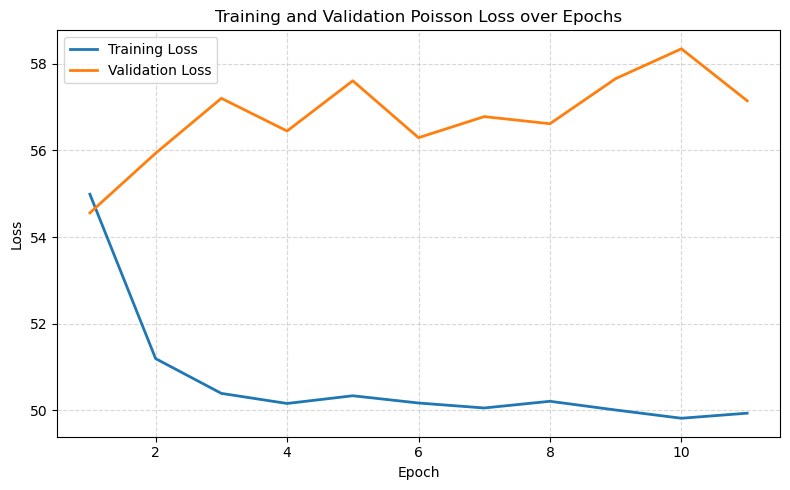

In [31]:
plot_training_history(training_history)
